In [1]:
%load_ext autoreload
%autoreload 2

# Register bigquery magic
%load_ext google.cloud.bigquery

# Imports

## General imports

In [2]:
# Regular Imports
import os
from datetime import datetime

from google.cloud import bigquery

import plotly
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default='notebook'

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib_venn import venn2_unweighted, venn3_unweighted

# increase cell/notebook display width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))


os.environ['GOOGLE_CLOUD_PROJECT'] = 'data-prod-165221'

## `subclu` imports (custom module)

In [3]:
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
    get_venn_sets2, get_venn_sets3
)
from subclu.utils.eda_geo_and_cultural_relevance import (
    show_geo_score_for_sub_single_table_new_metrics,
    show_geo_score_for_sub_single_table,
    show_geo_score_for_sub,
    display_top_subs_in_country,
)


setup_logging()
notebook_display_config()  # e.g., increases default font size in matplotlib
print_lib_versions([pd, np, sns, plotly])

python		v 3.7.11
===
pandas		v: 1.2.4
numpy		v: 1.19.5
seaborn		v: 0.11.1
plotly		v: 4.14.3


# Define top countries & some global columns

In [4]:
l_i18n_target_countries = [
    'Germany', 'Austria', 'Switzerland', 'India', 'France', 'Spain', 'Brazil', 'Portugal', 'Italy',
    'Mexico', 'Argentina', 'Chile',
    'Canada', 'United Kingdom', 'Australia',
]

# Pull data from BigQuery

## Candidate subreddits & ambassador subreddits

In [5]:
%%time
%%bigquery df_candidate_subreddits --project data-science-prod-218515

SELECT *
FROM `reddit-employee-datasets.david_bermejo.subclu_subreddit_geo_candidates_posts_no_removed_20220212`

WHERE subreddit_name != 'profile'

ORDER BY users_l7 DESC, posts_not_removed_l28 DESC

Downloading: 100%|███████████████████████████████████████████████████████| 331194/331194 [00:01<00:00, 235513.90rows/s]


CPU times: user 394 ms, sys: 189 ms, total: 582 ms
Wall time: 3.45 s


In [6]:
print(df_candidate_subreddits.shape)
df_candidate_subreddits.head(9)

(331194, 6)


,subreddit_name,subreddit_id,users_l7,posts_not_removed_l28,partition_date,successful_post_start_date
0,askreddit,t5_2qh1i,12225879,227351,2022-02-12,2022-01-14
1,antiwork,t5_2y77d,5968187,30843,2022-02-12,2022-01-14
2,funny,t5_2qh33,5751698,9992,2022-02-12,2022-01-14
3,interestingasfuck,t5_2qhsa,5630953,4514,2022-02-12,2022-01-14
4,mildlyinfuriating,t5_2ubgg,5562548,12837,2022-02-12,2022-01-14
5,pics,t5_2qh0u,4967535,19181,2022-02-12,2022-01-14
6,worldnews,t5_2qh13,4670856,6465,2022-02-12,2022-01-14
7,news,t5_2qh3l,4527284,5874,2022-02-12,2022-01-14
8,mademesmile,t5_2uqcm,4494911,8807,2022-02-12,2022-01-14


## Ambassador subreddits

In [7]:
%%time
%%bigquery df_ambassador_subs --project data-science-prod-218515

SELECT
    c.users_l7
    , posts_not_removed_l28
    , amb.*
FROM `reddit-employee-datasets.david_bermejo.ambassador_subreddits_union_20211216` AS amb
LEFT JOIN `reddit-employee-datasets.david_bermejo.subclu_subreddit_geo_candidates_posts_no_removed_20220122` c
    ON amb.subreddit_id = c.subreddit_id
    
WHERE amb.subreddit_id IS NOT NULL

ORDER BY 1 DESC, 2 DESC

Downloading: 100%|████████████████████████████████████████████████████████████████| 211/211 [00:01<00:00, 156.77rows/s]

CPU times: user 44.3 ms, sys: 11.5 ms, total: 55.9 ms
Wall time: 1.99 s


In [8]:
print(df_ambassador_subs.shape)
df_ambassador_subs.head(9)

(211, 11)


,users_l7,posts_not_removed_l28,subreddit_id,subreddit_name,i18n_topic,i18n_type,i18n_country_code,i18n_owner,i18n_type_2,ambassador_or_default_sub_germany,ambassador_or_default_sub_france
0,569489.0,2328.0,t5_22i0,de,None,organic,DE,None,None,True,False
1,494186.0,6067.0,t5_37k29,ich_iel,None,organic,DE,None,None,True,False
2,303499.0,4441.0,t5_2qhjz,askfrance,None,ambassador,FR,None,community builders,False,True
3,152153.0,2663.0,t5_2r6ca,fragreddit,None,organic,DE,None,inactive,True,False
4,118382.0,700.0,t5_3ntp6,wasletztepreis,None,organic,DE,None,None,True,False
5,102322.0,576.0,t5_33hvw,beziehungen,Dating & Relationship,ambassador,DE,None,None,True,False
6,64604.0,1113.0,t5_2yjbi,minecraftfr,None,ambassador,FR,None,community builders,False,True
7,62318.0,62.0,t5_30305,de_iama,None,organic,DE,None,None,True,False
8,52236.0,84.0,t5_3jxvk,tja,Fun,ambassador,DE,None,None,True,False


## Default geo-relevance score

In [9]:
%%time
%%bigquery df_geo_baseline --project data-science-prod-218515 

-- default geo-relevance list
SELECT *
FROM `reddit-employee-datasets.david_bermejo.subclu_subreddit_geo_score_default_daily_20220212`
WHERE
    subreddit_name != 'profile'
    AND (
        country_name IN (
            'Germany', 'Austria', 'Switzerland', 'India', 'France', 'Brazil', 'Portugal', 'Italy',
            'Spain', 'Mexico', 'Argentina', 'Chile'
        )
        -- OR geo_region = 'LATAM' -- LATAM is noisy, focus on top countries instead
        -- eng-i18n =  Canada, UK, Australia
        OR geo_country_code IN ('CA', 'GB', 'AU')
    )
;

Downloading: 100%|██████████████████████████████████████████████████████████| 13363/13363 [00:01<00:00, 11546.75rows/s]

CPU times: user 65.8 ms, sys: 24.2 ms, total: 90 ms
Wall time: 1.73 s


In [10]:
print(df_geo_baseline.shape)
df_geo_baseline.head(7)

(13363, 10)


,rating_short,rating_name,primary_topic,subreddit_name,subreddit_id,geo_country_code,country_name,geo_region,users_l7,posts_not_removed_l28
0,E,Everyone,"Culture, Race, and Ethnicity",argentina,t5_2qlht,AR,Argentina,LATAM,154681,3474
1,X,Sexually Explicit,Celebrity,celebsarg,t5_2aci6g,AR,Argentina,LATAM,123537,404
2,E,Everyone,Gaming,argaming,t5_2v8c6,AR,Argentina,LATAM,46216,587
3,X,Sexually Explicit,Mature Themes and Adult Content,argentinashott,t5_3rqp6x,AR,Argentina,LATAM,43613,1559
4,E,Everyone,Funny/Humor,dankgentina,t5_3hksc,AR,Argentina,LATAM,41480,727
5,E,Everyone,Mature Themes and Adult Content,antonelapane,t5_2wyaxt,AR,Argentina,LATAM,22716,10
6,E,Everyone,"Business, Economics, and Finance",merval,t5_32kag,AR,Argentina,LATAM,17971,116


## New geo-relevance scores, L28 days

- B. % of subreddit, lower threshold 
- C. % of country DAU

With this table we can also get the rank (D), but for E, we need to pull all the data for all countries, so maybe do that separately?

### SQL query

In [139]:
%%time
%%bigquery df_geo_new --project data-science-prod-218515

-- Select pre-calculated columns & some newly calculated columns
--  - B: % of users by subreddit
--  - C: % of users by country 
--  - D: subreddit rank for country (by % of users by subreddit)
--  - E: standardized(C, % of users by country)
-- for subs that meet minimum activity: 
--  >= 4 posts in L28 days
--  >= 45 users (unique user screenviews) in L28 days 

DECLARE MIN_POSTS_L28_NOT_REMOVED NUMERIC DEFAULT 4;
DECLARE min_users_geo_l7 NUMERIC DEFAULT 45;

-- Set minimum thresholds for calculating standardized score
--  because Some small islands screw up standard scores
DECLARE MIN_USERS_IN_SUBREDDIT_BY_COUNTRY DEFAULT 4;
DECLARE MIN_USERS_IN_COUNTRY_FOR_STDEV DEFAULT 80000;  -- Min coutry size to calculate stdev
DECLARE MIN_USERS_IN_COUNTRY DEFAULT 5000;  -- Min country size to display
DECLARE STANDARD_VALUE_WHEN_STDEV_ZERO DEFAULT 4;

WITH users_mean_and_stdev AS (
    -- get the mean, std, & subreddit count for each subreddit
    SELECT 
        subreddit_name
        , subreddit_id

        , COUNT(DISTINCT geo_country_code) as num_of_countries_with_visits_l28
        , AVG(users_percent_by_country) as users_percent_by_country_avg
        , COALESCE(STDDEV(users_percent_by_country), 0) as users_percent_by_country_stdev

        -- , AVG(users_percent_by_subreddit) as users_percent_by_subreddit_avg
        -- , STDDEV(users_percent_by_subreddit) as users_percent_by_subreddit_stdev
    FROM `reddit-employee-datasets.david_bermejo.subclu_subreddit_geo_score_pct_of_country_20220212` as geo
    WHERE
        -- subreddit filters
        posts_not_removed_l28 >= MIN_POSTS_L28_NOT_REMOVED
        AND users_l7 >= min_users_geo_l7
        AND subreddit_name != 'profile'
    
        -- country filters
        AND users_in_subreddit_from_country >= MIN_USERS_IN_SUBREDDIT_BY_COUNTRY
        AND total_users_in_country >= MIN_USERS_IN_COUNTRY_FOR_STDEV
        AND geo_country_code IS NOT NULL
    GROUP BY 1, 2
),

standard_score_and_rank_per_country AS (
    SELECT
        geo.geo_country_code
        , geo.posts_not_removed_l28
        , geo.users_l7
        , geo.subreddit_id
        , geo.subreddit_name
        -- some country names are null, so fill with code
        , COALESCE(geo.country_name, geo.geo_country_code) AS country_name

        , geo.users_percent_by_subreddit AS b_users_percent_by_subreddit
        , geo.users_percent_by_country AS c_users_percent_by_country
        , ROW_NUMBER() OVER (PARTITION BY country_name ORDER BY users_percent_by_country DESC) AS d_users_percent_by_country_rank 
        , CASE
            WHEN (m.users_percent_by_country_stdev = 0) THEN STANDARD_VALUE_WHEN_STDEV_ZERO
            ELSE (geo.users_percent_by_country - m.users_percent_by_country_avg) / m.users_percent_by_country_stdev
        END AS e_users_percent_by_country_standardized

        , geo.users_in_subreddit_from_country AS users_in_subreddit_from_country_l28
        , geo.total_users_in_country AS total_users_in_country_l28
        , geo.total_users_in_subreddit AS total_users_in_subreddit_l28
        
        , m.* EXCEPT(subreddit_name, subreddit_id)
        
        , geo.* EXCEPT(
            views_dt_start, views_dt_end, pt,
            posts_not_removed_l28, users_l7,
            subreddit_id, subreddit_name, geo_country_code, country_name,
            users_in_subreddit_from_country, total_users_in_country, total_users_in_subreddit,
            users_percent_by_subreddit, users_percent_by_country
        )

    FROM `reddit-employee-datasets.david_bermejo.subclu_subreddit_geo_score_pct_of_country_20220212` as geo
        LEFT JOIN users_mean_and_stdev AS m
            ON geo.subreddit_id = m.subreddit_id AND geo.subreddit_name = m.subreddit_name

    WHERE
        -- subreddit filters
        posts_not_removed_l28 >= MIN_POSTS_L28_NOT_REMOVED
        AND users_l7 >= min_users_geo_l7
        AND geo.subreddit_name != 'profile'

        -- country filters
        AND geo_country_code IS NOT NULL
        AND users_in_subreddit_from_country >= MIN_USERS_IN_SUBREDDIT_BY_COUNTRY
        AND total_users_in_country >= MIN_USERS_IN_COUNTRY
)


SELECT
    s.* EXCEPT(geo_region)
FROM standard_score_and_rank_per_country AS s

WHERE
    posts_not_removed_l28 >= MIN_POSTS_L28_NOT_REMOVED
    AND users_l7 >= min_users_geo_l7
    AND (
        e_users_percent_by_country_standardized >= 0.5
        OR s.country_name IN (
            'Germany', 'Austria', 'Switzerland', 'India', 'France', 'Spain', 'Brazil', 'Portugal', 'Italy',
            'Mexico', 'Argentina', 'Chile',
            'Canada', 'United Kingdom', 'Australia',
            'United States'  # use U.S. as a check
        )
        -- Could use country code for places where country name might not be standardized (e.g., UK & US)
        -- OR geo_country_code IN ('CA', 'GB', 'AU')
    )
ORDER BY users_l7 DESC, subreddit_name, c_users_percent_by_country DESC
;

Downloading: 100%|█████████████████████████████████████████████████████| 2519297/2519297 [00:04<00:00, 629556.25rows/s]


CPU times: user 2.62 s, sys: 1.93 s, total: 4.55 s
Wall time: 26.5 s


### Distribution checks

In [140]:
print(df_geo_new.shape)
df_geo_new.head(7)

(2519297, 19)


,geo_country_code,posts_not_removed_l28,users_l7,subreddit_id,subreddit_name,country_name,b_users_percent_by_subreddit,c_users_percent_by_country,d_users_percent_by_country_rank,e_users_percent_by_country_standardized,users_in_subreddit_from_country_l28,total_users_in_country_l28,total_users_in_subreddit_l28,num_of_countries_with_visits_l28,users_percent_by_country_avg,users_percent_by_country_stdev,over_18,verdict,type
0,IS,229399,12688040,t5_2qh1i,askreddit,Iceland,0.000665,0.066119,2,2.666823,19675,297568,29565392,119,0.03238,0.012652,f,None,public
1,TC,229399,12688040,t5_2qh1i,askreddit,Turks and Caicos Islands,0.000026,0.060715,1,2.239642,761,12534,29565392,119,0.03238,0.012652,f,None,public
2,CA,229399,12688040,t5_2qh1i,askreddit,Canada,0.082103,0.058489,1,2.063704,2427411,41502030,29565392,119,0.03238,0.012652,f,None,public
3,GG,229399,12688040,t5_2qh1i,askreddit,Guernsey,0.000058,0.057557,1,1.990049,1703,29588,29565392,119,0.03238,0.012652,f,None,public
4,FO,229399,12688040,t5_2qh1i,askreddit,Faroe Islands,0.000046,0.057028,1,1.948241,1364,23918,29565392,119,0.03238,0.012652,f,None,public
5,NZ,229399,12688040,t5_2qh1i,askreddit,New Zealand,0.007133,0.056664,2,1.919483,210883,3721617,29565392,119,0.03238,0.012652,f,None,public
6,AU,229399,12688040,t5_2qh1i,askreddit,Australia,0.041263,0.056395,1,1.898226,1219952,21632112,29565392,119,0.03238,0.012652,f,None,public


In [141]:
style_df_numeric(
    df_geo_new
    [['b_users_percent_by_subreddit',
      # 'c_users_percent_by_country',
               ]].fillna(0)
    .describe(
        percentiles=[.1, .25, .5, .75, .8, .9, .95, .98, .99, .995, .999, .9999]
    ).T,
    float_round=2,
    pct_labels='%',
    pct_cols=['mean', 'min', 'max'],
    pct_digits=1,
)

,count,mean,std,min,10%,25%,50%,75%,80%,90%,95%,98%,99%,99.5%,99.9%,99.99%,max
b_users_percent_by_subreddit,"2,519,297",4.0%,0.12,0.0%,0.0%,0.2%,0.6%,2.0%,2.9%,6.3%,15.1%,55.5%,68.2%,81.6%,94.1%,97.9%,100.0%


In [142]:
style_df_numeric(
    df_geo_new
    [[
      'c_users_percent_by_country',
               ]].fillna(0)
    .describe(
        percentiles=[.1, .25, .5, .75, .8, .9, .95, .98, .99, .995, .999, .9999]
    ).T,
    float_round=2,
    pct_labels='%',
    pct_cols=['mean', 'min', 'max'],
    pct_digits=3,
)

,count,mean,std,min,10%,25%,50%,75%,80%,90%,95%,98%,99%,99.5%,99.9%,99.99%,max
c_users_percent_by_country,"2,519,297",0.016%,0.00,0.000%,0.000%,0.000%,0.001%,0.007%,0.011%,0.028%,0.059%,0.133%,0.236%,0.428%,1.204%,2.925%,30.798%


### There should be no % over 100 (now that we're counting unique users)


In [143]:
(
    df_geo_new
    [df_geo_new['c_users_percent_by_country'] >= 0.97]
)

,geo_country_code,posts_not_removed_l28,users_l7,subreddit_id,subreddit_name,country_name,b_users_percent_by_subreddit,c_users_percent_by_country,d_users_percent_by_country_rank,e_users_percent_by_country_standardized,users_in_subreddit_from_country_l28,total_users_in_country_l28,total_users_in_subreddit_l28,num_of_countries_with_visits_l28,users_percent_by_country_avg,users_percent_by_country_stdev,over_18,verdict,type


In [144]:
(
    df_geo_new
    [df_geo_new['b_users_percent_by_subreddit'] >= 1.0]
)

,geo_country_code,posts_not_removed_l28,users_l7,subreddit_id,subreddit_name,country_name,b_users_percent_by_subreddit,c_users_percent_by_country,d_users_percent_by_country_rank,e_users_percent_by_country_standardized,users_in_subreddit_from_country_l28,total_users_in_country_l28,total_users_in_subreddit_l28,num_of_countries_with_visits_l28,users_percent_by_country_avg,users_percent_by_country_stdev,over_18,verdict,type
2389126,HR,11,113,t5_4s31bq,specijalizanti,Croatia,1.0,1.379018e-04,4989,4.0,174,1261767,174,1,1.379018e-04,0.0,None,None,private
2401705,US,7,105,t5_566jny,coloradosingleshookup,United States,1.0,1.135059e-06,83241,4.0,337,296900804,337,1,1.135059e-06,0.0,t,None,public
2431251,US,15,89,t5_5g8xv4,317b0ps,United States,1.0,9.262353e-07,87359,4.0,275,296900804,275,1,9.262353e-07,0.0,None,None,private
2435260,US,4,87,t5_4owol1,716hotties,United States,1.0,1.091274e-06,84074,4.0,324,296900804,324,1,1.091274e-06,0.0,t,None,public
2459589,US,4,74,t5_2serua,denversingles,United States,1.0,8.925540e-07,88086,4.0,265,296900804,265,1,8.925540e-07,0.0,t,None,public
2470155,US,4,69,t5_5or7eh,ibxnorthcarolina,United States,1.0,3.098678e-07,106066,4.0,92,296900804,92,1,3.098678e-07,0.0,None,None,public
2488248,US,13,60,t5_42rzw9,sandiegomingle,United States,1.0,5.995268e-07,95882,4.0,178,296900804,178,1,5.995268e-07,0.0,t,None,public
2505583,US,4,51,t5_51629k,fortwaynehfa,United States,1.0,6.433125e-07,94610,4.0,191,296900804,191,1,6.433125e-07,0.0,None,None,public
2509992,TR,4,49,t5_5ogzy5,faytklab,Turkey,1.0,1.061210e-05,27047,4.0,59,5559691,59,1,1.061210e-05,0.0,None,None,public


when we select >=1 standard deviation, we expect to select the top ~14.9% of the population.

NOTE: The distribution below is skewed because we filtered a lot fo subreddit+country pairs below zero.

In [145]:
style_df_numeric(
    df_geo_new
    [[
      'e_users_percent_by_country_standardized',
    ]].fillna(0)
    .describe(
        percentiles=[.1, .25, .5, .75, .8, .9, .95, .98, .99, .995, .999, .9999]
    ).T,
    float_round=2,
    # pct_labels='%',
    # pct_cols=['mean', 'min', 'max'],
    pct_digits=5,
)

,count,mean,std,min,10%,25%,50%,75%,80%,90%,95%,98%,99%,99.5%,99.9%,99.99%,max
e_users_percent_by_country_standardized,"2,519,297",0.81,26.55,-2.49,-0.70,-0.37,0.55,1.28,1.53,2.34,3.27,4.74,6.16,8.17,19.52,149.95,"36,565.19"


In [146]:
# ax = sns.boxenplot(
#     x=df_geo_new
#     .drop_duplicates(subset=['country_name'])
#     ['total_users_in_country_l28'].fillna(0)
# )

In [147]:
# ax = sns.boxenplot(
#     x=(
#         df_geo_new
#         [df_geo_new['total_users_in_country_l28'] <= 1e7]
#         .drop_duplicates(subset=['country_name'])
#         ['total_users_in_country_l28'].fillna(0)
#     )
# )

### What are ~MAU for i18n target countries?

In [148]:
style_df_numeric(
    df_geo_new
    .drop_duplicates(subset=['country_name'])
    [['total_users_in_country_l28',
               ]].fillna(0)
    .describe(
        percentiles=[.1, .25, .5, .75, .8, .9, .95]
    ).T,
    float_round=2,
    # pct_labels='%',
    # pct_cols=['mean', 'min', 'max'],
    pct_digits=5,
)

,count,mean,std,min,10%,25%,50%,75%,80%,90%,95%,max
total_users_in_country_l28,198,"3,469,331.39","21,697,529.65","5,012.00","11,360.20","30,093.50","189,513.00","1,342,661.25","2,090,089.60","3,723,964.50","10,913,035.40","296,900,804.00"


In [149]:
style_df_numeric(
    df_geo_new
    [df_geo_new['country_name'].isin(['United States'] + l_i18n_target_countries)]
    .drop_duplicates(subset=['country_name'])
    [['country_name', 'total_users_in_country_l28']]
    .sort_values(by=['total_users_in_country_l28'], ascending=False)
    .reset_index(drop=True)
)

,country_name,total_users_in_country_l28
0,United States,"296,900,804"
1,United Kingdom,"43,791,735"
2,Canada,"41,502,030"
3,Germany,"24,269,505"
4,Australia,"21,632,112"
5,India,"18,260,996"
6,Brazil,"16,717,071"
7,France,"10,828,979"
8,Mexico,"9,560,631"
9,Italy,"7,129,646"


In [150]:
fig = px.box(
    x=(
        df_geo_new
        [df_geo_new['total_users_in_country_l28'] <= 1e7]
        .drop_duplicates(subset=['country_name'])
        ['total_users_in_country_l28'].fillna(0)
    )
)
fig.show()

## Language by country
e.g., % of posts by detected language per country

In [151]:
%%time
%%bigquery df_language_by_country --project data-science-prod-218515 

-- Select language for target i18n countries
SELECT * 
FROM `reddit-employee-datasets.david_bermejo.subclu_posts_primary_language_by_country_20220122` as geo
WHERE 1=1
    AND (
        geolocation_country_name IN (
            'Germany', 'Austria', 'Switzerland', 'India', 'France', 'Spain', 'Brazil', 'Portugal', 'Italy',
            'Mexico', 'Argentina', 'Chile',
            'Canada', 'Australia', 'United Kingdom'
        )
    )
ORDER BY geolocation_country_name ASC, language_rank ASC
;

Downloading: 100%|████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 126.95rows/s]

CPU times: user 51.5 ms, sys: 11.5 ms, total: 63 ms
Wall time: 1.81 s


In [152]:
# df_language_by_country.to_csv('df_language_by_country.csv', index=False)

In [153]:
print(df_language_by_country.shape)
df_language_by_country.head(7)

(150, 10)


,geolocation_country_name,weighted_language,thing_type,total_count,language_count,language_percent,language_rank,language_name,language_name_top_only,language_in_use_multilingual
0,Argentina,en,post,103033,63372,0.615065,1,English,English,True
1,Argentina,es,post,103033,13387,0.129929,2,Spanish,Spanish,True
2,Argentina,UNKNOWN,post,103033,1631,0.015830,3,Unknown,Unknown,False
3,Argentina,la,post,103033,1128,0.010948,4,Latin,Other_language,False
4,Argentina,gl,post,103033,1092,0.010599,5,Galician,Other_language,False
5,Argentina,ca,post,103033,1088,0.010560,6,Catalan,Catalan,False
6,Argentina,it,post,103033,861,0.008357,7,Italian,Italian,True


## Language per subreddit

rank & % of posts per language, by subreddit

In [154]:
%%time
%%bigquery df_lang_by_subreddit --project data-science-prod-218515

-- Select only subreddits that have target language as primary or 2ndary language
WITH
    subreddits_with_target_languages AS (
        SELECT
            DISTINCT(subreddit_id) as subreddit_id
        FROM `reddit-employee-datasets.david_bermejo.subclu_posts_primary_language_by_subreddit_20220122` as geo
        WHERE
            subreddit_name IN (
                'formula1', 'rugbyunion', 'rugbyaustralia',
                'europe'
            )
            OR (
                (
                    language_rank = 1
                    OR language_rank = 2
                )
                AND language_name IN (
                    -- exclude English for now b/c it's most subreddits
                    -- 'English', 
                    'German', 
                    'French', 'Italian',
                    'Spanish', 'Portuguese',

                    -- Languages in India
                    'Hindi',
                    'Marathi',
                    'Tamil',
                    'Telugu',
                    'Malayalam'
                )
            )
    )


SELECT geo.*
FROM subreddits_with_target_languages sel
    LEFT JOIN `reddit-employee-datasets.david_bermejo.subclu_posts_primary_language_by_subreddit_20220122` AS geo
        ON sel.subreddit_id = geo.subreddit_id

WHERE
    language_rank <= 3
ORDER BY subreddit_name ASC, language_rank ASC
;

Downloading: 100%|██████████████████████████████████████████████████████████| 51633/51633 [00:01<00:00, 43084.09rows/s]

CPU times: user 109 ms, sys: 90 ms, total: 199 ms
Wall time: 1.84 s


In [155]:
# df_lang_by_subreddit.to_csv('df_lang_by_subreddit.csv', index=False)

In [156]:
print(df_lang_by_subreddit.shape)
df_lang_by_subreddit.head(7)

(51633, 14)


,rating_short,rating_name,primary_topic,subreddit_id,subreddit_name,weighted_language,thing_type,total_count,language_count,language_percent,language_rank,language_name,language_name_top_only,language_in_use_multilingual
0,None,None,None,t5_3cakx7,00fluffnstuff,en,post,41,23,0.560976,1,English,English,True
1,None,None,None,t5_3cakx7,00fluffnstuff,de,post,41,5,0.121951,2,German,German,True
2,None,None,None,t5_3cakx7,00fluffnstuff,lb,post,41,3,0.073171,3,Luxembourgish,Other_language,False
3,None,None,None,t5_4byrct,0nlyfantastic0,pt,post,13,7,0.538462,1,Portuguese,Portuguese,True
4,None,None,None,t5_4byrct,0nlyfantastic0,en,post,13,2,0.153846,2,English,English,True
5,None,None,None,t5_4byrct,0nlyfantastic0,es,post,13,1,0.076923,3,Spanish,Spanish,True
6,E,Everyone,Crypto,t5_5mmp3x,1000xcryptogems,en,post,34,33,0.970588,1,English,English,True


# Data overview

## Why 45 & 4 posts?

About half of all subreddits with 1+ users & 1+ posts (not removed) have 45+ users & 4+ posts.

But only 36.2% of subreddits have BOTH 45+ users AND 4+ posts not removed.

- Only about half of the ambassador or hand-picked subreddits are above this threshold.
- Most ambassador/default subs are no longer active

In [157]:
df_candidate_subreddits.shape

(331194, 8)

In [158]:
df_candidate_subreddits['users_l7_bins'] = pd.cut(
    df_candidate_subreddits['users_l7'],
    bins=[0, 44.999, df_candidate_subreddits['users_l7'].max()],
    labels=['00 to 44', '45+']
).astype(str)

df_candidate_subreddits['posts_not_removed_l28_bins'] = pd.cut(
    df_candidate_subreddits['posts_not_removed_l28'],
    bins=[0, 3.999, df_candidate_subreddits['posts_not_removed_l28'].max()],
    labels=['0 to 3', '04+']
).astype(str)

In [159]:
value_counts_and_pcts(
    df_candidate_subreddits['users_l7_bins'],
    count_type='subreddits',
    reset_index=True,
    add_col_prefix=False,
    cumsum=False
)

,users_l7_bins,subreddits_count,percent_of_subreddits
0,00 to 44,"176,490",53.3%
1,45+,"154,704",46.7%


In [160]:
value_counts_and_pcts(
    df_candidate_subreddits['posts_not_removed_l28_bins'],
    count_type='subreddits',
    reset_index=True,
    add_col_prefix=False,
    cumsum=False
)

,posts_not_removed_l28_bins,subreddits_count,percent_of_subreddits
0,04+,"170,833",51.6%
1,0 to 3,"160,361",48.4%


In [161]:
value_counts_and_pcts(
    df_candidate_subreddits,
    ['users_l7_bins', 'posts_not_removed_l28_bins'],
    count_type='subreddits',
    sort_index=True,
#     reset_index=True,
    add_col_prefix=False,
    cumsum=False
)

In [162]:
style_df_numeric(
    df_candidate_subreddits[['users_l7', 'posts_not_removed_l28']].fillna(0)
    .describe(
#         percentiles=[.1, .25, .472, .5, .527, .75, .9]
    ).T,
    float_round=1,
#     pct_cols=['mean', 'min', '25%', '50%', '75%', 'max'],
    pct_digits=3,
)

,count,mean,std,min,25%,50%,75%,max
users_l7,"331,194","3,525.5","55,973.0",1.0,4.0,34.0,335.0,"12,225,879.0"
posts_not_removed_l28,"331,194",89.6,"1,226.6",1.0,1.0,4.0,15.0,"293,266.0"


In [163]:
# value_counts_and_pcts(
#     pd.cut(df_candidate_subreddits['users_l7'], bins=10).astype(str)
# )

In [164]:
mask_amb_no_users = df_ambassador_subs['users_l7'].isnull()

style_df_numeric(
    df_ambassador_subs[['users_l7', 'posts_not_removed_l28']].fillna(0)
    .describe(
        # percentiles=[.1, .25, .475, .5, .525, .75, .9]
    ).T,
    float_round=2,
    # pct_cols=['mean', 'min', '25%', '50%', '75%', 'max'],
    pct_digits=3,
)

,count,mean,std,min,25%,50%,75%,max
users_l7,211,"11,577.12","57,840.34",0.00,0.00,58.00,999.50,"569,489.00"
posts_not_removed_l28,211,120.06,578.09,0.00,0.00,3.00,34.50,"6,067.00"


In [165]:
style_df_numeric(
    df_ambassador_subs[['users_l7', 'posts_not_removed_l28']]
    .describe(percentiles=[.1, .25, .475, .5, .525, .75, .9]).T,
    float_round=2,
    # pct_cols=['mean', 'min', '25%', '50%', '75%', 'max'],
    pct_digits=3,
)

,count,mean,std,min,10%,25%,47.5%,50%,52.5%,75%,90%,max
users_l7,122,"20,022.73","75,071.61",1.00,31.30,114.25,479.85,537.00,675.62,"6,606.25","34,738.60","569,489.00"
posts_not_removed_l28,122,207.64,749.44,1.00,2.00,5.00,20.00,22.00,27.58,83.50,388.50,"6,067.00"


In [166]:
# %%time
# fig = px.box(
#     df_candidate_subreddits,
#     y='users_l7',
#     log_y=True,
#     points='outliers',
# )
# fig.show()

In [167]:
# %%time
# ax = sns.boxenplot(
#     x=df_candidate_subreddits.sample(n=10000, random_state=42)
#     ["users_l7"]
# )
# ax.set(xscale="log")
# plt.show()

Tried a few other plots, but those were not helpful, noisy, or would take too long to compute

In [168]:
# fig = px.histogram(
#     df_candidate_subreddits[df_candidate_subreddits['users_l7'] <= 20000000], 
#     x="users_l7",
#     log_x=True,
#     # marginal="rug",
# )
# fig.show()

# fig = px.violin(
#     df_candidate_subreddits.sample(n=2000, random_state=42),
#     y='users_l7',
#     box=True,
#     points=False,
#     # log_y=True,
# )
# fig.show()

In [169]:
# %%time
# ax = sns.displot(
#     df_candidate_subreddits[df_candidate_subreddits['users_l7'] <= 2000000].sample(n=1000, random_state=42), 
#     x="users_l7",
#     # kde=True
# )
# ax.set(xscale="log")

# A) % by subreddit, daily [default @ 40%]

This default also limits to only subreddits with 100+ users L7.

In [170]:
# df_geo_baseline.head()

In [171]:

style_df_numeric(
    df_geo_baseline[['users_l7', 'posts_not_removed_l28']].fillna(0)
    .describe(
        # percentiles=[.1, .25, .475, .5, .525, .75, .9]
    ).T,
    float_round=2,
    # pct_cols=['mean', 'min', '25%', '50%', '75%', 'max'],
    pct_digits=3,
)

,count,mean,std,min,25%,50%,75%,max
users_l7,"13,363","4,085.07","28,679.06",100.00,190.00,480.00,"1,728.00","1,538,614.00"
posts_not_removed_l28,"13,363",122.61,671.85,4.00,8.00,18.00,56.00,"41,372.00"


In [172]:
counts_describe(
    df_geo_baseline[['subreddit_id', 'country_name']]
)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_id,object,"13,363","12,364",92.52%,0,0.00%
country_name,object,"13,363",15,0.11%,0,0.00%


# B) % by subreddit, L28 [lower threshold] & C) % by country, L28

These are in the same table/query, so we can do a quick check of them together.

First make sure that all of these subs are above users & activity threshold

In [173]:
style_df_numeric(
    df_geo_new
    .drop_duplicates(subset=['subreddit_id'])
    [['users_l7', 'posts_not_removed_l28',]].fillna(0)
    .describe(
        # percentiles=[.1, .25, .475, .5, .525, .75, .9]
    ).T,
    float_round=2,
    # pct_cols=['mean', 'min', '25%', '50%', '75%', 'max'],
    pct_digits=3,
)

,count,mean,std,min,25%,50%,75%,max
users_l7,"115,155","11,078.68","107,712.43",45.00,190.00,705.00,"2,998.00","12,688,040.00"
posts_not_removed_l28,"115,155",226.08,"2,004.20",4.00,9.00,23.00,84.50,"326,209.00"


create df with previous definition @ 16% of users

In [174]:
df_geo_16_pct_l28 = (
    df_geo_new[df_geo_new['b_users_percent_by_subreddit'] >= 0.16]
    .copy()
)
df_geo_16_pct_l28.shape

(124445, 19)

In [175]:
counts_describe(
    df_geo_new[['subreddit_id', 'country_name']]
)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_id,object,"2,519,297","115,155",4.57%,0,0.00%
country_name,object,"2,519,297",198,0.01%,0,0.00%


In [176]:
counts_describe(
    df_geo_16_pct_l28[['subreddit_id', 'country_name']]
)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_id,object,"124,445","114,708",92.18%,0,0.00%
country_name,object,"124,445",132,0.11%,0,0.00%


In [177]:
style_df_numeric(
    df_geo_new
    [['c_users_percent_by_country', 'b_users_percent_by_subreddit',
               ]].fillna(0)
    .describe(
        # percentiles=[.1, .25, .475, .5, .525, .75, .9]
    ).T,
    float_round=2,
    pct_cols=['mean', 'min', '25%', '50%', '75%', 'max'],
    pct_digits=3,
)

,count,mean,std,min,25%,50%,75%,max
c_users_percent_by_country,"2,519,297",0.016%,0.00,0.000%,0.000%,0.001%,0.007%,30.798%
b_users_percent_by_subreddit,"2,519,297",3.973%,0.12,0.000%,0.164%,0.585%,1.996%,100.000%


# F) Primary language, posts L28

Here we're checking rank 1 & rank 2, we' set the threshold for rank 1 (primary) after exploration.

In [178]:
df_lang_by_subreddit.shape

(51633, 14)

In [179]:
df_candidate_subreddits.head()

,subreddit_name,subreddit_id,users_l7,posts_not_removed_l28,partition_date,successful_post_start_date,users_l7_bins,posts_not_removed_l28_bins
0,askreddit,t5_2qh1i,12225879,227351,2022-02-12,2022-01-14,45+,04+
1,antiwork,t5_2y77d,5968187,30843,2022-02-12,2022-01-14,45+,04+
2,funny,t5_2qh33,5751698,9992,2022-02-12,2022-01-14,45+,04+
3,interestingasfuck,t5_2qhsa,5630953,4514,2022-02-12,2022-01-14,45+,04+
4,mildlyinfuriating,t5_2ubgg,5562548,12837,2022-02-12,2022-01-14,45+,04+


In [180]:
style_df_numeric(
    df_lang_by_subreddit.merge(
        df_candidate_subreddits[['subreddit_id', 'users_l7', 'posts_not_removed_l28',]],
        how='left',
        on=['subreddit_id']
    )
    [['users_l7', 'posts_not_removed_l28',]].fillna(0)
    .describe(
        # percentiles=[.1, .25, .475, .5, .525, .75, .9]
    ).T,
    float_round=2,
    # pct_labels='%',
    # pct_cols=['mean', 'min', 'max'],
    pct_digits=3,
)

,count,mean,std,min,25%,50%,75%,max
users_l7,"51,636","11,303.84","92,850.20",0.00,181.00,773.00,"3,380.00","4,967,535.00"
posts_not_removed_l28,"51,636",246.31,"2,568.64",0.00,10.00,31.00,115.00,"293,266.00"


In [181]:
counts_describe(
    df_lang_by_subreddit[['subreddit_id', 'language_name']]
)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_id,object,"51,633","18,191",35.23%,0,0.00%
language_name,object,"51,551",93,0.18%,82,0.16%


# Sanity checks

## Check specific subreddits

In [182]:
l_subs_to_check1 = [
    # 'cricket',
    # 'formula1',
    'rugbyunion',
    'rugbyaustralia',
    'bundesliga',
]
l_subs_to_check2 = [
    'premierleague',
    'reddevils',
    'liverpoolfc',
    'ligue1',
]

l_subs_to_check3 = [
    'laliga',
    'barca',
    'ligamx',
    'seriea', 
    # 'soccer',
]

In [183]:
l_cols_base_disp_check = [
    'subreddit_id',
    'subreddit_name',
    'geo_country_code',
    'country_name',
    'users_l7',
    'posts_not_removed_l28',
]
l_cols_geo_new_disp_check = [
    'subreddit_name',
    'country_name',
    'c_users_percent_by_country',
    'b_users_percent_by_subreddit',
    'users_in_subreddit_from_country_l28',
    'total_users_in_country_l28',
    'total_users_in_subreddit_l28',
]
l_cols_lang_disp_check = [
    'subreddit_id',
    'subreddit_name',
    'language_name',
    'language_percent',
    'language_rank',
    'language_count',
    'weighted_language',

    # 'langauge_in_use_multilingual',
]

In [184]:
# show_geo_score_for_sub(
#     'formula1',
#     top_n_pct_subreddit=9,
#     top_n_pct_country=9,
# )

In [185]:
# show_geo_score_for_sub(
#     'soccer',
#     top_n_pct_subreddit=11,
#     top_n_pct_country=11,
# )

In [186]:
# show_geo_score_for_sub(
#     'europe',
#     top_n_pct_subreddit=11,
#     top_n_pct_country=11,
# )

In [187]:
# for sub_ in l_subs_to_check1:
#     show_geo_score_for_sub(
#         sub_,
#         top_n_pct_subreddit=5,
#         top_n_pct_country=5,
#     )

## Ambassador subreddit ACTIVITY checks

In [188]:
mask_amb_over_45_users = df_ambassador_subs['users_l7'] >= 45
mask_amb_no_users = df_ambassador_subs['users_l7'].isnull()

df_ambassador_subs['users_l7_bin'] = np.where(
    mask_amb_over_45_users,
    '45+',
    np.where(
        mask_amb_no_users,
        '00',
        '01 to 45',
    )
)

In [189]:
value_counts_and_pcts(
    df_ambassador_subs['users_l7_bin'],
    sort_index=True,
    reset_index=True,
)

,users_l7_bin,users_l7_bin-count,users_l7_bin-percent,users_l7_bin-pct_cumulative_sum
0,00,89,42.2%,42.2%
1,01 to 45,14,6.6%,48.8%
2,45+,108,51.2%,100.0%


In [190]:
value_counts_and_pcts(
    df_ambassador_subs[~mask_amb_no_users]['users_l7_bin'],
    sort_index=True,
    reset_index=True,
    add_col_prefix=False,
    count_type='subreddits',
    cumsum=False,
).hide_index()

users_l7_bin,subreddits_count,percent_of_subreddits
01 to 45,14,11.5%
45+,108,88.5%


<AxesSubplot:xlabel='users_l7', ylabel='Proportion'>

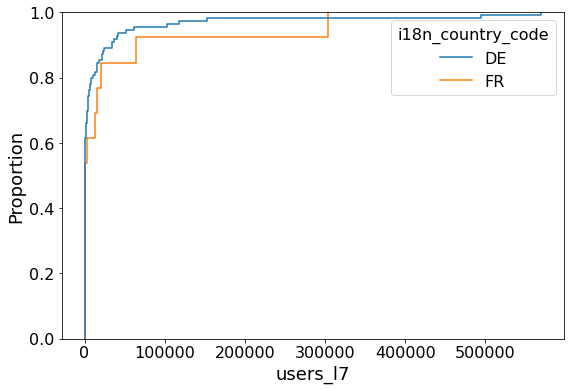

In [191]:
sns.ecdfplot(data=df_ambassador_subs, x="users_l7", hue="i18n_country_code")

<AxesSubplot:xlabel='users_l7', ylabel='Proportion'>

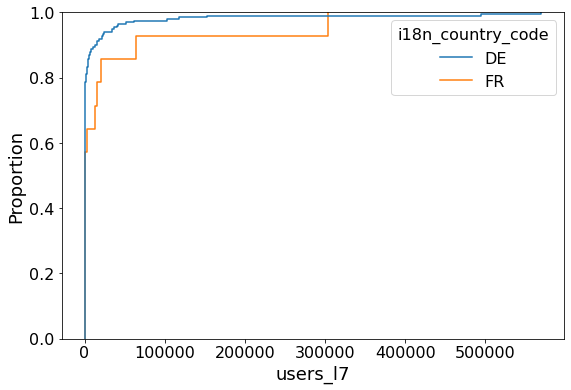

In [192]:
sns.ecdfplot(data=df_ambassador_subs.fillna(0), x="users_l7", hue="i18n_country_code")

<AxesSubplot:xlabel='users_l7', ylabel='Proportion'>

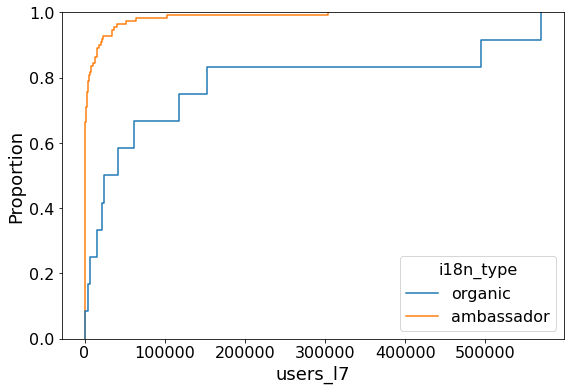

In [193]:
sns.ecdfplot(data=df_ambassador_subs, x="users_l7", hue="i18n_type")

<AxesSubplot:xlabel='users_l7', ylabel='Proportion'>

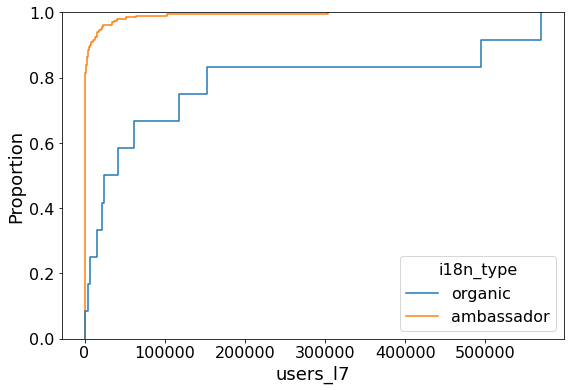

In [194]:
sns.ecdfplot(data=df_ambassador_subs.fillna(0), x="users_l7", hue="i18n_type")

# Check in a single table

put all the data in a single table so it's easier to see overlap & incremental gain per metric`m

## Define columns to display

In [195]:
l_cols_base_merge = [
    # 'subreddit_id',
    'subreddit_name',
    'country_name',
]

l_cols_lang_single = [c for c in l_cols_lang_disp_check if c != 'subreddit_id']

l_cols_new_pcts = l_cols_base_merge + [
    'b_users_percent_by_subreddit',
    'c_users_percent_by_country',
    'users_in_subreddit_from_country_l28',
    'total_users_in_subreddit_l28',
    'total_users_in_country_l28',
]

# for latest display with all metrics side by side
l_cols_new_pcts_extra = l_cols_base_merge + [
    'b_users_percent_by_subreddit',
    'c_users_percent_by_country',
    'd_users_percent_by_country_rank',
    'e_users_percent_by_country_standardized',
    'users_percent_by_country_avg',
    'num_of_countries_with_visits_l28',
    'users_in_subreddit_from_country_l28',
    # 'total_users_in_subreddit_l28',
    'total_users_in_country_l28',
]

## Custom list of subreddits


In [196]:
# show_geo_score_for_sub_single_table(
#     'cricket',
#     df_geo_baseline=df_geo_baseline,
#     df_geo_new=df_geo_new,
#     df_lang_by_subreddit=df_lang_by_subreddit,
#     top_n_pct_subreddit=9,
#     top_n_pct_country=9,
# )

In [197]:
show_geo_score_for_sub_single_table_new_metrics(
    'cricket',
    df_geo_baseline=df_geo_baseline,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
)



=== Subreddit: cricket ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
cricket,English,83.70%,1,"2,254",en
cricket,German,0.97%,2,26,de
cricket,Luxembourgish,0.93%,3,25,lb


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,cricket,India,False,21.857%,6.17,0.699%,62,0.061%,119,"127,598","18,260,996"
1,cricket,Australia,False,19.581%,4.52,0.528%,145,0.061%,119,"114,312","21,632,112"
2,cricket,Pakistan,False,1.030%,3.33,0.405%,118,0.061%,119,"6,015","1,486,677"
3,cricket,Sri Lanka,False,0.286%,2.96,0.367%,101,0.061%,119,"1,667","454,281"
4,cricket,New Zealand,False,2.044%,2.51,0.321%,285,0.061%,119,"11,931","3,721,617"
5,cricket,Nepal,False,0.234%,2.17,0.285%,189,0.061%,119,"1,364","478,806"
6,cricket,Barbados,False,0.039%,2.11,0.279%,216,0.061%,119,229,"82,033"
7,cricket,Gibraltar,False,0.008%,1.93,0.260%,309,0.061%,119,49,"18,865"
8,cricket,Oman,False,0.065%,1.59,0.225%,238,0.061%,119,382,"169,885"
9,cricket,South Africa,False,0.883%,1.36,0.201%,318,0.061%,119,"5,152","2,561,346"


In [ ]:
show_geo_score_for_sub_single_table_new_metrics(
    'soccer',
    df_geo_baseline=df_geo_baseline,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
)

In [ ]:
show_geo_score_for_sub_single_table_new_metrics(
    'formula1',
    df_geo_baseline=df_geo_baseline,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
)

In [200]:
for sub_ in l_subs_to_check1:
    show_geo_score_for_sub_single_table_new_metrics(
        sub_,
        df_geo_baseline=df_geo_baseline,
        df_geo_new=df_geo_new,
        df_lang_by_subreddit=df_lang_by_subreddit,
        top_n_pct_subreddit=7,
        top_n_pct_country=7,
    )



=== Subreddit: rugbyunion ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
rugbyunion,English,78.03%,1,856,en
rugbyunion,Norwegian,1.46%,2,16,no
rugbyunion,Danish,1.46%,3,16,da


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,rugbyunion,Ireland,False,10.587%,9.42,0.688%,98,0.023%,115,"24,328","3,537,708"
1,rugbyunion,Jersey,False,0.064%,3.69,0.284%,361,0.023%,115,146,"51,492"
2,rugbyunion,Fiji,False,0.038%,3.34,0.259%,222,0.023%,115,87,"33,582"
3,rugbyunion,United Kingdom,True,46.080%,3.10,0.242%,381,0.023%,115,"105,891","43,791,735"
4,rugbyunion,Guernsey,False,0.029%,2.83,0.223%,448,0.023%,115,66,"29,588"
5,rugbyunion,Andorra,False,0.020%,2.70,0.213%,305,0.023%,115,47,"22,015"
6,rugbyunion,Gibraltar,False,0.017%,2.53,0.201%,419,0.023%,115,38,"18,865"
7,rugbyunion,New Zealand,False,3.005%,2.30,0.186%,496,0.023%,115,"6,906","3,721,617"
8,rugbyunion,France,False,3.522%,0.73,0.075%,947,0.023%,115,"8,094","10,828,979"
9,rugbyunion,Australia,False,4.654%,0.37,0.049%,"1,934",0.023%,115,"10,694","21,632,112"




=== Subreddit: rugbyaustralia ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
rugbyaustralia,English,58.33%,1,7,en
rugbyaustralia,Dutch,16.67%,2,2,nl
rugbyaustralia,None,8.33%,3,1,be


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,rugbyaustralia,Australia,True,35.818%,3.61,0.003%,"15,986",0.000%,28,716,"21,632,112"
1,rugbyaustralia,Ireland,False,4.502%,2.64,0.003%,"20,093",0.000%,28,90,"3,537,708"
2,rugbyaustralia,New Zealand,False,3.202%,1.59,0.002%,"23,472",0.000%,28,64,"3,721,617"
3,rugbyaustralia,South Africa,False,1.201%,0.60,0.001%,"32,369",0.000%,28,24,"2,561,346"
4,rugbyaustralia,United Kingdom,False,19.760%,0.55,0.001%,"38,053",0.000%,28,395,"43,791,735"
5,rugbyaustralia,Portugal,False,0.350%,-0.27,0.000%,"52,013",0.000%,28,7,"2,779,803"
6,rugbyaustralia,Spain,False,0.650%,-0.32,0.000%,"56,321",0.000%,28,13,"6,067,189"
7,rugbyaustralia,Canada,False,3.402%,-0.38,0.000%,"68,455",0.000%,28,68,"41,502,030"
8,rugbyaustralia,United States,False,17.659%,-0.44,0.000%,"82,195",0.000%,28,353,"296,900,804"
9,rugbyaustralia,Germany,False,1.401%,-0.44,0.000%,"73,985",0.000%,28,28,"24,269,505"




=== Subreddit: bundesliga ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
bundesliga,English,44.44%,1,52,en
bundesliga,German,35.90%,2,42,de
bundesliga,French,4.27%,3,5,fr


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,bundesliga,Germany,True,61.331%,9.37,0.103%,967,0.005%,101,"25,022","24,269,505"
1,bundesliga,Liechtenstein,False,0.017%,4.56,0.053%,"1,879",0.005%,101,7,"13,287"
2,bundesliga,Luxembourg,False,0.184%,2.03,0.026%,"3,181",0.005%,101,75,"287,430"
3,bundesliga,Austria,False,1.422%,1.49,0.020%,"4,440",0.005%,101,580,"2,842,978"
4,bundesliga,Switzerland,False,0.971%,0.81,0.013%,"5,836",0.005%,101,396,"2,978,529"
5,bundesliga,Namibia,False,0.012%,0.53,0.010%,"6,369",0.005%,101,5,"48,213"
6,bundesliga,Portugal,False,0.324%,-0.00,0.005%,"10,670",0.005%,101,132,"2,779,803"
7,bundesliga,United Kingdom,False,4.812%,-0.03,0.004%,"14,898",0.005%,101,"1,963","43,791,735"
8,bundesliga,India,False,1.211%,-0.20,0.003%,"15,633",0.005%,101,494,"18,260,996"
9,bundesliga,Australia,False,1.257%,-0.23,0.002%,"19,631",0.005%,101,513,"21,632,112"


In [201]:
for sub_ in l_subs_to_check2:
    show_geo_score_for_sub_single_table_new_metrics(
        sub_,
        df_geo_baseline=df_geo_baseline,
        df_geo_new=df_geo_new,
        df_lang_by_subreddit=df_lang_by_subreddit,
        top_n_pct_subreddit=7,
        top_n_pct_country=7,
    )



=== Subreddit: premierleague ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
premierleague,English,91.36%,1,782,en
premierleague,French,2.57%,2,22,fr
premierleague,Filipino,0.58%,3,5,fil


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,premierleague,Greenland,False,0.020%,6.29,0.365%,233,0.057%,119,68,"18,611"
1,premierleague,Iceland,False,0.242%,4.47,0.276%,386,0.057%,119,821,"297,568"
2,premierleague,Guernsey,False,0.022%,4.08,0.257%,386,0.057%,119,76,"29,588"
3,premierleague,Ireland,False,2.623%,3.96,0.251%,360,0.057%,119,"8,882","3,537,708"
4,premierleague,Åland Islands,False,0.011%,3.89,0.247%,411,0.057%,119,38,"15,358"
5,premierleague,Jersey,False,0.037%,3.87,0.247%,420,0.057%,119,127,"51,492"
6,premierleague,United Kingdom,False,30.482%,3.65,0.236%,389,0.057%,119,"103,237","43,791,735"
7,premierleague,India,False,4.259%,0.45,0.079%,"1,054",0.057%,119,"14,423","18,260,996"
8,premierleague,Australia,False,4.665%,0.33,0.073%,"1,291",0.057%,119,"15,798","21,632,112"
9,premierleague,Canada,False,4.313%,-0.44,0.035%,"2,686",0.057%,119,"14,608","41,502,030"




=== Subreddit: reddevils ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
reddevils,English,75.80%,1,683,en
reddevils,Italian,2.55%,2,23,it
reddevils,Norwegian,1.66%,3,15,no


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,reddevils,Iceland,False,0.370%,7.69,1.750%,34,0.188%,119,"5,206","297,568"
1,reddevils,Ireland,False,2.224%,3.43,0.884%,67,0.188%,119,"31,259","3,537,708"
2,reddevils,Norway,False,1.916%,3.23,0.844%,80,0.188%,119,"26,929","3,190,255"
3,reddevils,Faroe Islands,False,0.013%,2.88,0.773%,113,0.188%,119,185,"23,918"
4,reddevils,Jersey,False,0.025%,2.43,0.682%,122,0.188%,119,351,"51,492"
5,reddevils,United Kingdom,False,20.892%,2.38,0.671%,99,0.188%,119,"293,680","43,791,735"
6,reddevils,Isle of Man,False,0.025%,2.29,0.652%,106,0.188%,119,352,"53,972"
7,reddevils,India,False,3.564%,0.43,0.274%,238,0.188%,119,"50,095","18,260,996"
8,reddevils,Australia,False,4.012%,0.36,0.261%,329,0.188%,119,"56,396","21,632,112"
9,reddevils,Canada,False,5.218%,-0.05,0.177%,492,0.188%,119,"73,351","41,502,030"




=== Subreddit: liverpoolfc ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,liverpoolfc,Iceland,False,0.414%,6.64,0.626%,155,0.075%,119,"1,864","297,568"
1,liverpoolfc,Ireland,False,3.211%,4.02,0.409%,216,0.075%,119,"14,454","3,537,708"
2,liverpoolfc,Faroe Islands,False,0.022%,3.98,0.406%,253,0.075%,119,97,"23,918"
3,liverpoolfc,Isle of Man,False,0.045%,3.63,0.376%,239,0.075%,119,203,"53,972"
4,liverpoolfc,Jersey,False,0.039%,3.19,0.340%,292,0.075%,119,175,"51,492"
5,liverpoolfc,Mauritius,False,0.114%,3.13,0.335%,142,0.075%,119,512,"152,878"
6,liverpoolfc,United Kingdom,False,29.157%,2.71,0.300%,296,0.075%,119,"131,234","43,791,735"
7,liverpoolfc,Australia,False,4.265%,0.17,0.089%,"1,056",0.075%,119,"19,195","21,632,112"
8,liverpoolfc,India,False,3.166%,0.04,0.078%,"1,072",0.075%,119,"14,248","18,260,996"
9,liverpoolfc,Canada,False,4.667%,-0.29,0.051%,"1,911",0.075%,119,"21,006","41,502,030"




=== Subreddit: ligue1 ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
ligue1,French,73.68%,1,56,fr
ligue1,English,11.84%,2,9,en
ligue1,Portuguese,3.95%,3,3,pt


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,ligue1,France,True,61.573%,6.91,0.030%,"2,398",0.001%,51,"3,288","10,828,979"
1,ligue1,Guadeloupe,False,0.075%,3.06,0.014%,"5,997",0.001%,51,4,"28,392"
2,ligue1,Martinique,False,0.075%,2.92,0.013%,"6,463",0.001%,51,4,"29,666"
3,ligue1,Luxembourg,False,0.187%,0.55,0.003%,"15,546",0.001%,51,10,"287,430"
4,ligue1,Switzerland,False,0.749%,0.05,0.001%,"28,026",0.001%,51,40,"2,978,529"
5,ligue1,Portugal,False,0.337%,-0.12,0.001%,"35,584",0.001%,51,18,"2,779,803"
6,ligue1,Canada,False,4.288%,-0.14,0.001%,"44,291",0.001%,51,229,"41,502,030"
7,ligue1,United Kingdom,False,4.082%,-0.15,0.000%,"49,402",0.001%,51,218,"43,791,735"
8,ligue1,Germany,False,1.854%,-0.18,0.000%,"49,300",0.001%,51,99,"24,269,505"
9,ligue1,India,False,0.843%,-0.21,0.000%,"50,259",0.001%,51,45,"18,260,996"


In [202]:
for sub_ in l_subs_to_check3:
    show_geo_score_for_sub_single_table_new_metrics(
        sub_,
        df_geo_baseline=df_geo_baseline,
        df_geo_new=df_geo_new,
        df_lang_by_subreddit=df_lang_by_subreddit,
        top_n_pct_subreddit=7,
        top_n_pct_country=7,
    )



=== Subreddit: laliga ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
laliga,English,75.83%,1,91,en
laliga,Spanish,3.33%,2,4,es
laliga,French,2.50%,3,3,fr


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,laliga,Tanzania,False,0.085%,4.91,0.006%,"7,208",0.001%,86,4,"69,140"
1,laliga,Spain,False,6.604%,4.18,0.005%,"10,206",0.001%,86,310,"6,067,189"
2,laliga,Ghana,False,0.170%,3.43,0.004%,"8,032",0.001%,86,8,"181,130"
3,laliga,Nigeria,False,0.554%,2.31,0.003%,"9,823",0.001%,86,26,"766,883"
4,laliga,Nepal,False,0.341%,2.26,0.003%,"12,092",0.001%,86,16,"478,806"
5,laliga,Tunisia,False,0.170%,1.72,0.003%,"14,320",0.001%,86,8,"281,496"
6,laliga,Lebanon,False,0.170%,1.70,0.003%,"16,978",0.001%,86,8,"282,897"
7,laliga,India,False,7.648%,0.77,0.002%,"18,865",0.001%,86,359,"18,260,996"
8,laliga,United Kingdom,False,8.905%,-0.33,0.001%,"37,021",0.001%,86,418,"43,791,735"
9,laliga,Canada,False,7.627%,-0.43,0.001%,"35,734",0.001%,86,358,"41,502,030"




=== Subreddit: barca ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
barca,English,81.03%,1,551,en
barca,Italian,1.76%,2,12,it
barca,Spanish,1.76%,3,12,es


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,barca,Sierra Leone,False,0.011%,5.11,0.139%,203,0.028%,115,12,"8,663"
1,barca,Liberia,False,0.006%,4.94,0.135%,229,0.028%,115,7,"5,192"
2,barca,Maldives,False,0.118%,4.87,0.133%,557,0.028%,115,132,"99,051"
3,barca,XK,False,0.070%,3.26,0.099%,"1,691",0.028%,115,78,"79,159"
4,barca,Ghana,False,0.152%,3.04,0.094%,404,0.028%,115,170,"181,130"
5,barca,Nepal,False,0.393%,2.93,0.091%,754,0.028%,115,438,"478,806"
6,barca,Bangladesh,False,0.817%,2.64,0.085%,743,0.028%,115,912,"1,071,258"
7,barca,India,False,8.992%,1.24,0.055%,"1,518",0.028%,115,"10,032","18,260,996"
8,barca,Netherlands,False,4.451%,1.10,0.052%,"1,838",0.028%,115,"4,966","9,555,855"
9,barca,Spain,False,2.653%,0.96,0.049%,"1,469",0.028%,115,"2,960","6,067,189"




=== Subreddit: ligamx ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
ligamx,English,38.06%,1,295,en
ligamx,Spanish,29.94%,2,232,es
ligamx,Italian,2.71%,3,21,it


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,ligamx,Mexico,False,18.819%,8.83,0.089%,830,0.003%,85,"8,469","9,560,631"
1,ligamx,Panama,False,0.096%,0.90,0.012%,"5,502",0.003%,85,43,"352,105"
2,ligamx,United States,False,62.066%,0.61,0.009%,"8,853",0.003%,85,"27,931","296,900,804"
3,ligamx,Guatemala,False,0.100%,0.57,0.009%,"5,923",0.003%,85,45,"501,805"
4,ligamx,Russian Federation,False,3.178%,0.52,0.009%,"4,682",0.003%,85,"1,430","16,775,607"
5,ligamx,Costa Rica,False,0.127%,0.52,0.008%,"7,683",0.003%,85,57,"671,415"
6,ligamx,Argentina,False,0.371%,0.10,0.004%,"9,261",0.003%,85,167,"3,729,442"
7,ligamx,Canada,False,3.595%,0.04,0.004%,"14,654",0.003%,85,"1,618","41,502,030"
8,ligamx,Brazil,False,0.764%,-0.15,0.002%,"14,971",0.003%,85,344,"16,717,071"
9,ligamx,United Kingdom,False,1.947%,-0.15,0.002%,"24,680",0.003%,85,876,"43,791,735"




=== Subreddit: seriea ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
seriea,English,76.98%,1,107,en
seriea,Italian,3.60%,2,5,it
seriea,French,3.60%,3,5,fr


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,seriea,Albania,False,0.585%,5.23,0.022%,"3,415",0.003%,95,57,"258,003"
1,seriea,Italy,False,15.631%,5.04,0.021%,"3,176",0.003%,95,"1,524","7,129,646"
2,seriea,Malta,False,0.421%,4.52,0.019%,"3,923",0.003%,95,41,"210,676"
3,seriea,XK,False,0.092%,2.35,0.011%,"7,273",0.003%,95,9,"79,159"
4,seriea,Montenegro,False,0.082%,1.84,0.009%,"6,448",0.003%,95,8,"84,434"
5,seriea,Macedonia,False,0.246%,1.57,0.008%,"7,654",0.003%,95,24,"283,292"
6,seriea,Bosnia and Herzegovina,False,0.277%,1.16,0.007%,"8,194",0.003%,95,27,"388,239"
7,seriea,Canada,False,10.000%,-0.08,0.002%,"20,191",0.003%,95,975,"41,502,030"
8,seriea,United Kingdom,False,9.415%,-0.14,0.002%,"23,998",0.003%,95,918,"43,791,735"
9,seriea,Australia,False,3.036%,-0.34,0.001%,"27,060",0.003%,95,296,"21,632,112"


## Check geo-relevance for ambassador subreddits

In [203]:
df_ambassador_subs.shape

(211, 12)

In [204]:
# df_ambassador_subs.head()

In [205]:
value_counts_and_pcts(
    df_ambassador_subs,
    ['i18n_country_code', 'i18n_type', 'users_l7_bin'],
    sort_index=True,
)

### Get list of subreddits

In [206]:
mask_amb_active = df_ambassador_subs['users_l7'] >= 45

l_fr_ambassador_subs = list(
    df_ambassador_subs
    [
        mask_amb_active &
        (df_ambassador_subs['i18n_type'] == 'ambassador') &
        (df_ambassador_subs['i18n_country_code'] == 'FR')
    ]
    .sort_values(by=['users_l7', 'posts_not_removed_l28'], ascending=False)
    ['subreddit_name']
)
print(len(l_fr_ambassador_subs))

l_de_ambassador_subs = list(
    df_ambassador_subs
    [
        mask_amb_active &
        (df_ambassador_subs['i18n_type'] == 'ambassador') &
        (df_ambassador_subs['i18n_country_code'] == 'DE')
    ]
    .sort_values(by=['users_l7', 'posts_not_removed_l28'], ascending=False)
    ['subreddit_name']
)
print(len(l_de_ambassador_subs))

l_de_organic_subs = list(
    df_ambassador_subs
    [
        mask_amb_active &
        (df_ambassador_subs['i18n_type'] == 'organic') &
        (df_ambassador_subs['i18n_country_code'] == 'DE')
    ]
    .sort_values(by=['users_l7', 'posts_not_removed_l28'], ascending=False)
    ['subreddit_name']
)
print(len(l_de_organic_subs))

11
85
12


### DE organic

In [207]:
for sub_ in l_de_organic_subs:
    show_geo_score_for_sub_single_table_new_metrics(
        sub_,
        df_geo_baseline=df_geo_baseline,
        df_geo_new=df_geo_new,
        df_lang_by_subreddit=df_lang_by_subreddit,
        top_n_pct_subreddit=4,
        top_n_pct_country=5,
    )



=== Subreddit: de ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
de,German,89.56%,1,"2,085",de
de,Luxembourgish,2.41%,2,56,lb
de,English,1.93%,3,45,en


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,de,Germany,True,69.254%,9.97,4.811%,1,0.130%,119,"1,167,549","24,269,505"
1,de,Austria,False,2.778%,3.23,1.647%,17,0.130%,119,"46,830","2,842,978"
2,de,Liechtenstein,False,0.010%,2.38,1.249%,27,0.130%,119,166,"13,287"
3,de,Switzerland,False,1.717%,1.79,0.972%,40,0.130%,119,"28,949","2,978,529"
4,de,Luxembourg,False,0.129%,1.33,0.755%,52,0.130%,119,"2,170","287,430"
5,de,United Kingdom,False,2.324%,-0.09,0.089%,"1,171",0.130%,119,"39,188","43,791,735"
6,de,United States,False,11.922%,-0.13,0.068%,"1,526",0.130%,119,"200,991","296,900,804"




=== Subreddit: ich_iel ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
ich_iel,German,97.16%,1,"5,888",de
ich_iel,Chinese,1.16%,2,70,zh
ich_iel,Latvian,0.46%,3,28,lv


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,ich_iel,Germany,True,63.360%,10.20,3.186%,3,0.091%,119,"773,323","24,269,505"
1,ich_iel,Liechtenstein,False,0.010%,2.58,0.873%,58,0.091%,119,116,"13,287"
2,ich_iel,Austria,False,1.982%,2.51,0.851%,65,0.091%,119,"24,194","2,842,978"
3,ich_iel,Switzerland,False,1.356%,1.53,0.556%,103,0.091%,119,"16,549","2,978,529"
4,ich_iel,Luxembourg,False,0.108%,1.22,0.460%,132,0.091%,119,"1,322","287,430"
5,ich_iel,United Kingdom,False,3.033%,-0.02,0.085%,"1,235",0.091%,119,"37,022","43,791,735"
6,ich_iel,United States,False,16.429%,-0.08,0.068%,"1,531",0.091%,119,"200,526","296,900,804"
7,ich_iel,Canada,False,2.266%,-0.08,0.067%,"1,437",0.091%,119,"27,660","41,502,030"




=== Subreddit: fragreddit ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
fragreddit,German,99.32%,1,"2,644",de
fragreddit,Luxembourgish,0.19%,2,5,lb
fragreddit,English,0.11%,3,3,en


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,fragreddit,Germany,True,91.221%,9.98,1.552%,13,0.025%,108,"376,634","24,269,505"
1,fragreddit,Austria,False,2.451%,2.16,0.356%,239,0.025%,108,"10,118","2,842,978"
2,fragreddit,Liechtenstein,False,0.010%,1.80,0.301%,267,0.025%,108,40,"13,287"
3,fragreddit,Switzerland,False,1.034%,0.77,0.143%,570,0.025%,108,"4,270","2,978,529"
4,fragreddit,Luxembourg,False,0.072%,0.51,0.103%,773,0.025%,108,296,"287,430"
5,fragreddit,United States,False,1.978%,-0.15,0.003%,"20,777",0.025%,108,"8,165","296,900,804"




=== Subreddit: wasletztepreis ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
wasletztepreis,German,79.69%,1,557,de
wasletztepreis,English,8.30%,2,58,en
wasletztepreis,Dutch,1.14%,3,8,nl


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,wasletztepreis,Germany,True,86.140%,9.59,1.121%,29,0.021%,107,"272,139","24,269,505"
1,wasletztepreis,Austria,False,3.471%,3.18,0.386%,219,0.021%,107,"10,967","2,842,978"
2,wasletztepreis,Liechtenstein,False,0.009%,1.72,0.218%,384,0.021%,107,29,"13,287"
3,wasletztepreis,Switzerland,False,1.424%,1.13,0.151%,541,0.021%,107,"4,498","2,978,529"
4,wasletztepreis,Luxembourg,False,0.091%,0.68,0.100%,813,0.021%,107,286,"287,430"
5,wasletztepreis,United States,False,4.935%,-0.14,0.005%,"13,493",0.021%,107,"15,592","296,900,804"




=== Subreddit: de_iama ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
de_iama,German,96.77%,1,60,de
de_iama,English,1.61%,2,1,en
de_iama,Afrikaans,1.61%,3,1,af


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,de_iama,Germany,True,87.533%,8.24,0.418%,171,0.010%,93,"101,392","24,269,505"
1,de_iama,Austria,False,5.865%,4.63,0.239%,359,0.010%,93,"6,794","2,842,978"
2,de_iama,Liechtenstein,False,0.011%,1.77,0.098%,969,0.010%,93,13,"13,287"
3,de_iama,Switzerland,False,0.900%,0.50,0.035%,"2,554",0.010%,93,"1,043","2,978,529"
4,de_iama,Spain,False,0.190%,-0.13,0.004%,"12,969",0.010%,93,220,"6,067,189"
5,de_iama,United States,False,1.822%,-0.19,0.001%,"44,224",0.010%,93,"2,110","296,900,804"




=== Subreddit: mauerstrassenwetten ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
mauerstrassenwetten,German,82.35%,1,420,de
mauerstrassenwetten,English,2.75%,2,14,en
mauerstrassenwetten,Luxembourgish,1.96%,3,10,lb


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,mauerstrassenwetten,Germany,True,87.226%,7.93,0.317%,268,0.009%,85,"76,831","24,269,505"
1,mauerstrassenwetten,Austria,False,5.374%,4.06,0.167%,546,0.009%,85,"4,734","2,842,978"
2,mauerstrassenwetten,Liechtenstein,False,0.016%,2.49,0.105%,868,0.009%,85,14,"13,287"
3,mauerstrassenwetten,Switzerland,False,1.939%,1.25,0.057%,"1,555",0.009%,85,"1,708","2,978,529"
4,mauerstrassenwetten,Cabo Verde,False,0.006%,0.89,0.043%,"1,446",0.009%,85,5,"11,506"
5,mauerstrassenwetten,United States,False,1.774%,-0.21,0.001%,"50,468",0.009%,85,"1,563","296,900,804"




=== Subreddit: germanrap ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
germanrap,German,57.26%,1,276,de
germanrap,English,4.98%,2,24,en
germanrap,Luxembourgish,3.32%,3,16,lb


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,germanrap,Germany,True,84.561%,7.76,0.284%,291,0.008%,86,"69,035","24,269,505"
1,germanrap,Austria,False,4.982%,3.79,0.143%,656,0.008%,86,"4,067","2,842,978"
2,germanrap,Switzerland,False,3.578%,2.52,0.098%,892,0.008%,86,"2,921","2,978,529"
3,germanrap,Liechtenstein,False,0.015%,2.30,0.090%,"1,005",0.008%,86,12,"13,287"
4,germanrap,Luxembourg,False,0.163%,1.07,0.046%,"1,831",0.008%,86,133,"287,430"
5,germanrap,United States,False,1.643%,-0.22,0.000%,"53,635",0.008%,86,"1,341","296,900,804"




=== Subreddit: kochen ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
kochen,German,81.88%,1,122,de
kochen,Luxembourgish,4.03%,2,6,lb
kochen,English,3.36%,3,5,en


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,kochen,Germany,True,94.880%,6.58,0.216%,407,0.006%,46,"52,516","24,269,505"
1,kochen,Austria,False,1.310%,0.61,0.026%,"3,654",0.006%,46,725,"2,842,978"
2,kochen,Switzerland,False,0.531%,0.12,0.010%,"7,349",0.006%,46,294,"2,978,529"
3,kochen,Spain,False,0.070%,-0.17,0.001%,"35,718",0.006%,46,39,"6,067,189"
4,kochen,Portugal,False,0.031%,-0.17,0.001%,"36,277",0.006%,46,17,"2,779,803"
5,kochen,United States,False,1.664%,-0.18,0.000%,"61,630",0.006%,46,921,"296,900,804"




=== Subreddit: bundesliga ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
bundesliga,English,44.44%,1,52,en
bundesliga,German,35.90%,2,42,de
bundesliga,French,4.27%,3,5,fr


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,bundesliga,Germany,True,61.331%,9.37,0.103%,967,0.005%,101,"25,022","24,269,505"
1,bundesliga,Liechtenstein,False,0.017%,4.56,0.053%,"1,879",0.005%,101,7,"13,287"
2,bundesliga,Luxembourg,False,0.184%,2.03,0.026%,"3,181",0.005%,101,75,"287,430"
3,bundesliga,Austria,False,1.422%,1.49,0.020%,"4,440",0.005%,101,580,"2,842,978"
4,bundesliga,Switzerland,False,0.971%,0.81,0.013%,"5,836",0.005%,101,396,"2,978,529"
5,bundesliga,United Kingdom,False,4.812%,-0.03,0.004%,"14,898",0.005%,101,"1,963","43,791,735"
6,bundesliga,Canada,False,2.319%,-0.24,0.002%,"20,575",0.005%,101,946,"41,502,030"
7,bundesliga,United States,False,12.699%,-0.29,0.002%,"27,609",0.005%,101,"5,181","296,900,804"




=== Subreddit: nachrichten ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
nachrichten,German,93.67%,1,74,de
nachrichten,Luxembourgish,3.80%,2,3,lb
nachrichten,Latvian,1.27%,3,1,lv


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,nachrichten,Germany,True,96.311%,5.09,0.066%,"1,585",0.003%,28,"15,927","24,269,505"
1,nachrichten,Austria,False,0.792%,0.15,0.005%,"13,621",0.003%,28,131,"2,842,978"
2,nachrichten,Switzerland,False,0.272%,-0.10,0.002%,"26,059",0.003%,28,45,"2,978,529"
3,nachrichten,Chile,False,0.109%,-0.16,0.001%,"31,469",0.003%,28,18,"2,471,090"
4,nachrichten,Mexico,False,0.194%,-0.19,0.000%,"45,563",0.003%,28,32,"9,560,631"
5,nachrichten,United Kingdom,False,0.466%,-0.21,0.000%,"70,052",0.003%,28,77,"43,791,735"
6,nachrichten,United States,False,0.768%,-0.22,0.000%,"101,684",0.003%,28,127,"296,900,804"




=== Subreddit: buecher ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
buecher,German,97.94%,1,95,de
buecher,English,1.03%,2,1,en
buecher,French,1.03%,3,1,fr


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,buecher,Germany,True,84.517%,5.24,0.033%,"3,046",0.002%,37,"8,030","24,269,505"
1,buecher,Austria,False,4.652%,2.30,0.016%,"5,563",0.002%,37,442,"2,842,978"
2,buecher,Switzerland,False,2.410%,0.98,0.008%,"8,896",0.002%,37,229,"2,978,529"
3,buecher,Spain,False,0.200%,-0.25,0.000%,"48,922",0.002%,37,19,"6,067,189"
4,buecher,France,False,0.253%,-0.27,0.000%,"55,253",0.002%,37,24,"10,828,979"
5,buecher,United States,False,3.242%,-0.29,0.000%,"85,067",0.002%,37,308,"296,900,804"




=== Subreddit: azubis ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
azubis,German,88.89%,1,16,de
azubis,English,11.11%,2,2,en


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,azubis,Germany,True,89.619%,1.77,0.002%,"25,083",0.000%,5,423,"24,269,505"
1,azubis,Austria,False,1.695%,-0.22,0.000%,"57,076",0.000%,5,8,"2,842,978"
2,azubis,Switzerland,False,0.847%,-0.42,0.000%,"71,768",0.000%,5,4,"2,978,529"
3,azubis,United States,False,0.847%,-0.60,0.000%,"114,955",0.000%,5,4,"296,900,804"


### French Ambassador subs

In [208]:
for sub_ in l_fr_ambassador_subs:
    show_geo_score_for_sub_single_table_new_metrics(
        sub_,
        df_geo_baseline=df_geo_baseline,
        df_geo_new=df_geo_new,
        df_lang_by_subreddit=df_lang_by_subreddit,
        top_n_pct_subreddit=4,
        top_n_pct_country=5,
    )



=== Subreddit: askfrance ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
askfrance,English,68.07%,1,113,en
askfrance,French,26.51%,2,44,fr
askfrance,Catalan,1.20%,3,2,ca


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,askfrance,France,True,82.843%,9.92,0.609%,51,0.009%,101,"65,933","10,828,979"
1,askfrance,French Guiana,False,0.008%,0.77,0.056%,"1,305",0.009%,101,6,"10,774"
2,askfrance,Guadeloupe,False,0.016%,0.60,0.046%,"1,744",0.009%,101,13,"28,392"
3,askfrance,Monaco,False,0.005%,0.50,0.040%,"1,595",0.009%,101,4,"10,073"
4,askfrance,Switzerland,False,0.392%,0.02,0.010%,"7,012",0.009%,101,312,"2,978,529"
5,askfrance,United Kingdom,False,1.877%,-0.10,0.003%,"17,806",0.009%,101,"1,494","43,791,735"
6,askfrance,Canada,False,1.406%,-0.11,0.003%,"18,561",0.009%,101,"1,119","41,502,030"
7,askfrance,United States,False,6.927%,-0.12,0.002%,"26,557",0.009%,101,"5,513","296,900,804"




=== Subreddit: minecraftfr ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
minecraftfr,French,85.00%,1,34,fr
minecraftfr,Swahili,2.50%,2,1,sw
minecraftfr,Irish,2.50%,3,1,ga


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,minecraftfr,France,True,76.526%,1.98,0.003%,"14,970",0.001%,6,326,"10,828,979"
1,minecraftfr,Switzerland,False,1.174%,-0.42,0.000%,"67,377",0.001%,6,5,"2,978,529"
2,minecraftfr,Canada,False,4.460%,-0.52,0.000%,"94,013",0.001%,6,19,"41,502,030"
3,minecraftfr,United Kingdom,False,0.939%,-0.55,0.000%,"110,259",0.001%,6,4,"43,791,735"
4,minecraftfr,United States,False,5.869%,-0.55,0.000%,"112,943",0.001%,6,25,"296,900,804"




=== Subreddit: frenchmemes ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
frenchmemes,French,51.61%,1,48,fr
frenchmemes,English,18.28%,2,17,en
frenchmemes,Haitian Creole,2.15%,3,2,ht


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,frenchmemes,France,True,87.347%,9.06,0.557%,60,0.009%,85,"60,284","10,828,979"
1,frenchmemes,Monaco,False,0.013%,1.33,0.089%,738,0.009%,85,9,"10,073"
2,frenchmemes,French Guiana,False,0.012%,1.08,0.074%,993,0.009%,85,8,"10,774"
3,frenchmemes,Réunion,False,0.067%,0.75,0.054%,"1,384",0.009%,85,46,"84,681"
4,frenchmemes,Martinique,False,0.023%,0.74,0.054%,"1,535",0.009%,85,16,"29,666"
5,frenchmemes,United Kingdom,False,1.177%,-0.12,0.002%,"25,847",0.009%,85,812,"43,791,735"
6,frenchmemes,Canada,False,1.071%,-0.12,0.002%,"23,956",0.009%,85,739,"41,502,030"
7,frenchmemes,United States,False,4.474%,-0.14,0.001%,"36,606",0.009%,85,"3,088","296,900,804"




=== Subreddit: strasbourg ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
strasbourg,French,71.43%,1,60,fr
strasbourg,English,13.10%,2,11,en
strasbourg,Persian,7.14%,3,6,fa


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,strasbourg,France,True,91.379%,6.24,0.174%,335,0.005%,41,"18,793","10,828,979"
1,strasbourg,Germany,False,2.961%,-0.09,0.003%,"20,492",0.005%,41,609,"24,269,505"
2,strasbourg,Switzerland,False,0.336%,-0.10,0.002%,"20,126",0.005%,41,69,"2,978,529"
3,strasbourg,Spain,False,0.107%,-0.17,0.000%,"46,147",0.005%,41,22,"6,067,189"
4,strasbourg,Austria,False,0.039%,-0.17,0.000%,"56,646",0.005%,41,8,"2,842,978"
5,strasbourg,United Kingdom,False,0.583%,-0.17,0.000%,"61,110",0.005%,41,120,"43,791,735"
6,strasbourg,United States,False,1.843%,-0.18,0.000%,"80,701",0.005%,41,379,"296,900,804"




=== Subreddit: francedetendue ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
francedetendue,French,79.25%,1,126,fr
francedetendue,Catalan,2.52%,2,4,ca
francedetendue,Latin,2.52%,3,4,la


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,francedetendue,France,True,92.943%,7.80,0.444%,90,0.008%,63,"48,111","10,828,979"
1,francedetendue,French Guiana,False,0.012%,0.84,0.056%,"1,455",0.008%,63,6,"10,774"
2,francedetendue,Martinique,False,0.027%,0.69,0.047%,"1,817",0.008%,63,14,"29,666"
3,francedetendue,Switzerland,False,0.319%,-0.05,0.006%,"11,316",0.008%,63,165,"2,978,529"
4,francedetendue,Austria,False,0.064%,-0.13,0.001%,"31,348",0.008%,63,33,"2,842,978"
5,francedetendue,Canada,False,0.742%,-0.14,0.001%,"34,474",0.008%,63,384,"41,502,030"
6,francedetendue,United Kingdom,False,0.780%,-0.14,0.001%,"37,681",0.008%,63,404,"43,791,735"
7,francedetendue,United States,False,2.274%,-0.14,0.000%,"56,414",0.008%,63,"1,177","296,900,804"




=== Subreddit: sexualitefr ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
sexualitefr,French,100.00%,1,32,fr


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,sexualitefr,France,True,73.396%,6.52,0.064%,"1,128",0.003%,58,"6,933","10,828,979"
1,sexualitefr,Martinique,False,0.106%,3.29,0.034%,"2,495",0.003%,58,10,"29,666"
2,sexualitefr,Réunion,False,0.286%,3.10,0.032%,"2,382",0.003%,58,27,"84,681"
3,sexualitefr,Guadeloupe,False,0.085%,2.70,0.028%,"2,786",0.003%,58,8,"28,392"
4,sexualitefr,New Caledonia,False,0.042%,2.18,0.023%,"2,619",0.003%,58,4,"17,189"
5,sexualitefr,Belgium,False,2.911%,0.57,0.008%,"8,436",0.003%,58,275,"3,379,483"
6,sexualitefr,Canada,False,3.102%,-0.22,0.001%,"39,454",0.003%,58,293,"41,502,030"
7,sexualitefr,United States,False,6.680%,-0.28,0.000%,"69,759",0.003%,58,631,"296,900,804"




=== Subreddit: parentingfr ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
parentingfr,French,85.00%,1,17,fr
parentingfr,English,10.00%,2,2,en
parentingfr,Danish,5.00%,3,1,da


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,parentingfr,France,True,76.220%,4.34,0.016%,"4,271",0.001%,23,"1,702","10,828,979"
1,parentingfr,Réunion,False,0.179%,1.06,0.005%,"11,216",0.001%,23,4,"84,681"
2,parentingfr,Switzerland,False,0.851%,-0.16,0.001%,"40,378",0.001%,23,19,"2,978,529"
3,parentingfr,Spain,False,0.582%,-0.29,0.000%,"56,221",0.001%,23,13,"6,067,189"
4,parentingfr,Austria,False,0.269%,-0.29,0.000%,"61,448",0.001%,23,6,"2,842,978"
5,parentingfr,Canada,False,3.269%,-0.30,0.000%,"67,051",0.001%,23,73,"41,502,030"
6,parentingfr,United Kingdom,False,1.702%,-0.33,0.000%,"83,746",0.001%,23,38,"43,791,735"
7,parentingfr,United States,False,8.061%,-0.34,0.000%,"95,678",0.001%,23,180,"296,900,804"




=== Subreddit: philosophie ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
philosophie,French,80.00%,1,8,fr
philosophie,English,10.00%,2,1,en
philosophie,German,10.00%,3,1,de


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,philosophie,France,True,49.030%,3.19,0.003%,"14,155",0.001%,15,354,"10,828,979"
1,philosophie,Algeria,False,0.970%,0.96,0.001%,"23,274",0.001%,15,7,"524,783"
2,philosophie,Morocco,False,1.108%,0.76,0.001%,"26,121",0.001%,15,8,"688,950"
3,philosophie,Germany,False,13.019%,-0.14,0.000%,"50,180",0.001%,15,94,"24,269,505"
4,philosophie,Switzerland,False,1.247%,-0.24,0.000%,"54,858",0.001%,15,9,"2,978,529"
5,philosophie,Canada,False,7.064%,-0.44,0.000%,"74,423",0.001%,15,51,"41,502,030"
6,philosophie,United States,False,7.064%,-0.57,0.000%,"110,512",0.001%,15,51,"296,900,804"




=== Subreddit: culturepop ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
culturepop,French,88.89%,1,16,fr
culturepop,English,5.56%,2,1,en
culturepop,Luxembourgish,5.56%,3,1,lb


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,culturepop,France,False,82.787%,2.04,0.003%,"15,693",0.001%,6,303,"10,828,979"
1,culturepop,Canada,False,2.459%,-0.43,0.000%,"104,893",0.001%,6,9,"41,502,030"
2,culturepop,United States,False,2.732%,-0.45,0.000%,"114,390",0.001%,6,10,"296,900,804"




=== Subreddit: ndflex ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
ndflex,French,66.67%,1,10,fr
ndflex,Catalan,6.67%,2,1,ca
ndflex,Norwegian,6.67%,3,1,no


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,ndflex,France,True,85.899%,4.52,0.027%,"2,687",0.002%,26,"2,918","10,828,979"
1,ndflex,Réunion,False,0.265%,1.58,0.011%,"6,575",0.002%,26,9,"84,681"
2,ndflex,Switzerland,False,1.266%,-0.07,0.001%,"26,804",0.002%,26,43,"2,978,529"
3,ndflex,Austria,False,0.353%,-0.26,0.000%,"49,657",0.002%,26,12,"2,842,978"
4,ndflex,Germany,False,1.413%,-0.30,0.000%,"63,734",0.002%,26,48,"24,269,505"
5,ndflex,Canada,False,1.325%,-0.31,0.000%,"77,388",0.002%,26,45,"41,502,030"
6,ndflex,United States,False,1.560%,-0.33,0.000%,"110,401",0.002%,26,53,"296,900,804"




=== Subreddit: lejournaldescrypto ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
lejournaldescrypto,French,100.00%,1,10,fr


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,lejournaldescrypto,France,False,85.987%,1.49,0.002%,"16,878",0.001%,4,270,"10,828,979"
1,lejournaldescrypto,Switzerland,False,2.229%,-0.42,0.000%,"60,534",0.001%,4,7,"2,978,529"
2,lejournaldescrypto,United States,False,2.866%,-0.61,0.000%,"114,494",0.001%,4,9,"296,900,804"


### German Ambassador subs

Split this one up because with over 80 it'll take too long to view them all

In [209]:
for sub_ in l_de_ambassador_subs[:10]:
    show_geo_score_for_sub_single_table_new_metrics(
        sub_,
        df_geo_baseline=df_geo_baseline,
        df_geo_new=df_geo_new,
        df_lang_by_subreddit=df_lang_by_subreddit,
        top_n_pct_subreddit=4,
        top_n_pct_country=5,
    )



=== Subreddit: beziehungen ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
beziehungen,German,99.65%,1,572,de
beziehungen,Finnish,0.35%,2,2,fi


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,beziehungen,Germany,True,97.590%,8.58,0.768%,61,0.013%,76,"186,355","24,269,505"
1,beziehungen,Austria,False,0.734%,0.41,0.049%,"2,024",0.013%,76,"1,402","2,842,978"
2,beziehungen,Switzerland,False,0.366%,0.12,0.023%,"3,654",0.013%,76,699,"2,978,529"
3,beziehungen,Spain,False,0.121%,-0.10,0.004%,"12,572",0.013%,76,231,"6,067,189"
4,beziehungen,France,False,0.129%,-0.12,0.002%,"17,891",0.013%,76,246,"10,828,979"
5,beziehungen,United States,False,0.549%,-0.14,0.000%,"58,850",0.013%,76,"1,049","296,900,804"




=== Subreddit: tja ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
tja,Estonian,98.81%,1,83,et
tja,German,1.19%,2,1,de


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,tja,Germany,True,95.315%,8.04,0.686%,80,0.013%,67,"166,426","24,269,505"
1,tja,Austria,False,0.695%,0.36,0.043%,"2,297",0.013%,67,"1,214","2,842,978"
2,tja,Switzerland,False,0.384%,0.11,0.022%,"3,781",0.013%,67,670,"2,978,529"
3,tja,Spain,False,0.061%,-0.13,0.002%,"20,643",0.013%,67,106,"6,067,189"
4,tja,Portugal,False,0.022%,-0.14,0.001%,"23,202",0.013%,67,39,"2,779,803"
5,tja,United States,False,1.746%,-0.14,0.001%,"36,847",0.013%,67,"3,048","296,900,804"




=== Subreddit: augenbleiche ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
augenbleiche,German,62.65%,1,421,de
augenbleiche,Luxembourgish,4.32%,2,29,lb
augenbleiche,Dutch,2.38%,3,16,nl


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,augenbleiche,Germany,True,88.582%,8.59,0.364%,218,0.007%,76,"88,252","24,269,505"
1,augenbleiche,Austria,False,0.576%,0.32,0.020%,"4,493",0.007%,76,574,"2,842,978"
2,augenbleiche,Switzerland,False,0.313%,0.09,0.010%,"7,025",0.007%,76,312,"2,978,529"
3,augenbleiche,United Kingdom,False,0.829%,-0.12,0.002%,"25,608",0.007%,76,826,"43,791,735"
4,augenbleiche,United States,False,5.562%,-0.12,0.002%,"26,485",0.007%,76,"5,541","296,900,804"
5,augenbleiche,Canada,False,0.723%,-0.12,0.002%,"24,305",0.007%,76,720,"41,502,030"




=== Subreddit: de_edv ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
de_edv,German,95.36%,1,493,de
de_edv,English,1.93%,2,10,en
de_edv,Luxembourgish,0.58%,3,3,lb


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,de_edv,Germany,True,87.815%,8.20,0.365%,217,0.009%,81,"88,503","24,269,505"
1,de_edv,Austria,False,3.959%,3.03,0.140%,672,0.009%,81,"3,990","2,842,978"
2,de_edv,Liechtenstein,False,0.017%,2.74,0.128%,730,0.009%,81,17,"13,287"
3,de_edv,Switzerland,False,1.447%,0.92,0.049%,"1,848",0.009%,81,"1,458","2,978,529"
4,de_edv,Luxembourg,False,0.115%,0.72,0.040%,"2,159",0.009%,81,116,"287,430"
5,de_edv,United States,False,2.303%,-0.19,0.001%,"42,287",0.009%,81,"2,321","296,900,804"




=== Subreddit: binichdasarschloch ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
binichdasarschloch,German,100.00%,1,16,de


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,binichdasarschloch,Germany,True,99.115%,6.71,0.564%,112,0.013%,47,"136,908","24,269,505"
1,binichdasarschloch,Austria,False,0.279%,0.01,0.014%,"6,212",0.013%,47,385,"2,842,978"
2,binichdasarschloch,Switzerland,False,0.151%,-0.07,0.007%,"9,597",0.013%,47,208,"2,978,529"
3,binichdasarschloch,Spain,False,0.039%,-0.15,0.001%,"30,323",0.013%,47,54,"6,067,189"
4,binichdasarschloch,Portugal,False,0.017%,-0.15,0.001%,"31,310",0.013%,47,23,"2,779,803"
5,binichdasarschloch,United States,False,0.256%,-0.16,0.000%,"82,190",0.013%,47,354,"296,900,804"




=== Subreddit: lustig ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
lustig,German,61.90%,1,182,de
lustig,Unknown,4.42%,2,13,UNKNOWN
lustig,Luxembourgish,3.74%,3,11,lb


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,lustig,Germany,True,92.673%,8.82,0.337%,249,0.006%,80,"81,902","24,269,505"
1,lustig,Austria,False,0.494%,0.26,0.015%,"5,602",0.006%,80,437,"2,842,978"
2,lustig,Switzerland,False,0.282%,0.07,0.008%,"8,320",0.006%,80,249,"2,978,529"
3,lustig,India,False,0.568%,-0.08,0.003%,"15,466",0.006%,80,502,"18,260,996"
4,lustig,France,False,0.129%,-0.12,0.001%,"27,757",0.006%,80,114,"10,828,979"
5,lustig,United States,False,3.002%,-0.13,0.001%,"39,554",0.006%,80,"2,653","296,900,804"




=== Subreddit: fotografie ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
fotografie,German,55.09%,1,92,de
fotografie,English,7.19%,2,12,en
fotografie,Korean,4.79%,3,8,ko


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,fotografie,Germany,True,98.641%,6.00,0.254%,327,0.007%,38,"61,692","24,269,505"
1,fotografie,Austria,False,0.150%,-0.09,0.003%,"16,882",0.007%,38,94,"2,842,978"
2,fotografie,Switzerland,False,0.082%,-0.13,0.002%,"24,224",0.007%,38,51,"2,978,529"
3,fotografie,Italy,False,0.066%,-0.16,0.001%,"37,732",0.007%,38,41,"7,129,646"
4,fotografie,Spain,False,0.032%,-0.17,0.000%,"48,103",0.007%,38,20,"6,067,189"
5,fotografie,United Kingdom,False,0.102%,-0.17,0.000%,"73,674",0.007%,38,64,"43,791,735"
6,fotografie,United States,False,0.353%,-0.17,0.000%,"91,696",0.007%,38,221,"296,900,804"




=== Subreddit: vegande ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
vegande,German,87.12%,1,203,de
vegande,English,3.43%,2,8,en
vegande,Estonian,1.29%,3,3,et


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,vegande,Germany,True,90.076%,6.74,0.196%,459,0.006%,52,"47,460","24,269,505"
1,vegande,Austria,False,2.976%,1.74,0.055%,"1,796",0.006%,52,"1,568","2,842,978"
2,vegande,Liechtenstein,False,0.009%,1.11,0.038%,"2,518",0.006%,52,5,"13,287"
3,vegande,Switzerland,False,1.609%,0.79,0.028%,"3,075",0.006%,52,848,"2,978,529"
4,vegande,Portugal,False,0.078%,-0.17,0.001%,"22,529",0.006%,52,41,"2,779,803"
5,vegande,United States,False,1.712%,-0.21,0.000%,"62,101",0.006%,52,902,"296,900,804"




=== Subreddit: augenschmaus ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
augenschmaus,German,67.09%,1,267,de
augenschmaus,Finnish,3.52%,2,14,fi
augenschmaus,Luxembourgish,3.02%,3,12,lb


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,augenschmaus,Germany,True,95.862%,6.70,0.185%,495,0.005%,47,"44,780","24,269,505"
1,augenschmaus,Austria,False,0.462%,0.11,0.008%,"9,579",0.005%,47,216,"2,842,978"
2,augenschmaus,Switzerland,False,0.178%,-0.07,0.003%,"17,992",0.005%,47,83,"2,978,529"
3,augenschmaus,Chile,False,0.034%,-0.15,0.001%,"33,720",0.005%,47,16,"2,471,090"
4,augenschmaus,Portugal,False,0.028%,-0.15,0.000%,"41,454",0.005%,47,13,"2,779,803"
5,augenschmaus,United Kingdom,False,0.317%,-0.16,0.000%,"57,090",0.005%,47,148,"43,791,735"
6,augenschmaus,United States,False,1.561%,-0.16,0.000%,"66,736",0.005%,47,729,"296,900,804"




=== Subreddit: vegetarischde ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
vegetarischde,German,75.64%,1,59,de
vegetarischde,English,10.26%,2,8,en
vegetarischde,Dutch,2.56%,3,2,nl


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,vegetarischde,Germany,True,98.227%,5.10,0.148%,667,0.006%,28,"35,959","24,269,505"
1,vegetarischde,Austria,False,0.361%,-0.04,0.005%,"13,581",0.006%,28,132,"2,842,978"
2,vegetarischde,Switzerland,False,0.235%,-0.11,0.003%,"17,573",0.006%,28,86,"2,978,529"
3,vegetarischde,Spain,False,0.033%,-0.20,0.000%,"59,192",0.006%,28,12,"6,067,189"
4,vegetarischde,Portugal,False,0.011%,-0.20,0.000%,"66,374",0.006%,28,4,"2,779,803"
5,vegetarischde,United States,False,0.412%,-0.21,0.000%,"98,897",0.006%,28,151,"296,900,804"


Medium activity subs:

Basically all of them already were marked as geo-relevant for Germany. The benefit of the new metrics is that some of these subs are also now relevant to Austria, Switzerland, Lichtenstein, and/or Luxembourg.

In [210]:
for sub_ in l_de_ambassador_subs[25:35]:
    show_geo_score_for_sub_single_table_new_metrics(
        sub_,
        df_geo_baseline=df_geo_baseline,
        df_geo_new=df_geo_new,
        df_lang_by_subreddit=df_lang_by_subreddit,
        top_n_pct_subreddit=4,
        top_n_pct_country=5,
    )



=== Subreddit: dingore ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
dingore,German,94.44%,1,17,de
dingore,Finnish,5.56%,2,1,fi


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,dingore,Germany,True,96.038%,5.09,0.065%,"1,592",0.003%,28,"15,878","24,269,505"
1,dingore,Austria,False,0.520%,0.01,0.003%,"17,883",0.003%,28,86,"2,842,978"
2,dingore,Switzerland,False,0.369%,-0.07,0.002%,"21,750",0.003%,28,61,"2,978,529"
3,dingore,Spain,False,0.103%,-0.21,0.000%,"51,376",0.003%,28,17,"6,067,189"
4,dingore,France,False,0.121%,-0.22,0.000%,"59,102",0.003%,28,20,"10,828,979"
5,dingore,United States,False,1.173%,-0.23,0.000%,"94,241",0.003%,28,194,"296,900,804"




=== Subreddit: dachgaming ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
dachgaming,German,77.50%,1,31,de
dachgaming,Danish,5.00%,2,2,da
dachgaming,Dutch,5.00%,3,2,nl


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,dachgaming,Germany,True,94.868%,2.24,0.011%,"7,413",0.002%,7,"2,736","24,269,505"
1,dachgaming,Austria,False,1.699%,-0.07,0.002%,"25,276",0.002%,7,49,"2,842,978"
2,dachgaming,Switzerland,False,0.659%,-0.33,0.001%,"41,272",0.002%,7,19,"2,978,529"
3,dachgaming,United States,False,0.347%,-0.48,0.000%,"114,443",0.002%,7,10,"296,900,804"




=== Subreddit: eltern ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
eltern,German,98.99%,1,98,de
eltern,English,1.01%,2,1,en


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,eltern,Germany,True,83.141%,4.03,0.022%,"4,375",0.002%,22,"5,262","24,269,505"
1,eltern,Austria,False,4.155%,1.51,0.009%,"8,284",0.002%,22,263,"2,842,978"
2,eltern,Switzerland,False,2.338%,0.64,0.005%,"12,210",0.002%,22,148,"2,978,529"
3,eltern,Spain,False,0.253%,-0.32,0.000%,"53,017",0.002%,22,16,"6,067,189"
4,eltern,Italy,False,0.190%,-0.34,0.000%,"62,597",0.002%,22,12,"7,129,646"
5,eltern,United States,False,5.925%,-0.35,0.000%,"80,961",0.002%,22,375,"296,900,804"




=== Subreddit: garten ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
garten,German,90.91%,1,50,de
garten,English,1.82%,2,1,en
garten,Bulgarian,1.82%,3,1,bg-Latn


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,garten,Germany,True,86.862%,4.19,0.018%,"5,244",0.001%,21,"4,271","24,269,505"
1,garten,Austria,False,2.746%,0.88,0.005%,"13,324",0.001%,21,135,"2,842,978"
2,garten,Switzerland,False,1.180%,0.16,0.002%,"22,419",0.001%,21,58,"2,978,529"
3,garten,Spain,False,0.264%,-0.29,0.000%,"56,530",0.001%,21,13,"6,067,189"
4,garten,Portugal,False,0.081%,-0.31,0.000%,"63,042",0.001%,21,4,"2,779,803"
5,garten,United States,False,4.210%,-0.33,0.000%,"93,004",0.001%,21,207,"296,900,804"




=== Subreddit: twitch_de ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
twitch_de,German,92.31%,1,12,de
twitch_de,English,7.69%,2,1,en


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,twitch_de,Germany,True,93.681%,3.77,0.029%,"3,422",0.003%,17,"7,087","24,269,505"
1,twitch_de,Austria,False,2.313%,0.51,0.006%,"11,120",0.003%,17,175,"2,842,978"
2,twitch_de,Switzerland,False,1.005%,0.01,0.003%,"19,010",0.003%,17,76,"2,978,529"
3,twitch_de,Portugal,False,0.053%,-0.33,0.000%,"65,009",0.003%,17,4,"2,779,803"
4,twitch_de,Italy,False,0.119%,-0.34,0.000%,"68,111",0.003%,17,9,"7,129,646"
5,twitch_de,United States,False,0.939%,-0.35,0.000%,"108,568",0.003%,17,71,"296,900,804"




=== Subreddit: youtubede ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
youtubede,German,76.29%,1,74,de
youtubede,Luxembourgish,7.22%,2,7,lb
youtubede,English,2.06%,3,2,en


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,youtubede,Germany,True,92.303%,5.06,0.056%,"1,869",0.003%,29,"13,515","24,269,505"
1,youtubede,Austria,False,2.220%,0.82,0.011%,"7,077",0.003%,29,325,"2,842,978"
2,youtubede,Switzerland,False,1.141%,0.27,0.006%,"11,215",0.003%,29,167,"2,978,529"
3,youtubede,Italy,False,0.184%,-0.24,0.000%,"45,816",0.003%,29,27,"7,129,646"
4,youtubede,France,False,0.137%,-0.25,0.000%,"59,324",0.003%,29,20,"10,828,979"
5,youtubede,United States,False,1.270%,-0.27,0.000%,"95,161",0.003%,29,186,"296,900,804"




=== Subreddit: gutenachrichten ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
gutenachrichten,German,90.32%,1,28,de
gutenachrichten,Nyanja,3.23%,2,1,ny
gutenachrichten,Latvian,3.23%,3,1,lv


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,gutenachrichten,Germany,True,91.446%,3.86,0.011%,"7,365",0.001%,17,"2,758","24,269,505"
1,gutenachrichten,Austria,False,0.928%,0.05,0.001%,"34,300",0.001%,17,28,"2,842,978"
2,gutenachrichten,Switzerland,False,0.729%,-0.04,0.001%,"38,391",0.001%,17,22,"2,978,529"
3,gutenachrichten,Italy,False,0.166%,-0.29,0.000%,"81,116",0.001%,17,5,"7,129,646"
4,gutenachrichten,United Kingdom,False,0.763%,-0.30,0.000%,"93,474",0.001%,17,23,"43,791,735"
5,gutenachrichten,United States,False,1.492%,-0.31,0.000%,"111,153",0.001%,17,45,"296,900,804"




=== Subreddit: handarbeiten ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
handarbeiten,German,86.76%,1,59,de
handarbeiten,English,2.94%,2,2,en
handarbeiten,Dutch,2.94%,3,2,nl


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,handarbeiten,Germany,True,71.337%,4.10,0.007%,"10,131",0.001%,21,"1,787","24,269,505"
1,handarbeiten,Austria,False,2.914%,1.18,0.003%,"19,940",0.001%,21,73,"2,842,978"
2,handarbeiten,Switzerland,False,1.277%,0.27,0.001%,"31,691",0.001%,21,32,"2,978,529"
3,handarbeiten,United States,False,15.329%,-0.30,0.000%,"80,462",0.001%,21,384,"296,900,804"
4,handarbeiten,United Kingdom,False,1.717%,-0.32,0.000%,"81,775",0.001%,21,43,"43,791,735"




=== Subreddit: streamen ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
streamen,English,41.67%,1,10,en
streamen,German,29.17%,2,7,de
streamen,Haitian Creole,4.17%,3,1,ht


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,streamen,Germany,True,45.291%,6.38,0.006%,"11,183",0.001%,48,"1,558","24,269,505"
1,streamen,Trinidad and Tobago,False,0.174%,1.45,0.002%,"23,810",0.001%,48,6,"315,414"
2,streamen,Bosnia and Herzegovina,False,0.116%,0.50,0.001%,"28,695",0.001%,48,4,"388,239"
3,streamen,Latvia,False,0.145%,0.50,0.001%,"29,057",0.001%,48,5,"486,034"
4,streamen,Austria,False,0.756%,0.38,0.001%,"35,397",0.001%,48,26,"2,842,978"
5,streamen,United Kingdom,False,4.709%,-0.22,0.000%,"55,293",0.001%,48,162,"43,791,735"
6,streamen,United States,False,24.419%,-0.31,0.000%,"63,642",0.001%,48,840,"296,900,804"
7,streamen,Canada,False,2.762%,-0.37,0.000%,"61,927",0.001%,48,95,"41,502,030"




=== Subreddit: vegetarischkochen ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
vegetarischkochen,German,60.00%,1,12,de
vegetarischkochen,Dutch,10.00%,2,2,nl
vegetarischkochen,English,5.00%,3,1,en


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,vegetarischkochen,Germany,True,87.180%,3.80,0.009%,"8,572",0.001%,17,"2,251","24,269,505"
1,vegetarischkochen,Austria,False,2.130%,0.53,0.002%,"23,640",0.001%,17,55,"2,842,978"
2,vegetarischkochen,Switzerland,False,0.503%,-0.14,0.000%,"48,841",0.001%,17,13,"2,978,529"
3,vegetarischkochen,France,False,0.387%,-0.29,0.000%,"74,194",0.001%,17,10,"10,828,979"
4,vegetarischkochen,Italy,False,0.155%,-0.30,0.000%,"85,633",0.001%,17,4,"7,129,646"
5,vegetarischkochen,United Kingdom,False,0.620%,-0.31,0.000%,"99,185",0.001%,17,16,"43,791,735"
6,vegetarischkochen,United States,False,4.067%,-0.31,0.000%,"104,469",0.001%,17,105,"296,900,804"


For lower activity subs, the thresholds still seem to work. Note that some of these don't have enough posts to get a score (like `harrypotterDE`)

In [211]:
for sub_ in l_de_ambassador_subs[-10:]:
    show_geo_score_for_sub_single_table_new_metrics(
        sub_,
        df_geo_baseline=df_geo_baseline,
        df_geo_new=df_geo_new,
        df_lang_by_subreddit=df_lang_by_subreddit,
        top_n_pct_subreddit=4,
        top_n_pct_country=5,
    )



=== Subreddit: gtade ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
gtade,German,66.67%,1,4,de
gtade,English,16.67%,2,1,en
gtade,Hausa,16.67%,3,1,ha


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,gtade,Germany,False,67.138%,2.00,0.001%,"37,383",0.000%,7,190,"24,269,505"
1,gtade,Austria,False,3.180%,0.35,0.000%,"54,920",0.000%,7,9,"2,842,978"
2,gtade,Switzerland,False,3.180%,0.30,0.000%,"55,423",0.000%,7,9,"2,978,529"
3,gtade,United Kingdom,False,2.120%,-0.73,0.000%,"108,331",0.000%,7,6,"43,791,735"
4,gtade,United States,False,9.187%,-0.74,0.000%,"112,872",0.000%,7,26,"296,900,804"




=== Subreddit: zelten ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28




=== Subreddit: harrypotterde ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28




=== Subreddit: raketenliga ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28




=== Subreddit: klettern ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
klettern,German,100.00%,1,4,de


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,klettern,Germany,False,90.023%,1.40,0.002%,"25,994",0.001%,4,397,"24,269,505"
1,klettern,Austria,False,4.082%,0.00,0.001%,"41,575",0.001%,4,18,"2,842,978"
2,klettern,Switzerland,False,1.587%,-0.55,0.000%,"60,493",0.001%,4,7,"2,978,529"




=== Subreddit: valheimde ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28




=== Subreddit: battlefieldde ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
battlefieldde,German,66.67%,1,4,de
battlefieldde,Spanish,16.67%,2,1,es
battlefieldde,Afrikaans,16.67%,3,1,af


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,battlefieldde,Germany,False,87.220%,1.49,0.001%,"31,553",0.000%,4,273,"24,269,505"
1,battlefieldde,Austria,False,1.278%,-0.34,0.000%,"71,135",0.000%,4,4,"2,842,978"
2,battlefieldde,United States,False,5.751%,-0.60,0.000%,"113,612",0.000%,4,18,"296,900,804"




=== Subreddit: kratzbaum ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
kratzbaum,German,40.00%,1,2,de
kratzbaum,Albanian,20.00%,2,1,sq
kratzbaum,Estonian,20.00%,3,1,et


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,kratzbaum,Germany,True,87.500%,1.47,0.002%,"25,683",0.001%,4,406,"24,269,505"
1,kratzbaum,Austria,False,2.155%,-0.23,0.000%,"52,827",0.001%,4,10,"2,842,978"
2,kratzbaum,United States,False,1.940%,-0.68,0.000%,"114,481",0.001%,4,9,"296,900,804"




=== Subreddit: motorsport_de ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28




=== Subreddit: nostalgie ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
nostalgie,Norwegian,25.00%,1,1,no
nostalgie,German,25.00%,2,1,de
nostalgie,French,25.00%,3,1,fr


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,nostalgie,Germany,False,77.917%,1.95,0.001%,"37,654",0.000%,6,187,"24,269,505"
1,nostalgie,Austria,False,2.500%,-0.01,0.000%,"62,965",0.000%,6,6,"2,842,978"
2,nostalgie,Switzerland,False,2.500%,-0.04,0.000%,"63,907",0.000%,6,6,"2,978,529"
3,nostalgie,United States,False,4.583%,-0.74,0.000%,"114,307",0.000%,6,11,"296,900,804"


# Subreddit rank by country (Metrics D & E)

Use these examples to show that E (normalized) is better than D (simple rank).

Also use the top for the US to exclude subreddits that are already popular around the world (the could be relevant, but they're going to be displayed in r/popular already).

In [212]:
l_cols_country_disp = [
    'subreddit_name',
    # 'subreddit_id',
    # 'geo_country_code',
    'country_name',
    # 'geo_region',
    'b_users_percent_by_subreddit',
    'c_users_percent_by_country',
    'd_users_percent_by_country_rank',
    'e_users_percent_by_country_standardized',
    'users_percent_by_country_avg',
    # 'users_percent_by_country_stdev',
    'num_of_countries_with_visits_l28',
    'users_in_subreddit_from_country_l28',
    'total_users_in_country_l28',
#     'total_users_in_subreddit_l28',
#     'over_18',
#     'verdict',
#     'type',
]

In [213]:
# country_ = 'Portugal'
# col_sort = 'c_users_percent_by_country'
# print(f"Top 20 subreddits by: {col_sort}")
# display_top_subs_in_country(
#     country=country_,
#     col_sort=col_sort,
#     top_n=20,
# )

In [214]:
# country_ = 'Portugal'
# col_sort = 'e_users_percent_by_country_standardized'
# print(f"Top 20 subreddits by: {col_sort}")
# display_top_subs_in_country(
#     country=country_,
#     col_sort=col_sort,
#     top_n=20,
# )

In [215]:
n_subs = 100
country_ = 'United States'
for col_ in ['c_users_percent_by_country', 'e_users_percent_by_country_standardized']:
    print(f"Top {n_subs} subreddits by: {col_}")
    display_top_subs_in_country(
        country=country_,
        df_geo_new=df_geo_new,
        col_sort=col_,
        top_n=n_subs,
    )

Top 100 subreddits by: c_users_percent_by_country


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,askreddit,United States,53.152%,5.293%,1,1.62,3.238%,119,"15,714,451","296,900,804"
1,antiwork,United States,59.524%,2.874%,2,2.47,1.176%,119,"8,533,944","296,900,804"
2,pics,United States,56.270%,2.812%,3,2.12,1.434%,119,"8,348,504","296,900,804"
3,funny,United States,54.999%,2.545%,4,1.87,1.378%,119,"7,556,863","296,900,804"
4,news,United States,65.007%,2.457%,5,3.33,0.816%,119,"7,295,528","296,900,804"
5,interestingasfuck,United States,52.620%,2.278%,6,1.46,1.341%,119,"6,764,460","296,900,804"
6,nostupidquestions,United States,57.947%,2.041%,7,2.30,0.989%,119,"6,061,022","296,900,804"
7,gaming,United States,51.153%,2.002%,8,1.37,1.278%,119,"5,943,793","296,900,804"
8,tinder,United States,53.276%,1.963%,9,1.58,1.029%,119,"5,828,739","296,900,804"
9,mademesmile,United States,53.782%,1.961%,10,1.53,1.142%,119,"5,822,053","296,900,804"


Top 100 subreddits by: e_users_percent_by_country_standardized


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,austin,United States,92.694%,0.129%,751,9.92,0.008%,115,"383,363","296,900,804"
1,houston,United States,89.596%,0.111%,881,9.55,0.009%,116,"330,916","296,900,804"
2,traderjoes,United States,95.046%,0.075%,"1,346",9.51,0.003%,99,"224,128","296,900,804"
3,nova,United States,91.855%,0.085%,"1,187",9.49,0.006%,114,"253,058","296,900,804"
4,denver,United States,93.465%,0.080%,"1,257",9.41,0.005%,106,"238,869","296,900,804"
5,orangecounty,United States,94.487%,0.058%,"1,770",9.39,0.003%,101,"171,318","296,900,804"
6,columbus,United States,92.631%,0.054%,"1,880",9.38,0.003%,99,"161,351","296,900,804"
7,cvs,United States,93.799%,0.059%,"1,751",9.37,0.003%,102,"173,701","296,900,804"
8,chicago,United States,92.039%,0.115%,857,9.33,0.009%,115,"342,222","296,900,804"
9,ucla,United States,88.553%,0.127%,768,9.29,0.012%,117,"376,668","296,900,804"


In [216]:
n_subs = 20
for country_ in l_i18n_target_countries[:2]:
    for col_ in ['c_users_percent_by_country', 'e_users_percent_by_country_standardized']:
        print(f"Top {n_subs} subreddits by: {col_}")
        display_top_subs_in_country(
            country=country_,
            df_geo_new=df_geo_new,
            col_sort=col_,
            top_n=n_subs,
        )

Top 20 subreddits by: c_users_percent_by_country


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,de,Germany,69.254%,4.811%,1,9.97,0.130%,119,"1,167,549","24,269,505"
1,askreddit,Germany,2.803%,3.414%,2,0.14,3.238%,119,"828,610","24,269,505"
2,ich_iel,Germany,63.360%,3.186%,3,10.20,0.091%,119,"773,323","24,269,505"
3,finanzen,Germany,90.682%,2.225%,4,9.85,0.038%,108,"539,989","24,269,505"
4,interestingasfuck,Germany,3.656%,1.936%,5,0.93,1.341%,119,"469,964","24,269,505"
5,tinder,Germany,4.288%,1.933%,6,1.53,1.029%,119,"469,155","24,269,505"
6,pics,Germany,3.092%,1.890%,7,0.70,1.434%,119,"458,785","24,269,505"
7,memes,Germany,4.779%,1.873%,8,1.20,1.307%,119,"454,586","24,269,505"
8,funny,Germany,3.169%,1.794%,9,0.67,1.378%,119,"435,388","24,269,505"
9,gaming,Germany,3.621%,1.734%,10,0.86,1.278%,119,"420,749","24,269,505"


Top 20 subreddits by: e_users_percent_by_country_standardized


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,berlin,Germany,66.307%,0.544%,119,10.37,0.021%,117,"132,000","24,269,505"
1,ich_iel,Germany,63.360%,3.186%,3,10.20,0.091%,119,"773,323","24,269,505"
2,fragreddit,Germany,91.221%,1.552%,13,9.98,0.025%,108,"376,634","24,269,505"
3,de,Germany,69.254%,4.811%,1,9.97,0.130%,119,"1,167,549","24,269,505"
4,askagerman,Germany,61.934%,0.157%,625,9.90,0.007%,105,"37,984","24,269,505"
5,finanzen,Germany,90.682%,2.225%,4,9.85,0.038%,108,"539,989","24,269,505"
6,munich,Germany,71.525%,0.173%,533,9.75,0.007%,104,"42,011","24,269,505"
7,wasletztepreis,Germany,86.140%,1.121%,29,9.59,0.021%,107,"272,139","24,269,505"
8,kait,Germany,56.871%,0.272%,308,9.39,0.012%,109,"65,972","24,269,505"
9,bundesliga,Germany,61.331%,0.103%,967,9.37,0.005%,101,"25,022","24,269,505"


Top 20 subreddits by: c_users_percent_by_country


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,austria,Austria,54.959%,5.972%,1,10.61,0.072%,115,"169,777","2,842,978"
1,askreddit,Austria,0.375%,3.898%,2,0.52,3.238%,119,"110,814","2,842,978"
2,pics,Austria,0.458%,2.392%,3,1.48,1.434%,119,"67,999","2,842,978"
3,interestingasfuck,Austria,0.512%,2.317%,4,1.52,1.341%,119,"65,863","2,842,978"
4,antiwork,Austria,0.448%,2.257%,5,1.57,1.176%,119,"64,160","2,842,978"
5,funny,Austria,0.465%,2.247%,6,1.39,1.378%,119,"63,883","2,842,978"
6,tinder,Austria,0.525%,2.021%,7,1.68,1.029%,119,"57,466","2,842,978"
7,gaming,Austria,0.486%,1.985%,8,1.34,1.278%,119,"56,437","2,842,978"
8,mademesmile,Austria,0.512%,1.949%,9,1.51,1.142%,119,"55,416","2,842,978"
9,wien,Austria,73.346%,1.924%,10,9.48,0.026%,92,"54,711","2,842,978"


Top 20 subreddits by: e_users_percent_by_country_standardized


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,austria,Austria,54.959%,5.972%,1,10.61,0.072%,115,"169,777","2,842,978"
1,wien,Austria,73.346%,1.924%,10,9.48,0.026%,92,"54,711","2,842,978"
2,viennablack,Austria,9.487%,0.038%,"2,599",8.90,0.002%,93,"1,073","2,842,978"
3,aeiou,Austria,81.423%,1.565%,22,8.77,0.022%,79,"44,488","2,842,978"
4,cursedmaps,Austria,5.173%,0.040%,"2,445",8.54,0.004%,102,"1,139","2,842,978"
5,avvaballerinaof,Austria,6.042%,0.069%,"1,455",8.50,0.005%,93,"1,957","2,842,978"
6,anjaweloveyou2,Austria,5.038%,0.106%,920,8.18,0.010%,112,"3,001","2,842,978"
7,anarcho_capitalism,Austria,1.737%,0.229%,377,7.85,0.031%,119,"6,519","2,842,978"
8,saradodevskaonlyfans,Austria,49.160%,0.757%,78,7.59,0.018%,62,"21,510","2,842,978"
9,malespandex,Austria,4.422%,0.016%,"5,391",7.52,0.001%,66,460,"2,842,978"


# Count of geo-relevant countries after setting thresholds

How many more do we get by adding the new thresholds?

- A. % by sub daily
- B. % by sub L28 days
- C. % by country L28 days
- D. Rank of C (country)
- E. Standard scale C (country)


NOTE: we need to compare subreddit+country PAIRS! because one sub could be relevant to multiple countries at different thresholds.


In [264]:
mask_target_countries = df_geo_new['country_name'].isin(l_i18n_target_countries)

threshold_b_sub = 0.14
threshold_c_country = 0.011
threshold_e_country_standardized = 2.0

mask_thresh_b = (
    mask_target_countries &
    (df_geo_new['b_users_percent_by_subreddit'] >= threshold_b_sub)
)
print(f"B: {mask_thresh_b.sum():7,.0f}")

mask_thresh_c = (
    mask_target_countries &
    (df_geo_new['c_users_percent_by_country'] >= threshold_c_country)
)
print(f"C: {mask_thresh_c.sum():7,.0f}")

mask_thresh_e = (
    mask_target_countries &
    (df_geo_new['e_users_percent_by_country_standardized'] >= threshold_e_country_standardized)
)
print(f"E: {mask_thresh_e.sum():7,.0f}")

B:  17,388
C:     372
E:  29,561


## What is the marginal gain for each of B, C, & E? - It's ok to exclude C

Not considering rank b/c that seems kind of arbitrary.

Turns out that C doesn't add much.

17,388 <- B
   372 <- C
29,561 <- E
---
36,557 <- B OR C OR E

17,679 <- B OR C
36,301 <- B OR E
29,818 <- C OR E


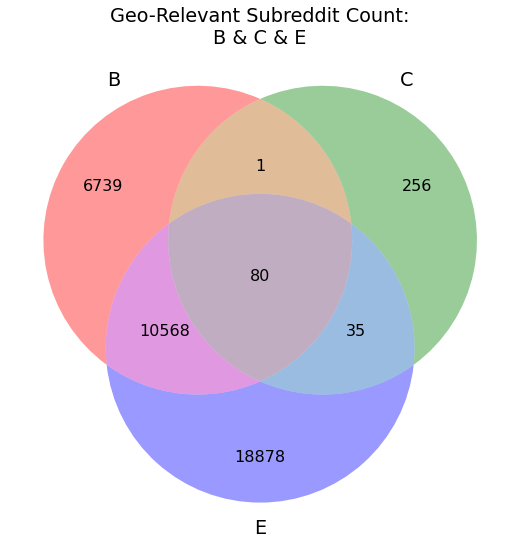

In [265]:
plt.figure(figsize=(11, 9))

lbls_ = ['B', 'C', 'E']

s_subs_b = (
    df_geo_new[mask_thresh_b]['subreddit_name'] + '-' +
    df_geo_new[mask_thresh_b]['country_name'] 
)
s_subs_c = (
    df_geo_new[mask_thresh_c]['subreddit_name'] + '-' +
    df_geo_new[mask_thresh_c]['country_name'] 
)
s_subs_e = (
    df_geo_new[mask_thresh_e]['subreddit_name'] + '-' +
    df_geo_new[mask_thresh_e]['country_name'] 
)

d_sets_bce = get_venn_sets3(
    s_subs_b, s_subs_c, s_subs_e, 
    *lbls_
)

ax = venn3_unweighted(
    [
        set(s_subs_b), 
        set(s_subs_c),
        set(s_subs_e)
    ],
    set_labels=lbls_,
)
plt.title(f"Geo-Relevant Subreddit Count:\n{' & '.join(lbls_)}");

### what are the combinations we miss by removing C?

Looks like it's mostly subreddits that are popular all over the word, so we're not necesarily removing something that is culturally relevant - just popular on all of reddit.

In [266]:
list(d_sets_bce['C_only'])[:20]

['mademesmile-Australia',
 'unexpected-Switzerland',
 'programmerhumor-Austria',
 'nextfuckinglevel-Austria',
 'unexpected-Canada',
 'europe-Austria',
 'publicfreakout-Austria',
 'askmen-India',
 'nostupidquestions-United Kingdom',
 'facepalm-Germany',
 'funny-Canada',
 'funny-Austria',
 'facepalm-Australia',
 'cringetopia-Portugal',
 'memes-Italy',
 'interestingasfuck-Italy',
 'oddlyterrifying-Austria',
 'pics-Austria',
 'tinder-France',
 'trueoffmychest-Switzerland']

In [267]:
list(d_sets_bce['C_only'])[-20:]

['mademesmile-Switzerland',
 'askmen-Australia',
 'dankmemes-Germany',
 'pics-Germany',
 'gaming-Spain',
 'unexpected-Portugal',
 'funny-United Kingdom',
 'mademesmile-Canada',
 'tifu-Portugal',
 'unexpected-Australia',
 'movies-Portugal',
 'unexpected-India',
 'europe-Portugal',
 'movies-Austria',
 'antiwork-Austria',
 'cringetopia-Switzerland',
 'antiwork-Switzerland',
 'holup-United Kingdom',
 'antiwork-France',
 'dankmemes-Austria']

In [268]:
list(d_sets_bce['B_only'])[-20:]

['pornwithfood-United Kingdom',
 'kalinatesa-Canada',
 'ps4clans-United Kingdom',
 'jennyreis-Brazil',
 'datasciencebr-Brazil',
 'kinkxo-Germany',
 'womensoccerlegs-United Kingdom',
 'carlafrigo-Germany',
 'southasianmenslib-Canada',
 'aslichutyapa-India',
 'quebec_amateur_porn-Canada',
 'haileyrhino-United Kingdom',
 'exams-India',
 'zimmerpflanzen-Germany',
 'hcradvocacy-United Kingdom',
 'mrstightsfans-United Kingdom',
 'womenshiq-United Kingdom',
 'professional_mark_10-United Kingdom',
 'heterosexual_posting-Mexico',
 'fuerteventura-United Kingdom']

In [269]:
list(d_sets_bce['E_only'])[-20:]

['bedbros-Canada',
 'nytspellingbee-Canada',
 'gymnastics-Australia',
 'leggingsnextdoor-Austria',
 'trademega-United Kingdom',
 'reduction-Canada',
 'unshavenfemales-Austria',
 'blowjobhandlebars-Germany',
 'beardsgonecuddly-Switzerland',
 'submissivesissies-Switzerland',
 'stainedglass-Canada',
 'picard-United Kingdom',
 'onlyfansgals101-Mexico',
 'terrastation-Italy',
 'operatingsystems-India',
 'thriftstorehauls-Canada',
 'aws-India',
 'tiktoknudes_dc-Austria',
 'ohdaddy-India',
 'brooklynginleyonlyfan-Mexico']

## Compare A, B & E

how many more do we add by including C & E on top of A?

By combining C & E + A, we get an additional 38,288 "geo-cultural" pairs that the baseline metric (A) didn't cover.

These 3 metrics are also complementary -- we can see that each of them contributes over 2,000 pairs not covered by the others.

In [270]:
51630 - 13342

38288

13,363 <- A
17,388 <- B
29,561 <- E
---
40,884 <- A OR B OR E

22,111 <- A OR B
35,624 <- A OR E
36,301 <- B OR E


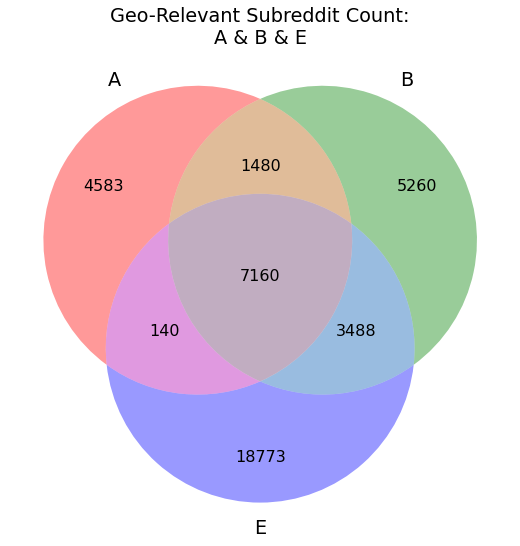

In [271]:
plt.figure(figsize=(10, 9))

lbls_ = ['A', 'B', 'E']

s_subs_a = (
    df_geo_baseline['subreddit_name'] + '-' +
    df_geo_baseline['country_name'] 
)

d_sets_abe = get_venn_sets3(
    s_subs_a, s_subs_b, s_subs_e, 
    *lbls_
)

ax = venn3_unweighted(
    [
        set(s_subs_a), 
        set(s_subs_b),
        set(s_subs_e),
    ],
    set_labels=lbls_,
)
plt.title(f"Geo-Relevant Subreddit Count:\n{' & '.join(lbls_)}");

## Get counts per country

TODO: merge baseline & new threshold DFs
    - add a column (columns?) to identify which subs were covered by A (baseline) v. C & E
    
Get value counts to see increase per country

later: check rating-short / over_18 flag to identify how many are SFW or unrated.

In [272]:
print(threshold_b_sub)
print(threshold_e_country_standardized)

0.14
2.0


In [273]:
df_geo_new_thresholds = (
    df_geo_new[
        mask_thresh_b | mask_thresh_e
    ]
    .copy()
)

df_geo_new_thresholds.shape

(36301, 19)

In [274]:
# df_geo_baseline.head()

In [275]:
# df_geo_new_thresholds.head()

In [276]:
# We need to do an extra join to get data for subreddits that match A, 
#  but not the new metrics

In [277]:
l_cols_ix_merge_final_geo = [
    'geo_country_code',
    'subreddit_id', 
    'subreddit_name', 
    'country_name', 
]
l_cols_new_metrics_out = l_cols_ix_merge_final_geo + [
    'b_users_percent_by_subreddit',
    'e_users_percent_by_country_standardized',
    'c_users_percent_by_country',
    'd_users_percent_by_country_rank',
    'users_percent_by_country_avg',
    'num_of_countries_with_visits_l28',
    'users_in_subreddit_from_country_l28',
    'total_users_in_subreddit_l28',
    'total_users_in_country_l28',
]
col_geo_relevant_output = 'a_geo_relevance_default'

df_geo_base_with_new_metrics = (
    df_geo_baseline[l_cols_ix_merge_final_geo]
    .assign(**{col_geo_relevant_output: True})
    .merge(
        df_geo_new[l_cols_new_metrics_out],
        how='left',
        on=l_cols_ix_merge_final_geo,
    )
)
print(df_geo_base_with_new_metrics.shape)

df_geo_final_output = (
    df_geo_base_with_new_metrics
    .merge(
        df_geo_new_thresholds[l_cols_new_metrics_out],
        how='outer',
        on=l_cols_new_metrics_out,
    )
    .merge(
        df_candidate_subreddits[['subreddit_id', 'users_l7', 'posts_not_removed_l28']],
        how='left',
        on=['subreddit_id'],
    )
    .fillna({col_geo_relevant_output: False})
    .sort_values(by=['country_name', 'users_l7'], ascending=[True, False])
)
df_geo_final_output.shape

(13363, 14)


(40884, 16)

In [278]:
# df_candidate_subreddits.head()

In [279]:
counts_describe(df_geo_final_output)

,dtype,count,unique,unique-percent,null-count,null-percent
geo_country_code,object,"40,884",15,0.04%,0,0.00%
subreddit_id,object,"40,884","34,255",83.79%,0,0.00%
subreddit_name,object,"40,884","34,255",83.79%,0,0.00%
country_name,object,"40,884",15,0.04%,0,0.00%
a_geo_relevance_default,bool,"40,884",2,0.00%,0,0.00%
b_users_percent_by_subreddit,float64,"37,347","35,586",95.28%,"3,537",8.65%
e_users_percent_by_country_standardized,float64,"37,347","37,133",99.43%,"3,537",8.65%
c_users_percent_by_country,float64,"37,347","22,691",60.76%,"3,537",8.65%
d_users_percent_by_country_rank,float64,"37,347","26,011",69.65%,"3,537",8.65%
users_percent_by_country_avg,float64,"37,347","31,367",83.99%,"3,537",8.65%


## Check country counts

Note: many of the subreddits in A, but not in B or E are there because for B & E I was excluding subreddits that have `over_18 = True`.

In [280]:
print(df_geo_baseline['country_name'].nunique())
value_counts_and_pcts(
    df_geo_baseline,
    ['country_name']
)

15


,count,percent,cumulative_percent
country_name,,,
United Kingdom,"2,734",20.5%,20.5%
Germany,"2,242",16.8%,37.2%
Canada,"1,741",13.0%,50.3%
India,"1,741",13.0%,63.3%
Mexico,"1,336",10.0%,73.3%
Brazil,963,7.2%,80.5%
Australia,797,6.0%,86.5%
France,603,4.5%,91.0%
Italy,324,2.4%,93.4%


In [281]:
# print(df_geo_new_thresholds['country_name'].nunique())
# value_counts_and_pcts(
#     df_geo_new_thresholds,
#     ['country_name']
# )

In [282]:
print(df_geo_final_output['country_name'].nunique())
value_counts_and_pcts(
    df_geo_final_output,
    ['country_name']
)

15


,count,percent,cumulative_percent
country_name,,,
United Kingdom,"8,422",20.6%,20.6%
Canada,"5,210",12.7%,33.3%
Germany,"5,144",12.6%,45.9%
India,"4,206",10.3%,56.2%
Mexico,"3,776",9.2%,65.4%
Australia,"2,557",6.3%,71.7%
Austria,"2,348",5.7%,77.4%
Brazil,"1,608",3.9%,81.4%
Switzerland,"1,402",3.4%,84.8%


In [283]:
print(df_geo_final_output['country_name'].nunique())
value_counts_and_pcts(
    df_geo_final_output,
    ['country_name', col_geo_relevant_output],
    sort_index=True,
    cumsum=False,
    top_n=None,
    count_type='subreddits',
    
)

15


In [284]:
df_subs_per_country = value_counts_and_pcts(
    df_geo_final_output,
    ['country_name', col_geo_relevant_output],
    sort_index=True,
    cumsum=False,
    top_n=None,
    count_type='subreddits',
    reset_index=True,
    return_df=True,
).drop(['percent_of_subreddits'], axis=1)
df_subs_per_country.shape

(30, 3)

### The median gain is 1,034 subreddits per country
The range is between 338 and 4,887 subreddits.


In [285]:
(
    df_subs_per_country[df_subs_per_country['a_geo_relevance_default'] == False]
    ['subreddits_count'].describe()
)

count      15.000000
mean     1834.733333
std      1427.262238
min       390.000000
25%       783.500000
50%      1306.000000
75%      2452.500000
max      5688.000000
Name: subreddits_count, dtype: float64

In [286]:
(
    df_subs_per_country[df_subs_per_country['a_geo_relevance_default'] == False]
    ['subreddits_count'].sum()
)

27521

## Check metrics per country

If we need to adjust the thresholds, this is a good place to star

In [287]:
col_ = 'b_users_percent_by_subreddit'
print(col_)
style_df_numeric(
    df_geo_final_output.groupby(['country_name'])
    [col_].describe()
    ,
    float_round=2,
    pct_cols=['mean', 'min', 'max'],
    pct_labels=['%'],
    pct_digits=2,
    l_bar_simple=[
        'mean', '50%',
    ],
)

b_users_percent_by_subreddit


,count,mean,std,min,25%,50%,75%,max
country_name,,,,,,,,
Argentina,574,26.61%,0.28,0.54%,2.29%,13.29%,52.38%,91.78%
Australia,"2,353",22.74%,0.28,0.61%,4.48%,6.81%,29.72%,96.96%
Austria,"2,314",3.45%,0.09,0.40%,0.92%,1.31%,2.81%,95.13%
Brazil,"1,369",51.36%,0.34,0.88%,15.07%,58.36%,85.47%,98.89%
Canada,"4,747",26.16%,0.28,1.29%,8.42%,11.25%,29.61%,99.06%
Chile,"1,170",5.75%,0.15,0.43%,1.01%,1.49%,2.58%,98.30%
France,"1,132",33.67%,0.32,0.69%,5.42%,16.35%,69.91%,97.55%
Germany,"4,573",34.28%,0.32,0.94%,8.26%,15.33%,71.51%,99.24%
India,"3,854",32.77%,0.28,0.84%,8.04%,18.55%,60.62%,98.19%


In [288]:
col_ = 'e_users_percent_by_country_standardized'
print(col_)
style_df_numeric(
    df_geo_final_output.groupby(['country_name'])
    [col_].describe()
    ,
    float_round=2,
    # pct_cols=['mean', 'min', 'max'],
    # pct_labels=['%'],
    pct_digits=2,
    l_bar_simple=[
        'mean', '50%',
    ],
)

e_users_percent_by_country_standardized


,count,mean,std,min,25%,50%,75%,max
country_name,,,,,,,,
Argentina,574,3.45,1.61,-0.35,2.28,2.95,4.34,10.28
Australia,"2,353",2.86,1.70,-1.01,2.09,2.39,3.17,10.78
Austria,"2,314",2.69,0.86,-0.53,2.18,2.45,2.89,10.61
Brazil,"1,369",3.55,2.40,-1.47,2.02,2.99,4.98,10.65
Canada,"4,747",2.63,1.71,-1.29,2.00,2.38,3.14,10.78
Chile,"1,170",2.91,1.11,-0.27,2.24,2.56,3.15,10.52
France,"1,132",2.97,1.49,-1.11,2.13,2.63,3.64,10.47
Germany,"4,573",2.76,1.56,-1.58,2.05,2.47,3.39,10.37
India,"3,854",2.95,1.68,-1.37,2.08,2.61,3.60,10.64


### Individual country lists

In [289]:
col_a_display = 'a geo relevance default'
col_b_display = 'b users percent by subreddit'
col_e_display = 'e users percent by country standardized'

def color_boolean(val):
    if val == True:
        return "background-color: #01B500; font-weight: bold;"  # green
    else:
        return ''

def highlight_b(val):
    if val >= threshold_b_sub:
        return "color:red; font-weight: bold;"  # green
    else:
        return ''
    
def highlight_e(val):
    if val >= threshold_e_country_standardized:
        return "color:red; font-weight: bold;"  # green
    else:
        return ''

In [291]:
country_ = 'Argentina'
display(
    style_df_numeric(
        df_geo_final_output
        [df_geo_final_output['country_name'] == country_]
        .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        .iloc[:30, :]
        ,
        rename_cols_for_display=True,
        # int_cols=False,
        int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                    'by_country_rank',
                    ],
        pct_digits=2,
        pct_cols=['b_users_percent_by_subreddit',
                  'c_users_percent_by_country',
                  'users_percent_by_country_avg',
                  ],
        pct_labels='',
        l_bar_simple=['b_users_percent_by_subreddit',
                      'c_users_percent_by_country',
                      'e_users_percent_by_country_standardized',
                      ],
    )
    .applymap(color_boolean, subset=[col_a_display])
    .applymap(highlight_b, subset=[col_b_display])
    .applymap(highlight_e, subset=[col_e_display])
    .hide_index()
)
display(  # only subs that are missing in metric A
    style_df_numeric(
        df_geo_final_output
        [(df_geo_final_output['country_name'] == country_) &
         (df_geo_final_output[col_a_display.replace(' ', '_')] == False)
         ]
        .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        .iloc[60:80, :]
        ,
        rename_cols_for_display=True,
        # int_cols=False,
        int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                    'by_country_rank',
                    ],
        pct_digits=2,
        pct_cols=['b_users_percent_by_subreddit',
                  'c_users_percent_by_country',
                  'users_percent_by_country_avg',
                  ],
        pct_labels='',
        l_bar_simple=['b_users_percent_by_subreddit',
                      'c_users_percent_by_country',
                      'e_users_percent_by_country_standardized',
                      ],
    )
    .applymap(color_boolean, subset=[col_a_display])
    .applymap(highlight_b, subset=[col_b_display])
    .applymap(highlight_e, subset=[col_e_display])
    .hide_index()
)
(
    style_df_numeric(
        df_geo_final_output
        [df_geo_final_output['country_name'] == country_]
        .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        .iloc[-30:, :]
        ,
        rename_cols_for_display=True,
        # int_cols=False,
        int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                    'by_country_rank',
                    ],
        pct_digits=2,
        pct_cols=['b_users_percent_by_subreddit',
                  'c_users_percent_by_country',
                  'users_percent_by_country_avg',
                  ],
        pct_labels='',
        l_bar_simple=['b_users_percent_by_subreddit',
                      'c_users_percent_by_country',
                      'e_users_percent_by_country_standardized',
                      ],
    )
    .applymap(color_boolean, subset=[col_a_display])
    .applymap(highlight_b, subset=[col_b_display])
    .applymap(highlight_e, subset=[col_e_display])
    .hide_index()
)

subreddit name,country name,a geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in subreddit l28,users l7,posts not removed l28
projectzomboid,Argentina,False,1.40%,2.13,0.32%,107,0.11%,119,"11,861","844,679","214,880.00","5,985.00"
argentina,Argentina,True,62.16%,10.28,9.21%,1,0.15%,116,"343,559","552,670","154,681.00","3,474.00"
bindingofisaac,Argentina,False,1.21%,2.12,0.15%,317,0.06%,117,"5,606","462,492","148,664.00","4,887.00"
celebsarg,Argentina,True,59.08%,9.25,6.28%,2,0.14%,115,"234,259","396,544","123,537.00",404.00
aoe2,Argentina,False,1.59%,2.64,0.09%,504,0.03%,117,"3,507","221,122","74,959.00","1,002.00"
pajasgrupalesymorbose,Argentina,False,7.63%,2.59,0.42%,63,0.06%,116,"15,512","203,326","70,790.00","23,685.00"
sexworkers,Argentina,False,0.54%,2.12,0.04%,"1,502",0.02%,118,"1,393","257,067","67,017.00",547.00
copypasta_es,Argentina,False,12.79%,2.31,0.68%,24,0.11%,95,"25,215","197,077","60,612.00",533.00
redhotchilipeppers,Argentina,False,2.35%,3.96,0.12%,401,0.03%,116,"4,413","188,111","58,928.00","1,593.00"
argaming,Argentina,True,69.16%,8.69,2.75%,3,0.07%,82,"102,530","148,250","46,216.00",587.00


subreddit name,country name,a geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in subreddit l28,users l7,posts not removed l28
talitachef,Argentina,False,33.32%,6.53,0.14%,345,0.01%,70,"5,196","15,593","5,346.00",19.00
ascii_archive,Argentina,False,1.64%,2.49,0.01%,"5,362",0.00%,100,337,"20,523","5,268.00",14.00
heidypino2021,Argentina,False,2.84%,3.24,0.01%,"4,261",0.00%,88,450,"15,856","5,189.00",24.00
shunli_mei_free,Argentina,False,25.88%,5.08,0.16%,292,0.01%,74,"5,971","23,073","5,157.00",68.00
deadrising,Argentina,False,0.91%,2.42,0.00%,"8,547",0.00%,88,185,"20,263","5,091.00",240.00
painttoolsai,Argentina,False,2.10%,2.09,0.01%,"4,420",0.00%,106,431,"20,525","5,090.00",77.00
sashadamorexxx,Argentina,False,16.69%,4.76,0.07%,727,0.01%,72,"2,647","15,857","5,080.00",26.00
windowbeauty,Argentina,False,2.07%,4.39,0.01%,"4,250",0.00%,103,451,"21,760","5,066.00",73.00
clanestinoxr,Argentina,False,3.25%,6.09,0.02%,"2,484",0.00%,97,837,"25,790","5,062.00",35.00
nr2003,Argentina,False,1.68%,3.91,0.01%,"7,483",0.00%,73,221,"13,174","4,982.00",354.00


subreddit name,country name,a geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in subreddit l28,users l7,posts not removed l28
hysteria51,Argentina,False,9.34%,2.04,0.00%,"35,646",0.00%,6,17,182,45.00,6.00
duki,Argentina,False,32.23%,2.32,0.00%,"16,797",0.00%,11,68,211,42.00,9.00
potatofarmersonly,Argentina,False,2.48%,2.17,0.00%,"60,852",0.00%,10,4,161,41.00,5.00
spidermancomic,Argentina,False,2.53%,2.35,0.00%,"54,309",0.00%,8,6,237,40.00,2.00
robot64,Argentina,False,2.21%,2.18,0.00%,"62,179",0.00%,10,4,181,40.00,7.00
pythonespanol,Argentina,False,22.45%,1.87,0.00%,"21,749",0.00%,8,44,196,35.00,7.00
astronomiaarg,Argentina,False,33.33%,1.87,0.00%,"21,140",0.00%,8,46,138,35.00,1.00
palosalvatore,Argentina,False,76.18%,2.04,0.01%,"6,671",0.00%,6,259,340,28.00,1.00
mardelplataciudad,Argentina,False,79.23%,1.50,0.00%,"9,390",0.00%,4,164,207,27.00,6.00
williamzabka,Argentina,False,1.53%,2.20,0.00%,"61,965",0.00%,10,4,262,26.00,2.00


### Germany

In [244]:
country_ = 'Germany'
display(
    style_df_numeric(
        df_geo_final_output
        [df_geo_final_output['country_name'] == country_]
        .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        .iloc[:30, :]
        ,
        rename_cols_for_display=True,
        # int_cols=False,
        int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                    'by_country_rank',
                    ],
        pct_digits=2,
        pct_cols=['b_users_percent_by_subreddit',
                  'c_users_percent_by_country',
                  'users_percent_by_country_avg',
                  ],
        pct_labels='',
        l_bar_simple=['b_users_percent_by_subreddit',
                      'c_users_percent_by_country',
                      'e_users_percent_by_country_standardized',
                      ],
    )
    .applymap(color_boolean, subset=[col_a_display])
    .applymap(highlight_b, subset=[col_b_display])
    .applymap(highlight_e, subset=[col_e_display])
    .hide_index()
)
(
    style_df_numeric(
        df_geo_final_output
        [df_geo_final_output['country_name'] == country_]
        .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        .iloc[-30:, :]
        ,
        rename_cols_for_display=True,
        # int_cols=False,
        int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                    'by_country_rank',
                    ],
        pct_digits=2,
        pct_cols=['b_users_percent_by_subreddit',
                  'c_users_percent_by_country',
                  'users_percent_by_country_avg',
                  ],
        pct_labels='',
        l_bar_simple=['b_users_percent_by_subreddit',
                      'c_users_percent_by_country',
                      'e_users_percent_by_country_standardized',
                      ],
    )
    .applymap(color_boolean, subset=[col_a_display])
    .applymap(highlight_b, subset=[col_b_display])
    .applymap(highlight_e, subset=[col_e_display])
    .hide_index()
)

subreddit name,country name,a geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in subreddit l28,users l7,posts not removed l28
cumsluts,Germany,False,5.76%,2.72,0.93%,49,0.44%,119,"226,408","3,933,414","1,246,628.00","6,056.00"
realgirls,Germany,False,5.37%,2.42,0.88%,53,0.45%,119,"213,336","3,969,710","1,240,710.00","4,265.00"
blowjobs,Germany,False,5.68%,2.54,0.52%,126,0.25%,119,"125,189","2,203,371","668,831.00","3,365.00"
de,Germany,True,69.25%,9.97,4.81%,1,0.13%,119,"1,167,549","1,685,887","526,336.00","2,204.00"
snapchatsext_,Germany,False,9.35%,3.94,0.58%,105,0.17%,119,"140,398","1,502,130","444,333.00","144,226.00"
cumfetish,Germany,False,5.84%,2.72,0.35%,235,0.16%,119,"84,376","1,444,030","394,786.00","4,092.00"
ich_iel,Germany,True,63.36%,10.20,3.19%,3,0.09%,119,"773,323","1,220,530","391,753.00","6,201.00"
couplesgonewild,Germany,False,5.63%,2.59,0.28%,293,0.12%,119,"68,502","1,217,152","378,629.00","4,089.00"
sexinfrontofothers,Germany,False,7.07%,2.33,0.38%,198,0.17%,119,"93,120","1,316,869","362,354.00",135.00
publicflashing,Germany,False,5.56%,2.39,0.27%,310,0.13%,119,"65,720","1,182,080","335,557.00","1,920.00"


subreddit name,country name,a geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in subreddit l28,users l7,posts not removed l28
amateurgirlsex,Germany,False,13.14%,2.75,0.00%,"50,993",0.00%,24,90,685,-,-
addisonnraee,Germany,False,19.34%,1.86,0.00%,"47,828",0.00%,15,106,548,-,-
biancaj,Germany,False,16.46%,0.86,0.00%,"31,668",0.00%,35,271,"1,646",-,-
goubara,Germany,False,14.32%,0.70,0.00%,"58,654",0.00%,13,61,426,-,-
russkaja_janaa,Germany,False,93.15%,0.71,0.00%,"36,206",0.00%,2,204,219,-,-
bdsmvienna,Germany,False,17.63%,-0.33,0.00%,"61,899",0.00%,7,52,295,-,-
nsfwandnudes,Germany,False,21.37%,-0.03,0.00%,"53,141",0.00%,17,81,379,-,-
laura_sanguinar,Germany,False,15.99%,1.43,0.00%,"60,699",0.00%,18,55,344,-,-
getragenes,Germany,False,70.89%,1.06,0.00%,"39,520",0.00%,3,168,237,-,-
assembly,Germany,False,14.04%,1.01,0.00%,"62,722",0.00%,21,50,356,-,-


### France

In [292]:
country_ = 'France'
display(
    style_df_numeric(
        df_geo_final_output
        [df_geo_final_output['country_name'] == country_]
        .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        .iloc[:30, :]
        ,
        rename_cols_for_display=True,
        # int_cols=False,
        int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                    'by_country_rank',
                    ],
        pct_digits=2,
        pct_cols=['b_users_percent_by_subreddit',
                  'c_users_percent_by_country',
                  'users_percent_by_country_avg',
                  ],
        pct_labels='',
        l_bar_simple=['b_users_percent_by_subreddit',
                      'c_users_percent_by_country',
                      'e_users_percent_by_country_standardized',
                      ],
    )
    .applymap(color_boolean, subset=[col_a_display])
    .applymap(highlight_b, subset=[col_b_display])
    .applymap(highlight_e, subset=[col_e_display])
    .hide_index()
)
display(  # only subs that are missing in metric A
    style_df_numeric(
        df_geo_final_output
        [(df_geo_final_output['country_name'] == country_) &
         (df_geo_final_output[col_a_display.replace(' ', '_')] == False)
         ]
        .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        .iloc[60:80, :]
        ,
        rename_cols_for_display=True,
        # int_cols=False,
        int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                    'by_country_rank',
                    ],
        pct_digits=2,
        pct_cols=['b_users_percent_by_subreddit',
                  'c_users_percent_by_country',
                  'users_percent_by_country_avg',
                  ],
        pct_labels='',
        l_bar_simple=['b_users_percent_by_subreddit',
                      'c_users_percent_by_country',
                      'e_users_percent_by_country_standardized',
                      ],
    )
    .applymap(color_boolean, subset=[col_a_display])
    .applymap(highlight_b, subset=[col_b_display])
    .applymap(highlight_e, subset=[col_e_display])
    .hide_index()
)
(
    style_df_numeric(
        df_geo_final_output
        [df_geo_final_output['country_name'] == country_]
        .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        .iloc[-20:, :]
        ,
        rename_cols_for_display=True,
        # int_cols=False,
        int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                    'by_country_rank',
                    ],
        pct_digits=2,
        pct_cols=['b_users_percent_by_subreddit',
                  'c_users_percent_by_country',
                  'users_percent_by_country_avg',
                  ],
        pct_labels='',
        l_bar_simple=['b_users_percent_by_subreddit',
                      'c_users_percent_by_country',
                      'e_users_percent_by_country_standardized',
                      ],
    )
    .applymap(color_boolean, subset=[col_a_display])
    .applymap(highlight_b, subset=[col_b_display])
    .applymap(highlight_e, subset=[col_e_display])
    .hide_index()
)

subreddit name,country name,a geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in subreddit l28,users l7,posts not removed l28
idiotsincars,France,False,2.37%,2.00,1.18%,13,0.54%,119,"127,810","5,400,315","1,806,988.00","3,039.00"
france,France,True,68.31%,10.03,5.29%,1,0.11%,119,"572,663","838,274","281,695.00","4,650.00"
starcitizen,France,False,3.99%,3.44,0.18%,314,0.05%,119,"19,828","496,414","169,072.00","4,936.00"
bindingofisaac,France,False,4.54%,3.12,0.19%,293,0.06%,117,"20,998","462,492","148,664.00","4,887.00"
vampiresurvivors,France,False,7.31%,4.81,0.19%,294,0.03%,116,"20,971","286,848","129,374.00","1,978.00"
dbzdokkanbattle,France,False,4.35%,2.85,0.14%,414,0.04%,116,"15,489","356,055","118,482.00","3,630.00"
rance,France,True,72.07%,10.47,2.16%,3,0.04%,116,"234,309","325,095","108,870.00","1,228.00"
shitamericanssay,France,False,4.62%,2.54,0.11%,607,0.03%,119,"11,624","251,421","108,792.00",430.00
quebec,France,False,4.64%,2.06,0.15%,400,0.02%,112,"16,073","346,372","103,891.00","3,202.00"
satisfactorygame,France,False,4.46%,3.13,0.12%,505,0.03%,117,"13,282","297,715","97,886.00","2,301.00"


subreddit name,country name,a geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in subreddit l28,users l7,posts not removed l28
leaeluig,France,False,16.27%,4.42,0.07%,950,0.01%,107,"8,055","49,499","17,221.00",391.00
acqr,France,False,3.70%,3.15,0.02%,"3,100",0.01%,91,"2,488","67,263","14,844.00",40.00
leolulu,France,False,4.39%,2.49,0.02%,"2,887",0.01%,113,"2,679","61,086","14,805.00",37.00
tezos,France,False,4.16%,2.07,0.02%,"3,583",0.01%,116,"2,096","50,419","14,606.00",523.00
learnfrench,France,False,5.83%,3.38,0.03%,"2,836",0.01%,115,"2,740","46,963","14,594.00",276.00
bloodbowl,France,False,4.01%,2.12,0.02%,"4,188",0.01%,85,"1,745","43,493","14,485.00",410.00
shadowpc,France,False,8.89%,7.27,0.04%,"1,677",0.01%,110,"4,790","53,886","14,419.00",261.00
dungeondraft,France,False,3.57%,3.00,0.02%,"4,103",0.01%,93,"1,786","49,971","14,253.00",341.00
satisfactory,France,False,4.81%,3.19,0.02%,"3,014",0.01%,97,"2,552","53,056","13,729.00",194.00
dressuptimeprincess,France,False,5.53%,2.64,0.02%,"3,311",0.01%,113,"2,297","41,515","13,660.00",901.00


subreddit name,country name,a geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in subreddit l28,users l7,posts not removed l28
leaksfr,France,False,74.02%,2.79,0.01%,"7,301",0.00%,13,889,"1,201",-,-
chatterbate,France,False,26.48%,1.93,0.00%,"14,813",0.00%,28,331,"1,250",-,-
raf2,France,False,34.76%,2.93,0.00%,"12,275",0.00%,29,439,"1,263",-,-
dupontdeligonnes,France,False,7.48%,4.06,0.00%,"34,871",0.00%,35,73,976,-,-
gabriellemarie,France,False,47.77%,1.83,0.00%,"13,137",0.00%,17,396,829,-,-
dropboobs,France,False,15.26%,2.63,0.00%,"27,509",0.00%,27,116,760,-,-
random_nude,France,False,9.50%,2.58,0.00%,"47,451",0.00%,10,36,379,-,-
french_nudes,France,False,67.01%,2.01,0.00%,"10,825",0.00%,11,522,779,-,-
alizee_yt,France,False,48.83%,4.12,0.00%,"16,007",0.00%,20,293,600,-,-
drole,France,False,77.13%,0.97,0.00%,"13,710",0.00%,8,371,481,-,-


### Australia

In [246]:
country_ = 'Australia'
display(
    style_df_numeric(
        df_geo_final_output
        [df_geo_final_output['country_name'] == country_]
        .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        .iloc[:30, :]
        ,
        rename_cols_for_display=True,
        # int_cols=False,
        int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                    'by_country_rank',
                    ],
        pct_digits=2,
        pct_cols=['b_users_percent_by_subreddit',
                  'c_users_percent_by_country',
                  'users_percent_by_country_avg',
                  ],
        pct_labels='',
        l_bar_simple=['b_users_percent_by_subreddit',
                      'c_users_percent_by_country',
                      'e_users_percent_by_country_standardized',
                      ],
    )
    .applymap(color_boolean, subset=[col_a_display])
    .applymap(highlight_b, subset=[col_b_display])
    .applymap(highlight_e, subset=[col_e_display])
    .hide_index()
)
display(  # only subs that are missing in metric A
    style_df_numeric(
        df_geo_final_output
        [(df_geo_final_output['country_name'] == country_) &
         (df_geo_final_output[col_a_display.replace(' ', '_')] == False)
         ]
        .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        .iloc[60:80, :]
        ,
        rename_cols_for_display=True,
        # int_cols=False,
        int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                    'by_country_rank',
                    ],
        pct_digits=2,
        pct_cols=['b_users_percent_by_subreddit',
                  'c_users_percent_by_country',
                  'users_percent_by_country_avg',
                  ],
        pct_labels='',
        l_bar_simple=['b_users_percent_by_subreddit',
                      'c_users_percent_by_country',
                      'e_users_percent_by_country_standardized',
                      ],
    )
    .applymap(color_boolean, subset=[col_a_display])
    .applymap(highlight_b, subset=[col_b_display])
    .applymap(highlight_e, subset=[col_e_display])
    .hide_index()
)
(
    style_df_numeric(
        df_geo_final_output
        [df_geo_final_output['country_name'] == country_]
        .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        .iloc[-20:, :]
        ,
        rename_cols_for_display=True,
        # int_cols=False,
        int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                    'by_country_rank',
                    ],
        pct_digits=2,
        pct_cols=['b_users_percent_by_subreddit',
                  'c_users_percent_by_country',
                  'users_percent_by_country_avg',
                  ],
        pct_labels='',
        l_bar_simple=['b_users_percent_by_subreddit',
                      'c_users_percent_by_country',
                      'e_users_percent_by_country_standardized',
                      ],
    )
    .applymap(color_boolean, subset=[col_a_display])
    .applymap(highlight_b, subset=[col_b_display])
    .applymap(highlight_e, subset=[col_e_display])
    .hide_index()
)

subreddit name,country name,a geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in subreddit l28,users l7,posts not removed l28
twoxchromosomes,Australia,False,4.48%,2.45,1.11%,48,0.43%,119,"240,466","5,372,133","2,369,889.00","3,114.00"
amitheasshole,Australia,False,4.64%,2.80,1.17%,39,0.42%,119,"253,606","5,462,643","2,298,550.00","1,128.00"
bestofredditorupdates,Australia,False,5.25%,3.08,0.73%,86,0.21%,119,"158,411","3,016,444","1,368,877.00",309.00
maliciouscompliance,Australia,False,5.09%,2.93,0.69%,96,0.21%,119,"149,043","2,930,665","1,159,758.00",213.00
australia,Australia,True,41.44%,10.46,4.69%,2,0.19%,119,"1,013,613","2,445,727","1,000,529.00","3,130.00"
halo,Australia,False,4.16%,2.69,0.64%,106,0.24%,119,"137,756","3,307,560","972,994.00","18,386.00"
cooking,Australia,False,4.04%,2.81,0.48%,172,0.16%,119,"103,413","2,559,106","799,470.00","4,343.00"
choosingbeggars,Australia,False,5.46%,3.19,0.73%,83,0.22%,119,"158,711","2,906,990","771,544.00",611.00
futurama,Australia,False,4.18%,2.63,0.14%,622,0.05%,119,"30,922","739,538","563,659.00","1,211.00"
pettyrevenge,Australia,False,5.10%,3.00,0.30%,283,0.09%,119,"64,864","1,271,856","561,765.00",234.00


subreddit name,country name,a geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in subreddit l28,users l7,posts not removed l28
aquariums,Australia,False,4.16%,2.36,0.09%,"1,073",0.03%,119,"18,910","454,710","147,720.00","11,445.00"
qanoncasualties,Australia,False,3.80%,2.49,0.09%,"1,055",0.03%,118,"19,223","506,318","145,564.00",380.00
dogtraining,Australia,False,4.05%,3.08,0.08%,"1,190",0.02%,118,"17,293","427,118","143,689.00","2,218.00"
weddingplanning,Australia,False,3.33%,3.01,0.07%,"1,333",0.02%,119,"15,319","460,450","141,631.00","2,958.00"
justnomil,Australia,False,4.92%,3.21,0.08%,"1,132",0.03%,119,"17,987","365,834","141,419.00",881.00
talesfromyourserver,Australia,False,3.87%,2.91,0.07%,"1,284",0.02%,119,"15,851","409,144","135,170.00",375.00
duggarssnark,Australia,False,3.03%,2.41,0.07%,"1,446",0.02%,117,"14,367","474,496","134,896.00",850.00
indieheads,Australia,False,3.95%,2.43,0.08%,"1,210",0.04%,119,"16,951","429,051","133,209.00","1,524.00"
fundiesnarkuncensored,Australia,False,3.85%,2.76,0.11%,871,0.03%,119,"22,849","592,919","130,098.00","1,137.00"
camping,Australia,False,2.96%,2.32,0.05%,"1,918",0.02%,119,"10,818","365,924","128,087.00",811.00


subreddit name,country name,a geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in subreddit l28,users l7,posts not removed l28
yissra,Australia,False,79.64%,5.52,0.07%,"1,407",0.00%,38,"14,682","18,436",-,-
daniesommers,Australia,False,29.72%,5.47,0.01%,"10,931",0.00%,43,"1,269","4,270",-,-
opinionsreviewsviews,Australia,False,4.75%,2.36,0.00%,"32,893",0.00%,49,204,"4,293",-,-
nakedly,Australia,False,27.51%,4.37,0.00%,"17,506",0.00%,29,620,"2,254",-,-
caitlinstasey,Australia,False,14.05%,4.15,0.00%,"26,805",0.00%,40,301,"2,143",-,-
lukeerwin,Australia,False,89.73%,1.42,0.00%,"12,829",0.00%,4,"1,005","1,120",-,-
makitaville,Australia,False,14.80%,1.97,0.00%,"31,975",0.00%,32,216,"1,459",-,-
missminoux,Australia,False,15.02%,-0.14,0.00%,"61,665",0.00%,8,44,293,-,-
drugsaustralia,Australia,False,64.71%,0.23,0.00%,"22,943",0.00%,9,396,612,-,-
auscann,Australia,False,85.37%,2.23,0.00%,"20,012",0.00%,7,496,581,-,-


In [247]:
country_ = 'United Kingdom'
display(
    style_df_numeric(
        df_geo_final_output
        [df_geo_final_output['country_name'] == country_]
        .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        .iloc[:30, :]
        ,
        rename_cols_for_display=True,
        # int_cols=False,
        int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                    'by_country_rank',
                    ],
        pct_digits=2,
        pct_cols=['b_users_percent_by_subreddit',
                  'c_users_percent_by_country',
                  'users_percent_by_country_avg',
                  ],
        pct_labels='',
        l_bar_simple=['b_users_percent_by_subreddit',
                      'c_users_percent_by_country',
                      'e_users_percent_by_country_standardized',
                      ],
    )
    .applymap(color_boolean, subset=[col_a_display])
    .applymap(highlight_b, subset=[col_b_display])
    .applymap(highlight_e, subset=[col_e_display])
    .hide_index()
)
display(  # only subs that are missing in metric A
    style_df_numeric(
        df_geo_final_output
        [(df_geo_final_output['country_name'] == country_) &
         (df_geo_final_output[col_a_display.replace(' ', '_')] == False)
         ]
        .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        .iloc[60:80, :]
        ,
        rename_cols_for_display=True,
        # int_cols=False,
        int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                    'by_country_rank',
                    ],
        pct_digits=2,
        pct_cols=['b_users_percent_by_subreddit',
                  'c_users_percent_by_country',
                  'users_percent_by_country_avg',
                  ],
        pct_labels='',
        l_bar_simple=['b_users_percent_by_subreddit',
                      'c_users_percent_by_country',
                      'e_users_percent_by_country_standardized',
                      ],
    )
    .applymap(color_boolean, subset=[col_a_display])
    .applymap(highlight_b, subset=[col_b_display])
    .applymap(highlight_e, subset=[col_e_display])
    .hide_index()
)
(
    style_df_numeric(
        df_geo_final_output
        [df_geo_final_output['country_name'] == country_]
        .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        .iloc[-20:, :]
        ,
        rename_cols_for_display=True,
        # int_cols=False,
        int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                    'by_country_rank',
                    ],
        pct_digits=2,
        pct_cols=['b_users_percent_by_subreddit',
                  'c_users_percent_by_country',
                  'users_percent_by_country_avg',
                  ],
        pct_labels='',
        l_bar_simple=['b_users_percent_by_subreddit',
                      'c_users_percent_by_country',
                      'e_users_percent_by_country_standardized',
                      ],
    )
    .applymap(color_boolean, subset=[col_a_display])
    .applymap(highlight_b, subset=[col_b_display])
    .applymap(highlight_e, subset=[col_e_display])
    .hide_index()
)

subreddit name,country name,a geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in subreddit l28,users l7,posts not removed l28
amitheasshole,United Kingdom,False,8.68%,2.47,1.08%,41,0.42%,119,"474,413","5,462,643","2,298,550.00","1,128.00"
starwars,United Kingdom,False,8.88%,2.46,0.96%,54,0.37%,119,"420,209","4,733,595","2,239,494.00","6,742.00"
marvelstudios,United Kingdom,False,9.21%,2.64,1.06%,46,0.46%,119,"464,643","5,046,713","1,799,994.00","5,089.00"
casualuk,United Kingdom,True,36.35%,9.07,3.59%,2,0.31%,119,"1,571,074","4,321,727","1,538,614.00","4,157.00"
bestofredditorupdates,United Kingdom,False,9.24%,2.52,0.64%,109,0.21%,119,"278,669","3,016,444","1,368,877.00",309.00
halo,United Kingdom,False,7.94%,2.43,0.60%,125,0.24%,119,"262,538","3,307,560","972,994.00","18,386.00"
soccer,United Kingdom,False,18.59%,1.75,1.06%,48,0.46%,119,"462,603","2,488,962","963,666.00","8,858.00"
cooking,United Kingdom,False,7.67%,2.54,0.45%,191,0.16%,119,"196,192","2,559,106","799,470.00","4,343.00"
askuk,United Kingdom,True,42.02%,9.60,3.01%,3,0.22%,119,"1,317,945","3,136,818","798,034.00","3,745.00"
moviedetails,United Kingdom,False,9.14%,2.60,0.49%,171,0.20%,119,"212,588","2,325,614","796,662.00",214.00


subreddit name,country name,a geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in subreddit l28,users l7,posts not removed l28
fo76,United Kingdom,False,8.77%,2.33,0.10%,"1,033",0.04%,117,"44,047","501,988","157,409.00","4,429.00"
starwarsbattlefront,United Kingdom,False,10.25%,2.60,0.19%,502,0.08%,119,"83,574","815,152","154,662.00","1,652.00"
pandr,United Kingdom,False,8.23%,2.49,0.11%,983,0.04%,119,"46,444","564,572","154,503.00",514.00
bisexual,United Kingdom,False,9.01%,2.54,0.12%,841,0.06%,119,"53,480","593,803","153,690.00","2,989.00"
40klore,United Kingdom,False,14.24%,3.01,0.15%,672,0.05%,119,"64,710","454,401","153,596.00","2,104.00"
community,United Kingdom,False,8.98%,2.56,0.09%,"1,206",0.04%,119,"37,931","422,454","150,437.00",66.00
emogirls,United Kingdom,False,9.04%,2.66,0.11%,938,0.04%,119,"48,491","536,114","147,405.00","3,706.00"
codzombies,United Kingdom,False,10.39%,2.58,0.12%,857,0.04%,118,"52,666","507,119","146,634.00","1,495.00"
footballmanagergames,United Kingdom,False,31.62%,3.24,0.30%,290,0.07%,119,"133,525","422,281","145,606.00","5,220.00"
pelotoncycle,United Kingdom,False,4.49%,2.40,0.05%,"2,173",0.01%,109,"21,378","475,801","144,857.00",665.00


subreddit name,country name,a geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in subreddit l28,users l7,posts not removed l28
redeals,United Kingdom,False,15.21%,0.01,0.00%,"86,835",0.00%,10,33,217,-,-
westendtheatrebabes,United Kingdom,False,41.15%,2.37,0.00%,"69,511",0.00%,8,79,192,-,-
curvygirlsxxl,United Kingdom,False,15.00%,1.22,0.00%,"90,531",0.00%,6,27,180,-,-
holidayporn,United Kingdom,False,25.00%,1.06,0.00%,"77,590",0.00%,8,53,212,-,-
ratesmallboobs,United Kingdom,False,15.69%,0.73,0.00%,"106,066",0.00%,3,8,51,-,-
coinmasterfreespins_,United Kingdom,False,16.28%,-0.11,0.00%,"94,352",0.00%,6,21,129,-,-
myselfporn,United Kingdom,False,66.41%,1.47,0.00%,"67,966",0.00%,4,85,128,-,-
pornforsissybabies,United Kingdom,False,15.69%,1.04,0.00%,"98,439",0.00%,4,16,102,-,-
sindyday,United Kingdom,False,15.02%,0.19,0.00%,"85,734",0.00%,10,35,233,-,-
camerondiazhot,United Kingdom,False,19.51%,1.10,0.00%,"87,113",0.00%,7,32,164,-,-


In [248]:
country_ = 'Canada'
display(
    style_df_numeric(
        df_geo_final_output
        [df_geo_final_output['country_name'] == country_]
        .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        .iloc[:30, :]
        ,
        rename_cols_for_display=True,
        # int_cols=False,
        int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                    'by_country_rank',
                    ],
        pct_digits=2,
        pct_cols=['b_users_percent_by_subreddit',
                  'c_users_percent_by_country',
                  'users_percent_by_country_avg',
                  ],
        pct_labels='',
        l_bar_simple=['b_users_percent_by_subreddit',
                      'c_users_percent_by_country',
                      'e_users_percent_by_country_standardized',
                      ],
    )
    .applymap(color_boolean, subset=[col_a_display])
    .applymap(highlight_b, subset=[col_b_display])
    .applymap(highlight_e, subset=[col_e_display])
    .hide_index()
)
display(  # only subs that are missing in metric A
    style_df_numeric(
        df_geo_final_output
        [(df_geo_final_output['country_name'] == country_) &
         (df_geo_final_output[col_a_display.replace(' ', '_')] == False)
         ]
        .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        .iloc[60:80, :]
        ,
        rename_cols_for_display=True,
        # int_cols=False,
        int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                    'by_country_rank',
                    ],
        pct_digits=2,
        pct_cols=['b_users_percent_by_subreddit',
                  'c_users_percent_by_country',
                  'users_percent_by_country_avg',
                  ],
        pct_labels='',
        l_bar_simple=['b_users_percent_by_subreddit',
                      'c_users_percent_by_country',
                      'e_users_percent_by_country_standardized',
                      ],
    )
    .applymap(color_boolean, subset=[col_a_display])
    .applymap(highlight_b, subset=[col_b_display])
    .applymap(highlight_e, subset=[col_e_display])
    .hide_index()
)
(
    style_df_numeric(
        df_geo_final_output
        [df_geo_final_output['country_name'] == country_]
        .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        .iloc[-20:, :]
        ,
        rename_cols_for_display=True,
        # int_cols=False,
        int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                    'by_country_rank',
                    ],
        pct_digits=2,
        pct_cols=['b_users_percent_by_subreddit',
                  'c_users_percent_by_country',
                  'users_percent_by_country_avg',
                  ],
        pct_labels='',
        l_bar_simple=['b_users_percent_by_subreddit',
                      'c_users_percent_by_country',
                      'e_users_percent_by_country_standardized',
                      ],
    )
    .applymap(color_boolean, subset=[col_a_display])
    .applymap(highlight_b, subset=[col_b_display])
    .applymap(highlight_e, subset=[col_e_display])
    .hide_index()
)

subreddit name,country name,a geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in subreddit l28,users l7,posts not removed l28
antiwork,Canada,False,8.75%,2.69,3.02%,4,1.18%,119,"1,254,915","14,336,938","5,968,187.00","30,843.00"
worldnews,Canada,False,10.05%,2.37,2.53%,6,1.07%,119,"1,051,650","10,468,680","4,670,856.00","6,465.00"
news,Canada,False,8.50%,3.00,2.30%,11,0.82%,119,"953,586","11,222,650","4,527,284.00","5,874.00"
politics,Canada,False,7.36%,2.60,1.28%,41,0.48%,119,"530,840","7,211,965","2,895,556.00","5,474.00"
publicfreakout,Canada,False,8.80%,2.43,1.66%,25,0.72%,119,"690,313","7,842,594","2,793,630.00","5,153.00"
twoxchromosomes,Canada,False,9.07%,2.67,1.17%,49,0.43%,119,"487,179","5,372,133","2,369,889.00","3,114.00"
amitheasshole,Canada,False,7.95%,2.33,1.05%,58,0.42%,119,"434,211","5,462,643","2,298,550.00","1,128.00"
nba,Canada,False,10.47%,2.96,1.22%,45,0.38%,119,"505,263","4,826,746","1,946,348.00","8,706.00"
entertainment,Canada,False,9.01%,3.08,0.80%,80,0.30%,119,"333,349","3,698,445","1,686,481.00","2,454.00"
sports,Canada,False,8.37%,2.55,0.89%,66,0.35%,119,"367,808","4,396,342","1,570,974.00",767.00


subreddit name,country name,a geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in subreddit l28,users l7,posts not removed l28
dogs,Canada,False,9.28%,4.38,0.22%,392,0.05%,119,"91,776","988,979","311,435.00","5,260.00"
doordash,Canada,False,5.24%,3.54,0.10%,918,0.02%,118,"42,134","803,370","310,087.00","3,322.00"
rupaulsdragrace,Canada,False,10.35%,2.88,0.22%,399,0.08%,119,"89,771","867,418","308,464.00","2,277.00"
askculinary,Canada,False,10.55%,3.81,0.29%,300,0.08%,119,"121,003","1,147,391","300,715.00",844.00
westsubever,Canada,False,8.93%,2.84,0.16%,570,0.06%,118,"64,975","727,804","298,440.00","3,096.00"
unresolvedmysteries,Canada,False,7.75%,2.34,0.18%,472,0.08%,119,"76,307","984,635","298,315.00",199.00
lifehacks,Canada,False,8.38%,2.38,0.26%,337,0.12%,119,"106,551","1,271,080","297,230.00",685.00
byebyejob,Canada,False,9.02%,3.13,0.40%,219,0.12%,119,"164,968","1,829,728","290,443.00",287.00
jobs,Canada,False,9.91%,3.80,0.22%,390,0.07%,119,"92,495","933,527","287,809.00","5,323.00"
buyitforlife,Canada,False,10.08%,4.73,0.23%,372,0.05%,119,"96,621","958,079","286,321.00",938.00


subreddit name,country name,a geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in subreddit l28,users l7,posts not removed l28
dibachiba,Canada,False,19.91%,-0.00,0.00%,"64,283",0.00%,7,84,422,-,-
2042uncensored,Canada,False,14.25%,0.59,0.00%,"74,948",0.00%,6,50,351,-,-
trueantivaccine,Canada,False,20.60%,0.25,0.00%,"79,188",0.00%,9,41,199,-,-
smallaccountchallenge,Canada,False,17.79%,0.47,0.00%,"86,182",0.00%,6,29,163,-,-
brewjays,Canada,False,47.63%,1.15,0.00%,"51,160",0.00%,3,161,338,-,-
orillianudes,Canada,False,61.20%,1.15,0.00%,"58,465",0.00%,3,112,183,-,-
nri_girls,Canada,False,20.77%,-0.12,0.00%,"71,411",0.00%,10,59,284,-,-
pokemongoottawa,Canada,False,49.65%,2.34,0.00%,"53,849",0.00%,8,141,284,-,-
dmgi,Canada,False,65.65%,0.83,0.00%,"52,467",0.00%,5,151,230,-,-
rabailhot,Canada,False,22.70%,-0.51,0.00%,"81,264",0.00%,7,37,163,-,-


In [249]:
country_ = 'India'
display(
    style_df_numeric(
        df_geo_final_output
        [df_geo_final_output['country_name'] == country_]
        .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        .iloc[:30, :]
        ,
        rename_cols_for_display=True,
        # int_cols=False,
        int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                    'by_country_rank',
                    ],
        pct_digits=2,
        pct_cols=['b_users_percent_by_subreddit',
                  'c_users_percent_by_country',
                  'users_percent_by_country_avg',
                  ],
        pct_labels='',
        l_bar_simple=['b_users_percent_by_subreddit',
                      'c_users_percent_by_country',
                      'e_users_percent_by_country_standardized',
                      ],
    )
    .applymap(color_boolean, subset=[col_a_display])
    .applymap(highlight_b, subset=[col_b_display])
    .applymap(highlight_e, subset=[col_e_display])
    .hide_index()
)
display(  # only subs that are missing in metric A
    style_df_numeric(
        df_geo_final_output
        [(df_geo_final_output['country_name'] == country_) &
         (df_geo_final_output[col_a_display.replace(' ', '_')] == False)
         ]
        .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        .iloc[60:80, :]
        ,
        rename_cols_for_display=True,
        # int_cols=False,
        int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                    'by_country_rank',
                    ],
        pct_digits=2,
        pct_cols=['b_users_percent_by_subreddit',
                  'c_users_percent_by_country',
                  'users_percent_by_country_avg',
                  ],
        pct_labels='',
        l_bar_simple=['b_users_percent_by_subreddit',
                      'c_users_percent_by_country',
                      'e_users_percent_by_country_standardized',
                      ],
    )
    .applymap(color_boolean, subset=[col_a_display])
    .applymap(highlight_b, subset=[col_b_display])
    .applymap(highlight_e, subset=[col_e_display])
    .hide_index()
)
(
    style_df_numeric(
        df_geo_final_output
        [df_geo_final_output['country_name'] == country_]
        .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        .iloc[-20:, :]
        ,
        rename_cols_for_display=True,
        # int_cols=False,
        int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                    'by_country_rank',
                    ],
        pct_digits=2,
        pct_cols=['b_users_percent_by_subreddit',
                  'c_users_percent_by_country',
                  'users_percent_by_country_avg',
                  ],
        pct_labels='',
        l_bar_simple=['b_users_percent_by_subreddit',
                      'c_users_percent_by_country',
                      'e_users_percent_by_country_standardized',
                      ],
    )
    .applymap(color_boolean, subset=[col_a_display])
    .applymap(highlight_b, subset=[col_b_display])
    .applymap(highlight_e, subset=[col_e_display])
    .hide_index()
)

subreddit name,country name,a geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in subreddit l28,users l7,posts not removed l28
celebnsfw,India,False,5.15%,2.87,0.91%,34,0.40%,119,"166,287","3,226,245","1,038,314.00","3,190.00"
nsfw411,India,False,4.92%,2.43,0.82%,44,0.40%,119,"150,006","3,048,856","869,141.00","2,411.00"
porninfifteenseconds,India,False,5.35%,2.45,0.55%,95,0.27%,119,"101,008","1,887,839","593,671.00",444.00
watchitfortheplot,India,False,8.90%,5.12,0.77%,50,0.20%,119,"140,373","1,576,729","470,772.00",665.00
cscareerquestions,India,False,3.59%,2.58,0.29%,229,0.13%,119,"52,059","1,450,012","438,637.00","5,324.00"
celebhub,India,False,5.79%,2.65,0.43%,133,0.19%,119,"78,328","1,353,254","398,433.00","4,263.00"
redditsessions,India,False,5.25%,2.42,0.40%,145,0.21%,119,"72,831","1,388,084","352,242.00","6,057.00"
india,India,True,44.12%,9.99,3.39%,2,0.14%,119,"618,208","1,401,248","351,720.00","5,429.00"
nofap,India,False,8.33%,2.88,0.52%,101,0.21%,119,"95,258","1,144,199","321,398.00","16,765.00"
celebs,India,False,5.19%,2.64,0.30%,215,0.13%,119,"54,149","1,043,961","298,442.00","2,777.00"


subreddit name,country name,a geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in subreddit l28,users l7,posts not removed l28
behindthescenensfw,India,False,8.03%,3.09,0.12%,643,0.04%,119,"22,012","273,999","68,685.00",119.00
sogoodtobebad,India,False,6.66%,2.88,0.10%,797,0.04%,119,"18,132","272,260","68,214.00",53.00
brokenbabes,India,False,7.02%,3.48,0.10%,766,0.04%,119,"18,711","266,460","68,157.00",104.00
erotica,India,False,6.30%,3.68,0.09%,894,0.03%,119,"16,622","263,985","67,871.00",858.00
bangmybully,India,False,9.14%,3.75,0.12%,670,0.03%,119,"21,205","232,088","67,835.00",546.00
redditsets,India,False,5.55%,2.83,0.09%,919,0.04%,119,"16,328","294,228","67,357.00","1,592.00"
womenarethings,India,False,4.64%,2.66,0.05%,"1,618",0.02%,118,"9,340","201,199","65,806.00","2,178.00"
gradadmissions,India,False,12.81%,4.33,0.14%,556,0.02%,117,"25,112","195,971","65,745.00","4,163.00"
makenewfriendshere,India,False,6.10%,2.62,0.08%,"1,098",0.03%,119,"13,877","227,383","65,323.00","16,302.00"
theyoushow,India,False,6.36%,2.93,0.08%,"1,002",0.04%,119,"15,187","238,789","64,991.00","2,937.00"


subreddit name,country name,a geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in subreddit l28,users l7,posts not removed l28
falinesan,India,False,16.10%,1.03,0.00%,"47,447",0.00%,12,52,323,-,-
ooolittleboy,India,False,83.19%,1.87,0.00%,"21,641",0.00%,6,282,339,-,-
pornographyanamikaox,India,False,20.51%,2.19,0.00%,"41,576",0.00%,12,73,356,-,-
sonnalli_seygall,India,False,49.26%,1.70,0.00%,"36,416",0.00%,6,100,203,-,-
originalbb,India,False,58.75%,0.71,0.00%,"49,170",0.00%,2,47,80,-,-
shitincsays,India,False,79.31%,1.47,0.00%,"27,165",0.00%,4,184,232,-,-
justfun_enjoy,India,False,68.42%,1.79,0.00%,"29,497",0.00%,5,156,228,-,-
mbagmat,India,False,34.21%,2.23,0.00%,"37,880",0.00%,7,91,266,-,-
musicforoffice,India,False,87.67%,1.50,0.00%,"22,440",0.00%,4,263,300,-,-
r4rdatingindia,India,False,76.81%,2.00,0.00%,"25,229",0.00%,6,212,276,-,-


## Recheck specific subreddits [custom list + ambassador subreddits]


In [302]:
print(threshold_b_sub)
print(threshold_e_country_standardized)

0.14
2.0


In [251]:
show_geo_score_for_sub_single_table_new_metrics(
    'cricket',
    df_geo_baseline=df_geo_baseline,
    df_geo_new=df_geo_final_output,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=15,
    top_n_pct_country=15,
    b_threshold=threshold_b_sub,
    e_threshold=threshold_e_country_standardized,
)



=== Subreddit: cricket ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
cricket,English,83.70%,1,"2,254",en
cricket,German,0.97%,2,26,de
cricket,Luxembourgish,0.93%,3,25,lb


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,cricket,India,False,21.857%,6.17,0.699%,62.00,0.061%,119.00,"127,598.00","18,260,996.00"
1,cricket,Australia,False,19.581%,4.52,0.528%,145.00,0.061%,119.00,"114,312.00","21,632,112.00"


In [293]:
show_geo_score_for_sub_single_table_new_metrics(
    'formula1',
    df_geo_baseline=df_geo_baseline,
    df_geo_new=df_geo_final_output,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=15,
    top_n_pct_country=15,
    b_threshold=threshold_b_sub,
    e_threshold=threshold_e_country_standardized,
)



=== Subreddit: formula1 ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
formula1,English,77.76%,1,"2,552",en
formula1,Norwegian,1.55%,2,51,no
formula1,Italian,1.34%,3,44,it


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,formula1,United Kingdom,False,13.199%,2.04,0.779%,76.00,0.319%,119.00,"341,286.00","43,791,735.00"


In [301]:
# show_geo_score_for_sub_single_table_new_metrics(
#     'formula1',
#     df_geo_baseline=df_geo_baseline,
#     df_geo_new=df_geo_new,
#     df_lang_by_subreddit=df_lang_by_subreddit,
#     top_n_pct_subreddit=15,
#     top_n_pct_country=15,
#     b_threshold=threshold_b_sub,
#     e_threshold=threshold_e_country_standardized,
# )

In [295]:
show_geo_score_for_sub_single_table_new_metrics(
    'soccer',
    df_geo_baseline=df_geo_baseline,
    df_geo_new=df_geo_final_output,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=15,
    top_n_pct_country=15,
    b_threshold=threshold_b_sub,
    e_threshold=threshold_e_country_standardized,
)



=== Subreddit: soccer ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
soccer,English,62.39%,1,"4,508",en
soccer,Italian,2.60%,2,188,it
soccer,German,1.95%,3,141,de


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,soccer,Portugal,False,1.396%,2.32,1.250%,22.00,0.460%,119.00,"34,739.00","2,779,803.00"
1,soccer,United Kingdom,False,18.586%,1.75,1.056%,48.00,0.460%,119.00,"462,603.00","43,791,735.00"


In [296]:
# show_geo_score_for_sub_single_table_new_metrics(
#     'soccer',
#     df_geo_baseline=df_geo_baseline,
#     df_geo_new=df_geo_new,
#     df_lang_by_subreddit=df_lang_by_subreddit,
#     top_n_pct_subreddit=15,
#     top_n_pct_country=15,
#     b_threshold=threshold_b_sub,
#     e_threshold=threshold_e_country_standardized,
# )

In [256]:
for sub_ in l_subs_to_check1:
    show_geo_score_for_sub_single_table_new_metrics(
        sub_,
        df_geo_baseline=df_geo_baseline,
        df_geo_new=df_geo_final_output,
        df_lang_by_subreddit=df_lang_by_subreddit,
        top_n_pct_subreddit=7,
        top_n_pct_country=7,
        b_threshold=threshold_b_sub,
        e_threshold=threshold_e_country_standardized,
    )



=== Subreddit: rugbyunion ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
rugbyunion,English,78.03%,1,856,en
rugbyunion,Norwegian,1.46%,2,16,no
rugbyunion,Danish,1.46%,3,16,da


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,rugbyunion,United Kingdom,True,46.080%,3.10,0.242%,381.00,0.023%,115.00,"105,891.00","43,791,735.00"




=== Subreddit: rugbyaustralia ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
rugbyaustralia,English,58.33%,1,7,en
rugbyaustralia,Dutch,16.67%,2,2,nl
rugbyaustralia,None,8.33%,3,1,be


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,rugbyaustralia,Australia,True,35.818%,3.61,0.003%,"15,986.00",0.000%,28.00,716.00,"21,632,112.00"
1,rugbyaustralia,United Kingdom,False,19.760%,0.55,0.001%,"38,053.00",0.000%,28.00,395.00,"43,791,735.00"




=== Subreddit: bundesliga ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
bundesliga,English,44.44%,1,52,en
bundesliga,German,35.90%,2,42,de
bundesliga,French,4.27%,3,5,fr


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,bundesliga,Germany,True,61.331%,9.37,0.103%,967.00,0.005%,101.00,"25,022.00","24,269,505.00"


In [297]:
for sub_ in l_subs_to_check2:
    show_geo_score_for_sub_single_table_new_metrics(
        sub_,
        df_geo_baseline=df_geo_baseline,
        df_geo_new=df_geo_final_output,
        df_lang_by_subreddit=df_lang_by_subreddit,
        top_n_pct_subreddit=7,
        top_n_pct_country=7,
        b_threshold=threshold_b_sub,
        e_threshold=threshold_e_country_standardized,
    )



=== Subreddit: premierleague ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
premierleague,English,91.36%,1,782,en
premierleague,French,2.57%,2,22,fr
premierleague,Filipino,0.58%,3,5,fil


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,premierleague,United Kingdom,False,30.482%,3.65,0.236%,389.00,0.057%,119.00,"103,237.00","43,791,735.00"




=== Subreddit: reddevils ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
reddevils,English,75.80%,1,683,en
reddevils,Italian,2.55%,2,23,it
reddevils,Norwegian,1.66%,3,15,no


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,reddevils,United Kingdom,False,20.892%,2.38,0.671%,99.00,0.188%,119.00,"293,680.00","43,791,735.00"




=== Subreddit: liverpoolfc ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,liverpoolfc,United Kingdom,False,29.157%,2.71,0.300%,296.00,0.075%,119.00,"131,234.00","43,791,735.00"




=== Subreddit: ligue1 ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
ligue1,French,73.68%,1,56,fr
ligue1,English,11.84%,2,9,en
ligue1,Portuguese,3.95%,3,3,pt


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,ligue1,France,True,61.573%,6.91,0.030%,"2,398.00",0.001%,51.00,"3,288.00","10,828,979.00"


In [298]:
for sub_ in l_subs_to_check3:
    show_geo_score_for_sub_single_table_new_metrics(
        sub_,
        df_geo_baseline=df_geo_baseline,
        df_geo_new=df_geo_final_output,
        df_lang_by_subreddit=df_lang_by_subreddit,
        top_n_pct_subreddit=7,
        top_n_pct_country=7,
        b_threshold=threshold_b_sub,
        e_threshold=threshold_e_country_standardized,
    )



=== Subreddit: laliga ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
laliga,English,75.83%,1,91,en
laliga,Spanish,3.33%,2,4,es
laliga,French,2.50%,3,3,fr


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,laliga,Spain,False,6.604%,4.18,0.005%,"10,206.00",0.001%,86.00,310.00,"6,067,189.00"




=== Subreddit: barca ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
barca,English,81.03%,1,551,en
barca,Italian,1.76%,2,12,it
barca,Spanish,1.76%,3,12,es


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28




=== Subreddit: ligamx ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
ligamx,English,38.06%,1,295,en
ligamx,Spanish,29.94%,2,232,es
ligamx,Italian,2.71%,3,21,it


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,ligamx,Mexico,False,18.819%,8.83,0.089%,830.00,0.003%,85.00,"8,469.00","9,560,631.00"




=== Subreddit: seriea ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
seriea,English,76.98%,1,107,en
seriea,Italian,3.60%,2,5,it
seriea,French,3.60%,3,5,fr


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,seriea,Italy,False,15.631%,5.04,0.021%,"3,176.00",0.003%,95.00,"1,524.00","7,129,646.00"


### DE organic

In [299]:
for sub_ in l_de_organic_subs:
    show_geo_score_for_sub_single_table_new_metrics(
        sub_,
        df_geo_baseline=df_geo_baseline,
        df_geo_new=df_geo_final_output,
        df_lang_by_subreddit=df_lang_by_subreddit,
        top_n_pct_subreddit=4,
        top_n_pct_country=5,
        b_threshold=threshold_b_sub,
        e_threshold=threshold_e_country_standardized,
    )



=== Subreddit: de ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
de,German,89.56%,1,"2,085",de
de,Luxembourgish,2.41%,2,56,lb
de,English,1.93%,3,45,en


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,de,Germany,True,69.254%,9.97,4.811%,1.00,0.130%,119.00,"1,167,549.00","24,269,505.00"
1,de,Austria,False,2.778%,3.23,1.647%,17.00,0.130%,119.00,"46,830.00","2,842,978.00"




=== Subreddit: ich_iel ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
ich_iel,German,97.16%,1,"5,888",de
ich_iel,Chinese,1.16%,2,70,zh
ich_iel,Latvian,0.46%,3,28,lv


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,ich_iel,Germany,True,63.360%,10.20,3.186%,3.00,0.091%,119.00,"773,323.00","24,269,505.00"
1,ich_iel,Austria,False,1.982%,2.51,0.851%,65.00,0.091%,119.00,"24,194.00","2,842,978.00"




=== Subreddit: fragreddit ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
fragreddit,German,99.32%,1,"2,644",de
fragreddit,Luxembourgish,0.19%,2,5,lb
fragreddit,English,0.11%,3,3,en


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,fragreddit,Germany,True,91.221%,9.98,1.552%,13.00,0.025%,108.00,"376,634.00","24,269,505.00"
1,fragreddit,Austria,False,2.451%,2.16,0.356%,239.00,0.025%,108.00,"10,118.00","2,842,978.00"




=== Subreddit: wasletztepreis ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
wasletztepreis,German,79.69%,1,557,de
wasletztepreis,English,8.30%,2,58,en
wasletztepreis,Dutch,1.14%,3,8,nl


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,wasletztepreis,Germany,True,86.140%,9.59,1.121%,29.00,0.021%,107.00,"272,139.00","24,269,505.00"
1,wasletztepreis,Austria,False,3.471%,3.18,0.386%,219.00,0.021%,107.00,"10,967.00","2,842,978.00"




=== Subreddit: de_iama ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
de_iama,German,96.77%,1,60,de
de_iama,English,1.61%,2,1,en
de_iama,Afrikaans,1.61%,3,1,af


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,de_iama,Germany,True,87.533%,8.24,0.418%,171.00,0.010%,93.00,"101,392.00","24,269,505.00"
1,de_iama,Austria,False,5.865%,4.63,0.239%,359.00,0.010%,93.00,"6,794.00","2,842,978.00"




=== Subreddit: mauerstrassenwetten ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
mauerstrassenwetten,German,82.35%,1,420,de
mauerstrassenwetten,English,2.75%,2,14,en
mauerstrassenwetten,Luxembourgish,1.96%,3,10,lb


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,mauerstrassenwetten,Germany,True,87.226%,7.93,0.317%,268.00,0.009%,85.00,"76,831.00","24,269,505.00"
1,mauerstrassenwetten,Austria,False,5.374%,4.06,0.167%,546.00,0.009%,85.00,"4,734.00","2,842,978.00"




=== Subreddit: germanrap ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
germanrap,German,57.26%,1,276,de
germanrap,English,4.98%,2,24,en
germanrap,Luxembourgish,3.32%,3,16,lb


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,germanrap,Germany,True,84.561%,7.76,0.284%,291.00,0.008%,86.00,"69,035.00","24,269,505.00"
1,germanrap,Austria,False,4.982%,3.79,0.143%,656.00,0.008%,86.00,"4,067.00","2,842,978.00"
2,germanrap,Switzerland,False,3.578%,2.52,0.098%,892.00,0.008%,86.00,"2,921.00","2,978,529.00"




=== Subreddit: kochen ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
kochen,German,81.88%,1,122,de
kochen,Luxembourgish,4.03%,2,6,lb
kochen,English,3.36%,3,5,en


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,kochen,Germany,True,94.880%,6.58,0.216%,407.00,0.006%,46.00,"52,516.00","24,269,505.00"




=== Subreddit: bundesliga ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
bundesliga,English,44.44%,1,52,en
bundesliga,German,35.90%,2,42,de
bundesliga,French,4.27%,3,5,fr


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,bundesliga,Germany,True,61.331%,9.37,0.103%,967.00,0.005%,101.00,"25,022.00","24,269,505.00"




=== Subreddit: nachrichten ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
nachrichten,German,93.67%,1,74,de
nachrichten,Luxembourgish,3.80%,2,3,lb
nachrichten,Latvian,1.27%,3,1,lv


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,nachrichten,Germany,True,96.311%,5.09,0.066%,"1,585.00",0.003%,28.00,"15,927.00","24,269,505.00"




=== Subreddit: buecher ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
buecher,German,97.94%,1,95,de
buecher,English,1.03%,2,1,en
buecher,French,1.03%,3,1,fr


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,buecher,Germany,True,84.517%,5.24,0.033%,"3,046.00",0.002%,37.00,"8,030.00","24,269,505.00"
1,buecher,Austria,False,4.652%,2.30,0.016%,"5,563.00",0.002%,37.00,442.00,"2,842,978.00"




=== Subreddit: azubis ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
azubis,German,88.89%,1,16,de
azubis,English,11.11%,2,2,en


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,azubis,Germany,True,89.619%,1.77,0.002%,"25,083.00",0.000%,5.00,423.00,"24,269,505.00"


### French Ambassador subs

In [300]:
for sub_ in l_fr_ambassador_subs:
    show_geo_score_for_sub_single_table_new_metrics(
        sub_,
        df_geo_baseline=df_geo_baseline,
        df_geo_new=df_geo_final_output,
        df_lang_by_subreddit=df_lang_by_subreddit,
        top_n_pct_subreddit=4,
        top_n_pct_country=5,
        b_threshold=threshold_b_sub,
        e_threshold=threshold_e_country_standardized,
    )



=== Subreddit: askfrance ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
askfrance,English,68.07%,1,113,en
askfrance,French,26.51%,2,44,fr
askfrance,Catalan,1.20%,3,2,ca


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,askfrance,France,True,82.843%,9.92,0.609%,51.00,0.009%,101.00,"65,933.00","10,828,979.00"




=== Subreddit: minecraftfr ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
minecraftfr,French,85.00%,1,34,fr
minecraftfr,Swahili,2.50%,2,1,sw
minecraftfr,Irish,2.50%,3,1,ga


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,minecraftfr,France,True,76.526%,1.98,0.003%,"14,970.00",0.001%,6.00,326.00,"10,828,979.00"




=== Subreddit: frenchmemes ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
frenchmemes,French,51.61%,1,48,fr
frenchmemes,English,18.28%,2,17,en
frenchmemes,Haitian Creole,2.15%,3,2,ht


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,frenchmemes,France,True,87.347%,9.06,0.557%,60.00,0.009%,85.00,"60,284.00","10,828,979.00"




=== Subreddit: strasbourg ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
strasbourg,French,71.43%,1,60,fr
strasbourg,English,13.10%,2,11,en
strasbourg,Persian,7.14%,3,6,fa


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,strasbourg,France,True,91.379%,6.24,0.174%,335.00,0.005%,41.00,"18,793.00","10,828,979.00"




=== Subreddit: francedetendue ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
francedetendue,French,79.25%,1,126,fr
francedetendue,Catalan,2.52%,2,4,ca
francedetendue,Latin,2.52%,3,4,la


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,francedetendue,France,True,92.943%,7.80,0.444%,90.00,0.008%,63.00,"48,111.00","10,828,979.00"




=== Subreddit: sexualitefr ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
sexualitefr,French,100.00%,1,32,fr


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,sexualitefr,France,True,73.396%,6.52,0.064%,"1,128.00",0.003%,58.00,"6,933.00","10,828,979.00"




=== Subreddit: parentingfr ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
parentingfr,French,85.00%,1,17,fr
parentingfr,English,10.00%,2,2,en
parentingfr,Danish,5.00%,3,1,da


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,parentingfr,France,True,76.220%,4.34,0.016%,"4,271.00",0.001%,23.00,"1,702.00","10,828,979.00"




=== Subreddit: philosophie ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
philosophie,French,80.00%,1,8,fr
philosophie,English,10.00%,2,1,en
philosophie,German,10.00%,3,1,de


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,philosophie,France,True,49.030%,3.19,0.003%,"14,155.00",0.001%,15.00,354.00,"10,828,979.00"




=== Subreddit: culturepop ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
culturepop,French,88.89%,1,16,fr
culturepop,English,5.56%,2,1,en
culturepop,Luxembourgish,5.56%,3,1,lb


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,culturepop,France,False,82.787%,2.04,0.003%,"15,693.00",0.001%,6.00,303.00,"10,828,979.00"




=== Subreddit: ndflex ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
ndflex,French,66.67%,1,10,fr
ndflex,Catalan,6.67%,2,1,ca
ndflex,Norwegian,6.67%,3,1,no


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,ndflex,France,True,85.899%,4.52,0.027%,"2,687.00",0.002%,26.00,"2,918.00","10,828,979.00"




=== Subreddit: lejournaldescrypto ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
lejournaldescrypto,French,100.00%,1,10,fr


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,lejournaldescrypto,France,False,85.987%,1.49,0.002%,"16,878.00",0.001%,4.00,270.00,"10,828,979.00"


### German Ambassador subs

Split this one up because with over 80 it'll take too long to view them all

In [261]:
for sub_ in l_de_ambassador_subs[:10]:
    show_geo_score_for_sub_single_table_new_metrics(
        sub_,
        df_geo_baseline=df_geo_baseline,
        df_geo_new=df_geo_final_output,
        df_lang_by_subreddit=df_lang_by_subreddit,
        top_n_pct_subreddit=4,
        top_n_pct_country=5,
        b_threshold=threshold_b_sub,
        e_threshold=threshold_e_country_standardized,
    )



=== Subreddit: beziehungen ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
beziehungen,German,99.65%,1,572,de
beziehungen,Finnish,0.35%,2,2,fi


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,beziehungen,Germany,True,97.590%,8.58,0.768%,61.00,0.013%,76.00,"186,355.00","24,269,505.00"




=== Subreddit: tja ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
tja,Estonian,98.81%,1,83,et
tja,German,1.19%,2,1,de


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,tja,Germany,True,95.315%,8.04,0.686%,80.00,0.013%,67.00,"166,426.00","24,269,505.00"




=== Subreddit: augenbleiche ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
augenbleiche,German,62.65%,1,421,de
augenbleiche,Luxembourgish,4.32%,2,29,lb
augenbleiche,Dutch,2.38%,3,16,nl


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,augenbleiche,Germany,True,88.582%,8.59,0.364%,218.00,0.007%,76.00,"88,252.00","24,269,505.00"




=== Subreddit: de_edv ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
de_edv,German,95.36%,1,493,de
de_edv,English,1.93%,2,10,en
de_edv,Luxembourgish,0.58%,3,3,lb


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,de_edv,Germany,True,87.815%,8.20,0.365%,217.00,0.009%,81.00,"88,503.00","24,269,505.00"
1,de_edv,Austria,False,3.959%,3.03,0.140%,672.00,0.009%,81.00,"3,990.00","2,842,978.00"




=== Subreddit: binichdasarschloch ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
binichdasarschloch,German,100.00%,1,16,de


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,binichdasarschloch,Germany,True,99.115%,6.71,0.564%,112.00,0.013%,47.00,"136,908.00","24,269,505.00"




=== Subreddit: lustig ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
lustig,German,61.90%,1,182,de
lustig,Unknown,4.42%,2,13,UNKNOWN
lustig,Luxembourgish,3.74%,3,11,lb


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,lustig,Germany,True,92.673%,8.82,0.337%,249.00,0.006%,80.00,"81,902.00","24,269,505.00"




=== Subreddit: fotografie ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
fotografie,German,55.09%,1,92,de
fotografie,English,7.19%,2,12,en
fotografie,Korean,4.79%,3,8,ko


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,fotografie,Germany,True,98.641%,6.00,0.254%,327.00,0.007%,38.00,"61,692.00","24,269,505.00"




=== Subreddit: vegande ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
vegande,German,87.12%,1,203,de
vegande,English,3.43%,2,8,en
vegande,Estonian,1.29%,3,3,et


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,vegande,Germany,True,90.076%,6.74,0.196%,459.00,0.006%,52.00,"47,460.00","24,269,505.00"




=== Subreddit: augenschmaus ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
augenschmaus,German,67.09%,1,267,de
augenschmaus,Finnish,3.52%,2,14,fi
augenschmaus,Luxembourgish,3.02%,3,12,lb


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,augenschmaus,Germany,True,95.862%,6.70,0.185%,495.00,0.005%,47.00,"44,780.00","24,269,505.00"




=== Subreddit: vegetarischde ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
vegetarischde,German,75.64%,1,59,de
vegetarischde,English,10.26%,2,8,en
vegetarischde,Dutch,2.56%,3,2,nl


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,vegetarischde,Germany,True,98.227%,5.10,0.148%,667.00,0.006%,28.00,"35,959.00","24,269,505.00"


Medium activity subs:

Basically all of them already were marked as geo-relevant for Germany. The benefit of the new metrics is that some of these subs are also now relevant to Austria, Switzerland, Lichtenstein, and/or Luxembourg.

In [262]:
for sub_ in l_de_ambassador_subs[25:35]:
    show_geo_score_for_sub_single_table_new_metrics(
        sub_,
        df_geo_baseline=df_geo_baseline,
        df_geo_new=df_geo_final_output,
        df_lang_by_subreddit=df_lang_by_subreddit,
        top_n_pct_subreddit=4,
        top_n_pct_country=5,
        b_threshold=threshold_b_sub,
        e_threshold=threshold_e_country_standardized,
    )



=== Subreddit: dingore ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
dingore,German,94.44%,1,17,de
dingore,Finnish,5.56%,2,1,fi


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,dingore,Germany,True,96.038%,5.09,0.065%,"1,592.00",0.003%,28.00,"15,878.00","24,269,505.00"




=== Subreddit: dachgaming ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
dachgaming,German,77.50%,1,31,de
dachgaming,Danish,5.00%,2,2,da
dachgaming,Dutch,5.00%,3,2,nl


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,dachgaming,Germany,True,94.868%,2.24,0.011%,"7,413.00",0.002%,7.00,"2,736.00","24,269,505.00"




=== Subreddit: eltern ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
eltern,German,98.99%,1,98,de
eltern,English,1.01%,2,1,en


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,eltern,Germany,True,83.141%,4.03,0.022%,"4,375.00",0.002%,22.00,"5,262.00","24,269,505.00"




=== Subreddit: garten ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
garten,German,90.91%,1,50,de
garten,English,1.82%,2,1,en
garten,Bulgarian,1.82%,3,1,bg-Latn


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,garten,Germany,True,86.862%,4.19,0.018%,"5,244.00",0.001%,21.00,"4,271.00","24,269,505.00"




=== Subreddit: twitch_de ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
twitch_de,German,92.31%,1,12,de
twitch_de,English,7.69%,2,1,en


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,twitch_de,Germany,True,93.681%,3.77,0.029%,"3,422.00",0.003%,17.00,"7,087.00","24,269,505.00"




=== Subreddit: youtubede ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
youtubede,German,76.29%,1,74,de
youtubede,Luxembourgish,7.22%,2,7,lb
youtubede,English,2.06%,3,2,en


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,youtubede,Germany,True,92.303%,5.06,0.056%,"1,869.00",0.003%,29.00,"13,515.00","24,269,505.00"




=== Subreddit: gutenachrichten ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
gutenachrichten,German,90.32%,1,28,de
gutenachrichten,Nyanja,3.23%,2,1,ny
gutenachrichten,Latvian,3.23%,3,1,lv


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,gutenachrichten,Germany,True,91.446%,3.86,0.011%,"7,365.00",0.001%,17.00,"2,758.00","24,269,505.00"




=== Subreddit: handarbeiten ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
handarbeiten,German,86.76%,1,59,de
handarbeiten,English,2.94%,2,2,en
handarbeiten,Dutch,2.94%,3,2,nl


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,handarbeiten,Germany,True,71.337%,4.10,0.007%,"10,131.00",0.001%,21.00,"1,787.00","24,269,505.00"




=== Subreddit: streamen ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
streamen,English,41.67%,1,10,en
streamen,German,29.17%,2,7,de
streamen,Haitian Creole,4.17%,3,1,ht


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,streamen,Germany,True,45.291%,6.38,0.006%,"11,183.00",0.001%,48.00,"1,558.00","24,269,505.00"




=== Subreddit: vegetarischkochen ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
vegetarischkochen,German,60.00%,1,12,de
vegetarischkochen,Dutch,10.00%,2,2,nl
vegetarischkochen,English,5.00%,3,1,en


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,vegetarischkochen,Germany,True,87.180%,3.80,0.009%,"8,572.00",0.001%,17.00,"2,251.00","24,269,505.00"


For lower activity subs, the thresholds still seem to work. Note that some of these don't have enough posts to get a score (like `harrypotterDE`)

In [263]:
for sub_ in l_de_ambassador_subs[-10:]:
    show_geo_score_for_sub_single_table_new_metrics(
        sub_,
        df_geo_baseline=df_geo_baseline,
        df_geo_new=df_geo_final_output,
        df_lang_by_subreddit=df_lang_by_subreddit,
        top_n_pct_subreddit=4,
        top_n_pct_country=5,
    )



=== Subreddit: gtade ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
gtade,German,66.67%,1,4,de
gtade,English,16.67%,2,1,en
gtade,Hausa,16.67%,3,1,ha


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,gtade,Germany,False,67.138%,2.00,0.001%,"37,383.00",0.000%,7.00,190.00,"24,269,505.00"




=== Subreddit: zelten ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28




=== Subreddit: harrypotterde ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28




=== Subreddit: raketenliga ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28




=== Subreddit: klettern ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
klettern,German,100.00%,1,4,de


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,klettern,Germany,False,90.023%,1.40,0.002%,"25,994.00",0.001%,4.00,397.00,"24,269,505.00"




=== Subreddit: valheimde ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28




=== Subreddit: battlefieldde ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
battlefieldde,German,66.67%,1,4,de
battlefieldde,Spanish,16.67%,2,1,es
battlefieldde,Afrikaans,16.67%,3,1,af


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,battlefieldde,Germany,False,87.220%,1.49,0.001%,"31,553.00",0.000%,4.00,273.00,"24,269,505.00"




=== Subreddit: kratzbaum ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
kratzbaum,German,40.00%,1,2,de
kratzbaum,Albanian,20.00%,2,1,sq
kratzbaum,Estonian,20.00%,3,1,et


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,kratzbaum,Germany,True,87.500%,1.47,0.002%,"25,683.00",0.001%,4.00,406.00,"24,269,505.00"




=== Subreddit: motorsport_de ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28




=== Subreddit: nostalgie ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
nostalgie,Norwegian,25.00%,1,1,no
nostalgie,German,25.00%,2,1,de
nostalgie,French,25.00%,3,1,fr


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,nostalgie,Germany,False,77.917%,1.95,0.001%,"37,654.00",0.000%,6.00,187.00,"24,269,505.00"


# Save new table to BigQuery

Create it in SQL so that it's easier for others to replicate.

See: `reddit-employee-datasets.david_bermejo.subclu_subreddit_geo_score_standardized_20220212`